In [1]:
import os 
import time
import math
import torch
import random
import statistics
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
from glob import glob
import torch.utils.data
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt
from torchsummary import summary
import plotly.graph_objects as go
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from plotly.subplots import make_subplots
from torchvision.models.video import r3d_18, R3D_18_Weights

# Carga de datos

In [2]:
def cargar_carpetas(carpeta, carpeta_estruc, carpeta_dosis):
    direc = Path(carpeta +"/") # carpeta general
    estruc = [direc/carpeta_estruc/i for i in os.listdir(direc/carpeta_estruc)] # carpeta de estructuras
    dosis = [direc/carpeta_dosis/i for i in os.listdir(direc/carpeta_dosis)] # carpeta de distribusión de dosis
    estruc = sorted(estruc)
    dosis = sorted(dosis) # ordenar para que las posiciones correspondan entre las dos carpetas
    print("Carpetas cargadas")
    if len(estruc) != len(dosis):
        print("La cantidad de volúmenes no es equivalente a la cantidad de máscaras")
    print('La carpeta {} tiene {} volúmenes y la carpeta {} tiene {} máscaras'.format(carpeta_estruc, len(estruc),carpeta_dosis, len(dosis)))
    
    return estruc, dosis

## Datos de entrenamiento

In [3]:
def traindata():
    estruc, dosis = cargar_carpetas('DatasetPI/EntrenamientoPI', 'Estructuras', 'Dosis')
    dataset = {"train" : Dataset(estruc[:180], dosis[:180]),"test" : Dataset(estruc[180:], dosis[180:])}
    print(f'La cantidad de imágenes de entrenamiento son {len(dataset["train"])} y la cantidad de validación son {len(dataset["test"])}.')
    dataloader = {"train" : torch.utils.data.DataLoader(dataset["train"], batch_size=2, shuffle=True, pin_memory=True),
                  "test" : torch.utils.data.DataLoader(dataset["test"], batch_size=2, pin_memory=True)}

    imges, maskes = next(iter(dataloader["train"]))
    imges.shape, maskes.shape
    return dataloader, dataset

## Datos de testeo

In [4]:
def testdata():
    estruc, dosis = cargar_carpetas('DatasetPI/TesteoPI', 'Estructuras', 'Dosis')
    n = str(dosis[3]).split("/")[-1].split(".")[0]
    lista=[]
    for i in range(len(dosis)):
        lista.append(str(dosis[i]).split("/")[-1].split(".")[0])
    dataset = {"test" : Dataset(estruc[:], dosis[:])}
    print(f'La cantidad de imágenes de testeo son {len(dataset["test"])}.')
    dataloader = {"test" : torch.utils.data.DataLoader(dataset["test"], batch_size=2, pin_memory=True)}
    imges, maskes = next(iter(dataloader["test"]))
    imges.shape, maskes.shape
    return dataloader, dataset, lista

# Dataloader

In [5]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
class Dataset (torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y # dupla
       
    def __len__(self):
        assert len(self.x) == len(self.y), "La cantidad de volúmenes no es equivalente a la cantidad de máscaras"
        return len(self.x) # cantidad de ejemplos
    
    
    def __getitem__(self,ix):
        img = np.load(self.x[ix]) # carga de ejemplos
        mask = np.load(self.y[ix])
        img_oh = (np.arange(4) == img[...,None]).astype(np.float64) # one hot encoding de las estructuras
        img_tensor= torch.tensor(img_oh).permute(3, 0, 1, 2) # poner como primera dimensión la cantidad el tipo de órganos 
        mask_e = mask/36.25 # dosis escaladas
        mask_tensor = torch.tensor(mask_e).unsqueeze(0) # agregar la dimensión equivalente al one hot
        
        return img_tensor, mask_tensor

# Métricas

## Dice

In [7]:
def dice(true, pred, smooth=0.0000001):
    true=torch.round(true, decimals=1) # se redondea con un decimal los valores de los pixeles para que las coincidencias no sea tan excasas 
    pred=torch.round(pred, decimals=1) # como lo son cuando se tienen 6 valores despues de la coma.
    intersect = torch.sum((true == pred).int()) # la intersección son los pixeles en donde coincide el valor en los dos ejemplos 
    total = math.prod(true.shape) + math.prod(pred.shape) # el total es la suma de todos los pixeles que forman ambos ejemplos
    return   torch.mean((2 * intersect) /(total +smooth)) 

## IoU

In [8]:
def iou(true, pred, smooth=0.0000001):
    true=torch.round(true, decimals=1)
    pred=torch.round(pred, decimals=1)
    intersect = torch.sum((true == pred).int())
    union = math.prod(true.shape) + math.prod(pred.shape)-intersect
    return   torch.mean(intersect /(union+smooth))

# Utils

## Calculo de tiempo

In [9]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))
    
    return elapsed_mins, elapsed_secs

## Seed

In [10]:
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# U-Net Básica

In [11]:
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv3d(ci, co, 3, padding=1),
        torch.nn.BatchNorm3d(co),
        torch.nn.ReLU(inplace=True)
    ) # bloque de convolución con kernel 3x3x3, batch normalization y activación ReLU

def encoder_conv(ci, co):
    return torch.nn.Sequential(
        torch.nn.MaxPool3d((2, 2, 2)),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    ) # bloque maxpool con kernel 2x2x2 + convolución + convolución --> construye la bajada o el encoder

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose3d(ci, co, 2, stride=2, padding=0) # convolución transpuesta de upsample
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    def forward(self, x1, x2): # recibe la salida de la capa anterior y la salida de la etapa correspondiente del encoder
        x1 = self.upsample(x1)
        x = torch.cat([x2, x1], axis=1) # concatena los dos mapas de características recibidos
        x = self.conv1(x) 
        x = self.conv2(x) # pasa por dos convoluciones la concatenación 
        return x

class UNetB(torch.nn.Module):
    def __init__(self, in_ch=4):
        super().__init__()

        # lista de cantidad de filtros para convoluciones en encoder-decoder
        c = [64, 128, 256, 512]

        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa de convolución con kernel 1x1x1 que da la distribución de dosis 
        self.out = torch.nn.Conv3d(c[0],  1, kernel_size=1, padding=0)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

# U-Net Mejorada 

In [12]:
"""
______________________________________encoding block_______________________________
"""
class encoding_block(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, padding=0, stride=1, dilation=1, dropout=True):
        super().__init__()
            
        layers = [nn.ReflectionPad3d(padding=(kernel_size -1)//2),
                  nn.Conv3d(in_size, out_size, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation),
                  nn.BatchNorm3d(out_size),
                  nn.PReLU(),
                  nn.ReflectionPad3d(padding=(kernel_size - 1)//2),
                  nn.Conv3d(out_size, out_size, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation),
                  nn.PReLU(),
                  nn.BatchNorm3d(out_size),
                  nn.PReLU(),
                  ]

        if dropout:
            layers.append(nn.Dropout())

        self.encoding_block = nn.Sequential(*layers)

    def forward(self, input):

        output = self.encoding_block(input)

        return output
"""
______________________________________decoding block_______________________________
"""
class decoding_block(nn.Module):
    def __init__(self, in_size, out_size, upsampling=True):
        super().__init__()

        if upsampling:
            self.up = nn.Sequential(nn.Upsample(mode='nearest', scale_factor=2),
                                    nn.Conv3d(in_size, out_size, kernel_size=1))

        else:
            self.up = nn.ConvTranspose3d(in_size, out_size, kernel_size=2, stride=2)

        self.conv = encoding_block(in_size, out_size)

    def forward(self, input):

        output = self.up(input)

        return output

"""
______________________________________Main UNet architecture_______________________________
"""
class UNetM(nn.Module):
    def __init__(self, in_channels=4, out_channels=1, features=[64, 128, 256, 512], dropout=False,  upsampling=True):
        super().__init__()
        
        self.ups = nn.ModuleList() #no se puede usar una lista tipo [] porque se nececita almacenar capas convolucionales
        self.downs = nn.ModuleList() 
        
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
#Encoder
        for feature in features:
            self.downs.append(encoding_block(in_channels, feature, dropout = dropout))
            in_channels = feature
#Base        
        self.bottleneck = encoding_block(features[-1], features[-1]*2) #512 a 1024
            
#Decoder
        for feature in reversed(features):#los tamaños ahora van del ultimo al primero
            self.ups.append(decoding_block(feature*2, feature))
            self.ups.append(encoding_block(feature*2, feature))
            
#Final
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)
                   

    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]# da vuelta la lista para usarla en la subida
        
        for idx in range(0, len(self.ups), 2):#se hace un paso de 2 porque un solo paso va a equivaler al up and doubleconv
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            
        return self.final_conv(x)

# ResU-Net

In [13]:
def conv3x3(in_size, out_size):
    return torch.nn.Sequential(
        nn.ReflectionPad3d(padding=(3 -1)//2),
        nn.Conv3d(in_size, out_size, 3, padding=0),
        nn.BatchNorm3d(out_size),
        nn.PReLU(),
        nn.Dropout())

class deconv(torch.nn.Module):
    def __init__(self, in_size, out_size):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose3d(in_size, out_size, 2, stride=2)
        self.conv1 = conv3x3(in_size, out_size)
        self.conv2 = conv3x3(out_size, out_size)
    
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, in_size, out_size, final_size):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose3d(in_size, out_size, 2, stride=2)
        self.conv = conv3x3(in_size, out_size)
        self.final = torch.nn.Conv3d(out_size, final_size, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        x = self.conv(x1) 
        x = self.final(x)
        return x

class ResUNet(torch.nn.Module):
    def __init__(self, in_ch=4, out_ch=1):
        super().__init__()
          
        self.encoder = torchvision.models.video.r3d_18(weights="R3D_18_Weights.DEFAULT")           
        self.encoder.stem = torch.nn.Sequential(
            nn.Conv3d(4, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True))

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, out_ch)

    def forward(self, x):
        x_in = x.clone().detach()
        x = self.encoder.stem(x)
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

# * Funcionamiento

In [14]:
model = UNetB()
output = model(torch.randn((1, 4, 64, 64, 64)))
output.shape

torch.Size([1, 1, 64, 64, 64])

In [15]:
model = UNetM()
output = model(torch.randn((1, 4, 64, 64, 64)))
output.shape

torch.Size([1, 1, 64, 64, 64])

In [16]:
model = ResUNet()
output = model(torch.randn((1, 4, 64, 64, 64)))
output.shape

torch.Size([1, 1, 64, 64, 64])

# Entrenamiento

In [14]:
def fitB(model, dataloader, epochs=10, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    best_valid_loss = float("inf")
    create_dir("file")
    checkpoint_path = "file/checkpoint.pth"
    model.to(device)
    hist = {'loss': [], 'test_loss': []}
    met = {'iou': [], 'Dice': [], 'iou_test': [], 'Dice_test': []}
    start_time = time.time()
    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")
        bar = tqdm(dataloader['train'])
        train_loss= []
        train_dice= []
        train_iou= []
        model.train()
        for imges, maskes in bar:
            imges, maskes = imges.to(device, dtype=torch.float), maskes.to(device, dtype=torch.float)
            optimizer.zero_grad()
            y_hat = model(imges)
            loss = criterion(y_hat, maskes)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, maskes)
            dices = dice(y_hat, maskes)
            train_loss.append(loss.item())
            train_dice.append(dices.item())
            train_iou.append(ious.item())
            bar.set_description(f"loss: {np.mean(train_loss):.5f}, iou: {np.mean(train_iou):.5f}, dice: {np.mean(train_dice):.5f}")
        hist['loss'].append(np.mean(train_loss))
        met['Dice'].append(np.mean(train_dice))
        met['iou'].append(np.mean(train_iou))
        bar = tqdm(dataloader['test'])
        
        test_loss = []
        test_dice = []
        test_iou = []
        model.eval()
        with torch.no_grad():
            for imges, maskes in bar:
                imges, maskes = imges.to(device,dtype=torch.float), maskes.to(device, dtype=torch.float)
                y_hat = model(imges)
                loss = criterion(y_hat, maskes)
                ious = iou(y_hat, maskes)
                dices = dice(y_hat, maskes)
                test_loss.append(loss.item())
                test_dice.append(dices.item())
                test_iou.append(ious.item())
                bar.set_description(f"val_loss: {np.mean(test_loss):.5f}, iou: {np.mean(test_iou):.5f}, dice: {np.mean(test_dice):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        met['Dice_test'].append(np.mean(test_dice))
        met['iou_test'].append(np.mean(test_iou))
    
        if np.mean(test_loss) < best_valid_loss:
            data_str = f"El loss de validación mejoró de {best_valid_loss:.5f} a {loss:.5f}. Guardando checkpoint: {checkpoint_path}"
            print(data_str)
            best_valid_loss = np.mean(test_loss)
            torch.save(model.state_dict(), checkpoint_path)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    data_str = f' Entrenamiento de {epochs} épocas finalizado en {epoch_mins}m {epoch_secs}s\n'
    print()
    print(data_str)
    
    return hist, met

In [15]:
def train(model, dataloader, hist, met, optimizer, loss_fn, device):
    epoch_loss = 0.0
    bar = tqdm(dataloader['train'])
    train_loss= []
    train_dice= []
    train_iou= []
    model.train()
    for imges, maskes in bar:
        imges, maskes = imges.to(device, dtype=torch.float), maskes.to(device, dtype=torch.float)
        optimizer.zero_grad()
        y_pred = model(imges)
        loss = loss_fn(y_pred, maskes)
        loss.backward() 
        optimizer.step() 
        ious = iou(y_pred, maskes)
        dices = dice(y_pred, maskes)       
        train_loss.append(loss.item())
        train_dice.append(dices.item())
        train_iou.append(ious.item())
        bar.set_description(f"loss: {np.mean(train_loss):.5f}, iou: {np.mean(train_iou):.5f}, dice: {np.mean(train_dice):.5f}")
    hist['loss'].append(np.mean(train_loss))
    met['Dice'].append(np.mean(train_dice))
    met['IoU'].append(np.mean(train_iou))
    
    return np.mean(train_loss), hist, met

In [16]:
def evaluate(model, dataloader, hist, met, loss_fn, device):
    epoch_loss = 0.0
    bar = tqdm(dataloader['test'])
    test_loss = []
    test_dice = []
    test_iou = []
    model.eval()
    with torch.no_grad():
        for imges, maskes in bar:
            imges, maskes = imges.to(device,dtype=torch.float), maskes.to(device, dtype=torch.float)
            y_pred = model(imges)
            loss = loss_fn(y_pred, maskes)
            ious = iou(y_pred, maskes)
            dices = dice(y_pred, maskes)
            epoch_loss += loss.item()
            test_loss.append(loss.item())
            test_dice.append(dices.item())
            test_iou.append(ious.item())
            bar.set_description(f"val_loss: {np.mean(test_loss):.5f}, iou: {np.mean(test_iou):.5f}, dice: {np.mean(test_dice):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        met['Dice_test'].append(np.mean(test_dice))
        met['IoU_test'].append(np.mean(test_iou))
        
    return np.mean(test_loss), hist, met

In [17]:
def fit(model, device, epochs=10, loss_fn = torch.nn.MSELoss()):
    if __name__ == "__main__":

        seeding(42)
        create_dir("file")

        epochs = epochs
        lr = 1e-4
        checkpoint_path = "file/checkpoint.pth" # Para guardar el modelo por si se deteniene el antrenamiento

        dataloaders = dataloader

        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, min_lr= 1e-8)
        loss_fn = loss_fn
        
        # Entrenamiento
        hist = {'loss': [], 'test_loss': []}
        met = {"IoU": [], "Dice": [], "IoU_test": [], "Dice_test": []}
        best_valid_loss = float("inf")
        start_time = time.time()

        for epoch in range(1, epochs+1):
            print(f"\nEpoch {epoch}/{epochs}")

            train_loss, hist, met = train(model, dataloaders, hist, met, optimizer, loss_fn, device)
            valid_loss, hist, met = evaluate(model, dataloaders, hist, met, loss_fn, device)
        # Guardar el modelo entrenado 
            if valid_loss < best_valid_loss:
                data_str = f"El loss de validación mejoró de {best_valid_loss:.4f} a {valid_loss:.4f}. Guardando checkpoint: {checkpoint_path}"
                print(data_str)

                best_valid_loss = valid_loss
                torch.save(model.state_dict(), checkpoint_path)
        # Mostrar avance del entrenamiento    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        data_str = f' Entrenamiento de {epochs} épocas finalizado en {epoch_mins}m {epoch_secs}s\n'
        print()
        print(data_str)
        
        return hist, met

In [18]:
def traininfo(hist, met, red="U-Net Básica", epoca=500, loss="MSELoss"):
    
    epocas = np.round(np.arange(0, epoca+1, 1), decimals=2)
    
    dfh = pd.DataFrame(hist)
    dfm = pd.DataFrame(met)
    
    fig = make_subplots(rows=2, cols=1)

    fig.add_trace(
        go.Scatter(x=epocas, y=dfh["loss"], name=("Pérdida en train"), marker=dict(color="orchid")),row=1, col=1)

    fig.add_trace(
        go.Scatter(x=epocas, y=dfh["test_loss"], name=("Pérdida en val"), marker=dict(color="darkorchid")),row=1, col=1)

    fig.add_trace(
        go.Scatter(x=epocas, y=dfm["Dice"], name=("Dice en train"), marker=dict(color="violet")),row=2, col=1)

    fig.add_trace(
        go.Scatter(x=epocas, y=dfm["Dice_test"], name=("Dice en val"), marker=dict(color="darkviolet")),row=2, col=1)

    fig.update_layout(title_text=f"Métricas del entrenamiento de {red} con {epoca} epocas y {loss}")
    fig.show()

In [19]:
device = torch.device('cuda')

# Guardado del modelo entrenado
Guarda en un string de bites (archivo binario) un state dictionary que contiene las capas con los valores de paramentros aprendidos.

In [20]:
def guardar(tipo, model, hist, met):
    
    create_dir("Modelos_entrenados")
    
    if tipo==1: checkpoint_path ="Modelos_entrenados/checkpoint_UB.pth"
    elif tipo==2: checkpoint_path ="Modelos_entrenados/checkpoint_UM.pth"
    elif tipo==3: checkpoint_path ="Modelos_entrenados/checkpoint_RU.pth"
    else: print("No corresponde a un tipo de red")
    
    torch.save({"model_state_dict": model.state_dict(),
                "hist": hist,
                "met": met},
               checkpoint_path)
    print("Modelo entrenado guardado")
    
def cargar(tipo, model):

    if tipo==1: 
        checkpoint_path ="Modelos_entrenados/checkpoint_UB.pth"
    elif tipo==2: 
        checkpoint_path ="Modelos_entrenados/checkpoint_UM.pth"
    elif tipo==3: 
        checkpoint_path ="Modelos_entrenados/checkpoint_RU.pth"
    else: print("No corresponde a un tipo de red")
        
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    hist=checkpoint['hist']
    met=checkpoint['met'] 
    
    print("Modelo cargado")
    
    return model, hist, met

# Predicciones con dataset de testeo

In [21]:
def predecir(direc):
    create_dir(direc)
    dataloader, dataset, lista = testdata()
    red= direc.split("/")[-1].split(".")[0]
    for i in range(len(dataset['test'])):
        model.eval()
        with torch.no_grad():
            img, mask = dataset['test'][i]
            nombre = "pred_"+red+"_"+lista[i]
            pred_mask= model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
            print(f"{nombre} guardada en {direc}")
            pred_mask=pred_mask.cpu()
            np.save(f'{direc}/{nombre}',pred_mask)

# Entrenamientos, guardado y predicciones

## U-Net Básica

In [24]:
model = UNetB()
dataloader, dataset = traindata()
hist, met = fitB(model, dataloader, epochs=500)

Carpetas cargadas
La carpeta Estructuras tiene 240 volúmenes y la carpeta Dosis tiene 240 máscaras
La cantidad de imágenes de entrenamiento son 180 y la cantidad de validación son 60.

Epoch 1/500


val_loss: 0.03730, iou: 0.09725, dice: 0.17690: 100%|██████████| 30/30 [00:03<00:00,  9.31it/s]


El loss de validación mejoró de inf a 0.03314. Guardando checkpoint: file/checkpoint.pth

Epoch 2/500


val_loss: 0.02695, iou: 0.08223, dice: 0.15154: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s]


El loss de validación mejoró de 0.03730 a 0.02417. Guardando checkpoint: file/checkpoint.pth

Epoch 3/500


val_loss: 0.01759, iou: 0.23258, dice: 0.36957: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s]


El loss de validación mejoró de 0.02695 a 0.01255. Guardando checkpoint: file/checkpoint.pth

Epoch 4/500


val_loss: 0.01757, iou: 0.15714, dice: 0.26903: 100%|██████████| 30/30 [00:01<00:00, 16.11it/s]


El loss de validación mejoró de 0.01759 a 0.01384. Guardando checkpoint: file/checkpoint.pth

Epoch 5/500


val_loss: 0.01319, iou: 0.24470, dice: 0.39086: 100%|██████████| 30/30 [00:01<00:00, 16.10it/s]


El loss de validación mejoró de 0.01757 a 0.01189. Guardando checkpoint: file/checkpoint.pth

Epoch 6/500


val_loss: 0.01261, iou: 0.25539, dice: 0.40309: 100%|██████████| 30/30 [00:01<00:00, 16.10it/s]


El loss de validación mejoró de 0.01319 a 0.01086. Guardando checkpoint: file/checkpoint.pth

Epoch 7/500


val_loss: 0.00915, iou: 0.42075, dice: 0.58397: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]


El loss de validación mejoró de 0.01261 a 0.00582. Guardando checkpoint: file/checkpoint.pth

Epoch 8/500


val_loss: 0.01172, iou: 0.31988, dice: 0.48072: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 9/500


val_loss: 0.00886, iou: 0.35423, dice: 0.51611: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]


El loss de validación mejoró de 0.00915 a 0.00737. Guardando checkpoint: file/checkpoint.pth

Epoch 10/500


val_loss: 0.00690, iou: 0.35616, dice: 0.52116: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s]


El loss de validación mejoró de 0.00886 a 0.00524. Guardando checkpoint: file/checkpoint.pth

Epoch 11/500


val_loss: 0.00741, iou: 0.40598, dice: 0.56953: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 12/500


val_loss: 0.00978, iou: 0.36509, dice: 0.53005: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 13/500


val_loss: 0.00784, iou: 0.35631, dice: 0.51813: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]



Epoch 14/500


val_loss: 0.00465, iou: 0.45040, dice: 0.61557: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]


El loss de validación mejoró de 0.00690 a 0.00385. Guardando checkpoint: file/checkpoint.pth

Epoch 15/500


val_loss: 0.00353, iou: 0.44682, dice: 0.61437: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]


El loss de validación mejoró de 0.00465 a 0.00269. Guardando checkpoint: file/checkpoint.pth

Epoch 16/500


val_loss: 0.00445, iou: 0.47971, dice: 0.64358: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 17/500


val_loss: 0.00524, iou: 0.43148, dice: 0.59800: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 18/500


val_loss: 0.00470, iou: 0.48632, dice: 0.64892: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 19/500


val_loss: 0.00350, iou: 0.49569, dice: 0.65867: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]


El loss de validación mejoró de 0.00353 a 0.00303. Guardando checkpoint: file/checkpoint.pth

Epoch 20/500


val_loss: 0.00352, iou: 0.48905, dice: 0.64995: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 21/500


val_loss: 0.00327, iou: 0.53171, dice: 0.68953: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]


El loss de validación mejoró de 0.00350 a 0.00311. Guardando checkpoint: file/checkpoint.pth

Epoch 22/500


val_loss: 0.00430, iou: 0.43819, dice: 0.60325: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]



Epoch 23/500


val_loss: 0.00513, iou: 0.50211, dice: 0.66220: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s]



Epoch 24/500


val_loss: 0.00321, iou: 0.52135, dice: 0.67931: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]


El loss de validación mejoró de 0.00327 a 0.00248. Guardando checkpoint: file/checkpoint.pth

Epoch 25/500


val_loss: 0.00433, iou: 0.47858, dice: 0.64455: 100%|██████████| 30/30 [00:01<00:00, 15.99it/s]



Epoch 26/500


val_loss: 0.00353, iou: 0.53704, dice: 0.69410: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 27/500


val_loss: 0.00294, iou: 0.52336, dice: 0.68250: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]


El loss de validación mejoró de 0.00321 a 0.00229. Guardando checkpoint: file/checkpoint.pth

Epoch 28/500


val_loss: 0.00332, iou: 0.48885, dice: 0.65301: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 29/500


val_loss: 0.00446, iou: 0.47408, dice: 0.63967: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 30/500


val_loss: 0.00312, iou: 0.55896, dice: 0.71242: 100%|██████████| 30/30 [00:01<00:00, 16.15it/s]



Epoch 31/500


val_loss: 0.00242, iou: 0.55622, dice: 0.71023: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]


El loss de validación mejoró de 0.00294 a 0.00220. Guardando checkpoint: file/checkpoint.pth

Epoch 32/500


val_loss: 0.00246, iou: 0.56289, dice: 0.71663: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 33/500


val_loss: 0.00284, iou: 0.54502, dice: 0.70109: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 34/500


val_loss: 0.00396, iou: 0.52691, dice: 0.68398: 100%|██████████| 30/30 [00:01<00:00, 15.98it/s]



Epoch 35/500


val_loss: 0.00345, iou: 0.54933, dice: 0.70297: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 36/500


val_loss: 0.00248, iou: 0.55478, dice: 0.70872: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 37/500


val_loss: 0.00332, iou: 0.51800, dice: 0.67718: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 38/500


val_loss: 0.00331, iou: 0.54467, dice: 0.70019: 100%|██████████| 30/30 [00:01<00:00, 16.12it/s]



Epoch 39/500


val_loss: 0.00283, iou: 0.56659, dice: 0.71929: 100%|██████████| 30/30 [00:01<00:00, 16.11it/s]



Epoch 40/500


val_loss: 0.00437, iou: 0.55182, dice: 0.70434: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s]



Epoch 41/500


val_loss: 0.00286, iou: 0.56515, dice: 0.71807: 100%|██████████| 30/30 [00:01<00:00, 16.11it/s]



Epoch 42/500


val_loss: 0.00351, iou: 0.55581, dice: 0.70977: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s]



Epoch 43/500


val_loss: 0.00228, iou: 0.55634, dice: 0.71200: 100%|██████████| 30/30 [00:01<00:00, 16.08it/s]


El loss de validación mejoró de 0.00242 a 0.00196. Guardando checkpoint: file/checkpoint.pth

Epoch 44/500


val_loss: 0.00262, iou: 0.57099, dice: 0.72250: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 45/500


val_loss: 0.00219, iou: 0.57048, dice: 0.72256: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]


El loss de validación mejoró de 0.00228 a 0.00200. Guardando checkpoint: file/checkpoint.pth

Epoch 46/500


val_loss: 0.00227, iou: 0.56567, dice: 0.71838: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 47/500


val_loss: 0.00210, iou: 0.58071, dice: 0.73090: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]


El loss de validación mejoró de 0.00219 a 0.00179. Guardando checkpoint: file/checkpoint.pth

Epoch 48/500


val_loss: 0.00379, iou: 0.51779, dice: 0.67582: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 49/500


val_loss: 0.01065, iou: 0.35642, dice: 0.52031: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]



Epoch 50/500


val_loss: 0.00491, iou: 0.43698, dice: 0.60164: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 51/500


val_loss: 0.00246, iou: 0.53634, dice: 0.69228: 100%|██████████| 30/30 [00:01<00:00, 16.11it/s]



Epoch 52/500


val_loss: 0.00296, iou: 0.55729, dice: 0.70910: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 53/500


val_loss: 0.00477, iou: 0.52218, dice: 0.68004: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s]



Epoch 54/500


val_loss: 0.00233, iou: 0.57899, dice: 0.72980: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]



Epoch 55/500


val_loss: 0.00214, iou: 0.56862, dice: 0.72028: 100%|██████████| 30/30 [00:01<00:00, 16.13it/s]



Epoch 56/500


val_loss: 0.00211, iou: 0.57181, dice: 0.72385: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 57/500


val_loss: 0.00181, iou: 0.59346, dice: 0.74179: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]


El loss de validación mejoró de 0.00210 a 0.00173. Guardando checkpoint: file/checkpoint.pth

Epoch 58/500


val_loss: 0.00204, iou: 0.59564, dice: 0.74290: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 59/500


val_loss: 0.00207, iou: 0.57195, dice: 0.72429: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 60/500


val_loss: 0.00226, iou: 0.56340, dice: 0.71855: 100%|██████████| 30/30 [00:01<00:00, 15.98it/s]



Epoch 61/500


val_loss: 0.00200, iou: 0.59199, dice: 0.73971: 100%|██████████| 30/30 [00:01<00:00, 16.13it/s]



Epoch 62/500


val_loss: 0.00173, iou: 0.60306, dice: 0.75017: 100%|██████████| 30/30 [00:01<00:00, 16.15it/s]


El loss de validación mejoró de 0.00181 a 0.00174. Guardando checkpoint: file/checkpoint.pth

Epoch 63/500


val_loss: 0.00217, iou: 0.59680, dice: 0.74423: 100%|██████████| 30/30 [00:01<00:00, 16.08it/s]



Epoch 64/500


val_loss: 0.00223, iou: 0.59147, dice: 0.73940: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]



Epoch 65/500


val_loss: 0.00194, iou: 0.58250, dice: 0.73266: 100%|██████████| 30/30 [00:01<00:00, 16.14it/s]



Epoch 66/500


val_loss: 0.00283, iou: 0.56094, dice: 0.71350: 100%|██████████| 30/30 [00:01<00:00, 16.12it/s]



Epoch 67/500


val_loss: 0.00198, iou: 0.58866, dice: 0.73797: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 68/500


val_loss: 0.00224, iou: 0.58175, dice: 0.73098: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]



Epoch 69/500


val_loss: 0.00203, iou: 0.60115, dice: 0.74776: 100%|██████████| 30/30 [00:01<00:00, 16.08it/s]



Epoch 70/500


val_loss: 0.00206, iou: 0.58585, dice: 0.73656: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 71/500


val_loss: 0.00161, iou: 0.60996, dice: 0.75559: 100%|██████████| 30/30 [00:01<00:00, 16.12it/s]


El loss de validación mejoró de 0.00173 a 0.00158. Guardando checkpoint: file/checkpoint.pth

Epoch 72/500


val_loss: 0.00197, iou: 0.59708, dice: 0.74500: 100%|██████████| 30/30 [00:01<00:00, 16.11it/s]



Epoch 73/500


val_loss: 0.00184, iou: 0.59539, dice: 0.74358: 100%|██████████| 30/30 [00:01<00:00, 16.18it/s]



Epoch 74/500


val_loss: 0.00304, iou: 0.51655, dice: 0.67735: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 75/500


val_loss: 0.00214, iou: 0.58410, dice: 0.73365: 100%|██████████| 30/30 [00:01<00:00, 16.15it/s]



Epoch 76/500


val_loss: 0.00200, iou: 0.59441, dice: 0.74253: 100%|██████████| 30/30 [00:01<00:00, 16.12it/s]



Epoch 77/500


val_loss: 0.00177, iou: 0.57596, dice: 0.72852: 100%|██████████| 30/30 [00:01<00:00, 16.10it/s]



Epoch 78/500


val_loss: 0.00215, iou: 0.57870, dice: 0.72930: 100%|██████████| 30/30 [00:01<00:00, 16.12it/s]



Epoch 79/500


val_loss: 0.00182, iou: 0.57032, dice: 0.72436: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 80/500


val_loss: 0.00165, iou: 0.60814, dice: 0.75407: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 81/500


val_loss: 0.00169, iou: 0.60787, dice: 0.75360: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]



Epoch 82/500


val_loss: 0.00191, iou: 0.56562, dice: 0.72078: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 83/500


val_loss: 0.00166, iou: 0.61681, dice: 0.76088: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]



Epoch 84/500


val_loss: 0.00229, iou: 0.57396, dice: 0.72529: 100%|██████████| 30/30 [00:01<00:00, 15.98it/s]



Epoch 85/500


val_loss: 0.00222, iou: 0.58594, dice: 0.73627: 100%|██████████| 30/30 [00:01<00:00, 15.98it/s]



Epoch 86/500


val_loss: 0.00185, iou: 0.60808, dice: 0.75227: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 87/500


val_loss: 0.00194, iou: 0.59409, dice: 0.74205: 100%|██████████| 30/30 [00:01<00:00, 15.98it/s]



Epoch 88/500


val_loss: 0.00173, iou: 0.61723, dice: 0.76056: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]



Epoch 89/500


val_loss: 0.00197, iou: 0.55519, dice: 0.71094: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 90/500


val_loss: 0.00186, iou: 0.58686, dice: 0.73744: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]



Epoch 91/500


val_loss: 0.00160, iou: 0.62235, dice: 0.76482: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]


El loss de validación mejoró de 0.00161 a 0.00164. Guardando checkpoint: file/checkpoint.pth

Epoch 92/500


val_loss: 0.00185, iou: 0.52426, dice: 0.68614: 100%|██████████| 30/30 [00:01<00:00, 16.10it/s]



Epoch 93/500


val_loss: 0.00162, iou: 0.61770, dice: 0.76098: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]



Epoch 94/500


val_loss: 0.00165, iou: 0.62247, dice: 0.76458: 100%|██████████| 30/30 [00:01<00:00, 16.14it/s]



Epoch 95/500


val_loss: 0.00183, iou: 0.54225, dice: 0.70101: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s]



Epoch 96/500


val_loss: 0.00180, iou: 0.61039, dice: 0.75568: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 97/500


val_loss: 0.00210, iou: 0.55380, dice: 0.71110: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]



Epoch 98/500


val_loss: 0.00177, iou: 0.59022, dice: 0.74046: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 99/500


val_loss: 0.00185, iou: 0.55516, dice: 0.71249: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 100/500


val_loss: 0.00174, iou: 0.57102, dice: 0.72519: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 101/500


val_loss: 0.00159, iou: 0.61334, dice: 0.75810: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]


El loss de validación mejoró de 0.00160 a 0.00152. Guardando checkpoint: file/checkpoint.pth

Epoch 102/500


val_loss: 0.00170, iou: 0.61606, dice: 0.76011: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]



Epoch 103/500


val_loss: 0.00180, iou: 0.61496, dice: 0.75872: 100%|██████████| 30/30 [00:01<00:00, 15.93it/s]



Epoch 104/500


val_loss: 0.00170, iou: 0.61182, dice: 0.75677: 100%|██████████| 30/30 [00:02<00:00, 13.44it/s]



Epoch 105/500


val_loss: 0.00166, iou: 0.62281, dice: 0.76503: 100%|██████████| 30/30 [00:01<00:00, 16.11it/s]



Epoch 106/500


val_loss: 0.00165, iou: 0.62104, dice: 0.76405: 100%|██████████| 30/30 [00:01<00:00, 16.10it/s]



Epoch 107/500


val_loss: 0.00192, iou: 0.58839, dice: 0.73866: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s]



Epoch 108/500


val_loss: 0.00175, iou: 0.62479, dice: 0.76643: 100%|██████████| 30/30 [00:01<00:00, 16.11it/s]



Epoch 109/500


val_loss: 0.00178, iou: 0.58709, dice: 0.73821: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]



Epoch 110/500


val_loss: 0.00177, iou: 0.60930, dice: 0.75517: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 111/500


val_loss: 0.00157, iou: 0.60528, dice: 0.75246: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]


El loss de validación mejoró de 0.00159 a 0.00169. Guardando checkpoint: file/checkpoint.pth

Epoch 112/500


val_loss: 0.00160, iou: 0.62306, dice: 0.76572: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s]



Epoch 113/500


val_loss: 0.00175, iou: 0.61530, dice: 0.75898: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 114/500


val_loss: 0.00171, iou: 0.60853, dice: 0.75449: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 115/500


val_loss: 0.00277, iou: 0.52995, dice: 0.68919: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 116/500


val_loss: 0.00198, iou: 0.58717, dice: 0.73735: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 117/500


val_loss: 0.00187, iou: 0.60781, dice: 0.75365: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]



Epoch 118/500


val_loss: 0.00151, iou: 0.61850, dice: 0.76231: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]


El loss de validación mejoró de 0.00157 a 0.00162. Guardando checkpoint: file/checkpoint.pth

Epoch 119/500


val_loss: 0.00160, iou: 0.59824, dice: 0.74700: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]



Epoch 120/500


val_loss: 0.00139, iou: 0.61012, dice: 0.75616: 100%|██████████| 30/30 [00:01<00:00, 16.14it/s]


El loss de validación mejoró de 0.00151 a 0.00158. Guardando checkpoint: file/checkpoint.pth

Epoch 121/500


val_loss: 0.00178, iou: 0.61152, dice: 0.75722: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]



Epoch 122/500


val_loss: 0.00152, iou: 0.59198, dice: 0.74222: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 123/500


val_loss: 0.00158, iou: 0.57278, dice: 0.72700: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]



Epoch 124/500


val_loss: 0.00193, iou: 0.57697, dice: 0.72979: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 125/500


val_loss: 0.00151, iou: 0.61684, dice: 0.76152: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s]



Epoch 126/500


val_loss: 0.00151, iou: 0.61660, dice: 0.76095: 100%|██████████| 30/30 [00:01<00:00, 16.15it/s]



Epoch 127/500


val_loss: 0.00134, iou: 0.61397, dice: 0.75941: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]


El loss de validación mejoró de 0.00139 a 0.00158. Guardando checkpoint: file/checkpoint.pth

Epoch 128/500


val_loss: 0.00177, iou: 0.54886, dice: 0.70629: 100%|██████████| 30/30 [00:01<00:00, 16.14it/s]



Epoch 129/500


val_loss: 0.00158, iou: 0.57171, dice: 0.72609: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s]



Epoch 130/500


val_loss: 0.00163, iou: 0.59804, dice: 0.74706: 100%|██████████| 30/30 [00:01<00:00, 16.13it/s]



Epoch 131/500


val_loss: 0.00145, iou: 0.61059, dice: 0.75681: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 132/500


val_loss: 0.00150, iou: 0.58534, dice: 0.73739: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]



Epoch 133/500


val_loss: 0.00167, iou: 0.56757, dice: 0.72280: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]



Epoch 134/500


val_loss: 0.00152, iou: 0.57656, dice: 0.73036: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 135/500


val_loss: 0.00160, iou: 0.58320, dice: 0.73541: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]



Epoch 136/500


val_loss: 0.00147, iou: 0.57857, dice: 0.73210: 100%|██████████| 30/30 [00:01<00:00, 16.13it/s]



Epoch 137/500


val_loss: 0.00156, iou: 0.60049, dice: 0.74901: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]



Epoch 138/500


val_loss: 0.00163, iou: 0.60355, dice: 0.75040: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]



Epoch 139/500


val_loss: 0.00160, iou: 0.58366, dice: 0.73552: 100%|██████████| 30/30 [00:01<00:00, 16.08it/s]



Epoch 140/500


val_loss: 0.00145, iou: 0.61045, dice: 0.75682: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 141/500


val_loss: 0.00137, iou: 0.60646, dice: 0.75336: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]



Epoch 142/500


val_loss: 0.00157, iou: 0.57656, dice: 0.73006: 100%|██████████| 30/30 [00:01<00:00, 16.11it/s]



Epoch 143/500


val_loss: 0.00142, iou: 0.59408, dice: 0.74444: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]



Epoch 144/500


val_loss: 0.00147, iou: 0.59443, dice: 0.74410: 100%|██████████| 30/30 [00:01<00:00, 16.08it/s]



Epoch 145/500


val_loss: 0.00145, iou: 0.55520, dice: 0.71322: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]



Epoch 146/500


val_loss: 0.00143, iou: 0.60365, dice: 0.75138: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]



Epoch 147/500


val_loss: 0.00154, iou: 0.58285, dice: 0.73523: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 148/500


val_loss: 0.00153, iou: 0.61546, dice: 0.76004: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 149/500


val_loss: 0.00137, iou: 0.60643, dice: 0.75389: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 150/500


val_loss: 0.00154, iou: 0.59827, dice: 0.74735: 100%|██████████| 30/30 [00:01<00:00, 16.11it/s]



Epoch 151/500


val_loss: 0.00146, iou: 0.63497, dice: 0.77473: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]



Epoch 152/500


val_loss: 0.00144, iou: 0.61334, dice: 0.75883: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s]



Epoch 153/500


val_loss: 0.00134, iou: 0.61403, dice: 0.75968: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 154/500


val_loss: 0.00146, iou: 0.60498, dice: 0.75218: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 155/500


val_loss: 0.00155, iou: 0.58760, dice: 0.73906: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 156/500


val_loss: 0.00157, iou: 0.59785, dice: 0.74715: 100%|██████████| 30/30 [00:01<00:00, 16.08it/s]



Epoch 157/500


val_loss: 0.00136, iou: 0.59614, dice: 0.74581: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]



Epoch 158/500


val_loss: 0.00143, iou: 0.58147, dice: 0.73426: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 159/500


val_loss: 0.00144, iou: 0.59354, dice: 0.74379: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]



Epoch 160/500


val_loss: 0.00144, iou: 0.59275, dice: 0.74315: 100%|██████████| 30/30 [00:01<00:00, 16.11it/s]



Epoch 161/500


val_loss: 0.00170, iou: 0.51302, dice: 0.67691: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 162/500


val_loss: 0.00188, iou: 0.57765, dice: 0.73094: 100%|██████████| 30/30 [00:01<00:00, 16.16it/s]



Epoch 163/500


val_loss: 0.00149, iou: 0.59995, dice: 0.74853: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 164/500


val_loss: 0.00140, iou: 0.60804, dice: 0.75485: 100%|██████████| 30/30 [00:01<00:00, 16.13it/s]



Epoch 165/500


val_loss: 0.00596, iou: 0.44172, dice: 0.60929: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 166/500


val_loss: 0.00150, iou: 0.57605, dice: 0.73001: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s]



Epoch 167/500


val_loss: 0.00141, iou: 0.60816, dice: 0.75499: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 168/500


val_loss: 0.00150, iou: 0.55084, dice: 0.70944: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 169/500


val_loss: 0.00164, iou: 0.57715, dice: 0.73056: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]



Epoch 170/500


val_loss: 0.00140, iou: 0.59282, dice: 0.74345: 100%|██████████| 30/30 [00:01<00:00, 16.08it/s]



Epoch 171/500


val_loss: 0.00179, iou: 0.51566, dice: 0.67929: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 172/500


val_loss: 0.00143, iou: 0.57236, dice: 0.72681: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]



Epoch 173/500


val_loss: 0.00147, iou: 0.61463, dice: 0.75988: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 174/500


val_loss: 0.00137, iou: 0.59859, dice: 0.74787: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 175/500


val_loss: 0.00160, iou: 0.57472, dice: 0.72887: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 176/500


val_loss: 0.00143, iou: 0.54852, dice: 0.70694: 100%|██████████| 30/30 [00:01<00:00, 15.98it/s]



Epoch 177/500


val_loss: 0.00144, iou: 0.55881, dice: 0.71604: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 178/500


val_loss: 0.00191, iou: 0.53873, dice: 0.69807: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]



Epoch 179/500


val_loss: 0.00150, iou: 0.56519, dice: 0.72125: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]



Epoch 180/500


val_loss: 0.00165, iou: 0.56725, dice: 0.72248: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 181/500


val_loss: 0.00145, iou: 0.57829, dice: 0.73175: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 182/500


val_loss: 0.00134, iou: 0.58039, dice: 0.73347: 100%|██████████| 30/30 [00:01<00:00, 15.93it/s]



Epoch 183/500


val_loss: 0.00130, iou: 0.60492, dice: 0.75277: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]


El loss de validación mejoró de 0.00134 a 0.00152. Guardando checkpoint: file/checkpoint.pth

Epoch 184/500


val_loss: 0.00165, iou: 0.55085, dice: 0.70941: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]



Epoch 185/500


val_loss: 0.00157, iou: 0.56329, dice: 0.71969: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 186/500


val_loss: 0.00145, iou: 0.57572, dice: 0.72969: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 187/500


val_loss: 0.00164, iou: 0.58703, dice: 0.73856: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s]



Epoch 188/500


val_loss: 0.00133, iou: 0.61656, dice: 0.76137: 100%|██████████| 30/30 [00:01<00:00, 16.11it/s]



Epoch 189/500


val_loss: 0.00142, iou: 0.55765, dice: 0.71502: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 190/500


val_loss: 0.00145, iou: 0.58557, dice: 0.73753: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]



Epoch 191/500


val_loss: 0.00149, iou: 0.54244, dice: 0.70236: 100%|██████████| 30/30 [00:01<00:00, 16.10it/s]



Epoch 192/500


val_loss: 0.00151, iou: 0.57777, dice: 0.73106: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s]



Epoch 193/500


val_loss: 0.00152, iou: 0.53776, dice: 0.69802: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s]



Epoch 194/500


val_loss: 0.00146, iou: 0.61386, dice: 0.75938: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]



Epoch 195/500


val_loss: 0.00160, iou: 0.56231, dice: 0.71874: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s]



Epoch 196/500


val_loss: 0.00149, iou: 0.58755, dice: 0.73917: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]



Epoch 197/500


val_loss: 0.00138, iou: 0.60210, dice: 0.75039: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]



Epoch 198/500


val_loss: 0.00143, iou: 0.56489, dice: 0.72058: 100%|██████████| 30/30 [00:01<00:00, 15.99it/s]



Epoch 199/500


val_loss: 0.00141, iou: 0.60111, dice: 0.74986: 100%|██████████| 30/30 [00:01<00:00, 15.98it/s]



Epoch 200/500


val_loss: 0.00217, iou: 0.52912, dice: 0.68999: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 201/500


val_loss: 0.00148, iou: 0.61351, dice: 0.75903: 100%|██████████| 30/30 [00:01<00:00, 15.99it/s]



Epoch 202/500


val_loss: 0.00139, iou: 0.58332, dice: 0.73588: 100%|██████████| 30/30 [00:01<00:00, 15.98it/s]



Epoch 203/500


val_loss: 0.00151, iou: 0.59298, dice: 0.74335: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 204/500


val_loss: 0.00148, iou: 0.62261, dice: 0.76578: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 205/500


val_loss: 0.00168, iou: 0.57448, dice: 0.72861: 100%|██████████| 30/30 [00:01<00:00, 15.91it/s]



Epoch 206/500


val_loss: 0.00137, iou: 0.59413, dice: 0.74438: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 207/500


val_loss: 0.00148, iou: 0.58469, dice: 0.73714: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]



Epoch 208/500


val_loss: 0.00166, iou: 0.56312, dice: 0.71924: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]



Epoch 209/500


val_loss: 0.00145, iou: 0.59177, dice: 0.74244: 100%|██████████| 30/30 [00:01<00:00, 15.93it/s]



Epoch 210/500


val_loss: 0.00161, iou: 0.57369, dice: 0.72799: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 211/500


val_loss: 0.00136, iou: 0.62206, dice: 0.76582: 100%|██████████| 30/30 [00:01<00:00, 15.99it/s]



Epoch 212/500


val_loss: 0.00149, iou: 0.58948, dice: 0.74064: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 213/500


val_loss: 0.00174, iou: 0.47337, dice: 0.64120: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s]



Epoch 214/500


val_loss: 0.00170, iou: 0.59223, dice: 0.74230: 100%|██████████| 30/30 [00:01<00:00, 16.11it/s]



Epoch 215/500


val_loss: 0.00153, iou: 0.56571, dice: 0.72152: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 216/500


val_loss: 0.00144, iou: 0.59511, dice: 0.74527: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 217/500


val_loss: 0.00155, iou: 0.52640, dice: 0.68895: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]



Epoch 218/500


val_loss: 0.00177, iou: 0.55379, dice: 0.71158: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]



Epoch 219/500


val_loss: 0.00166, iou: 0.56979, dice: 0.72497: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s]



Epoch 220/500


val_loss: 0.00170, iou: 0.55967, dice: 0.71660: 100%|██████████| 30/30 [00:01<00:00, 16.08it/s]



Epoch 221/500


val_loss: 0.00172, iou: 0.55591, dice: 0.71358: 100%|██████████| 30/30 [00:01<00:00, 16.08it/s]



Epoch 222/500


val_loss: 0.00138, iou: 0.62433, dice: 0.76771: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s]



Epoch 223/500


val_loss: 0.00149, iou: 0.59896, dice: 0.74804: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 224/500


val_loss: 0.00137, iou: 0.61570, dice: 0.76101: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]



Epoch 225/500


val_loss: 0.00127, iou: 0.62932, dice: 0.77137: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]


El loss de validación mejoró de 0.00130 a 0.00142. Guardando checkpoint: file/checkpoint.pth

Epoch 226/500


val_loss: 0.00175, iou: 0.58865, dice: 0.73981: 100%|██████████| 30/30 [00:01<00:00, 16.12it/s]



Epoch 227/500


val_loss: 0.00142, iou: 0.56899, dice: 0.72425: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 228/500


val_loss: 0.00142, iou: 0.60767, dice: 0.75487: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 229/500


val_loss: 0.00155, iou: 0.60923, dice: 0.75593: 100%|██████████| 30/30 [00:01<00:00, 16.10it/s]



Epoch 230/500


val_loss: 0.00150, iou: 0.58233, dice: 0.73496: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 231/500


val_loss: 0.00135, iou: 0.61637, dice: 0.76143: 100%|██████████| 30/30 [00:01<00:00, 16.03it/s]



Epoch 232/500


val_loss: 0.00155, iou: 0.55731, dice: 0.71501: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]



Epoch 233/500


val_loss: 0.00138, iou: 0.59526, dice: 0.74531: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 234/500


val_loss: 0.00134, iou: 0.59429, dice: 0.74472: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 235/500


val_loss: 0.00135, iou: 0.59964, dice: 0.74886: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 236/500


val_loss: 0.00150, iou: 0.59715, dice: 0.74643: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]



Epoch 237/500


val_loss: 0.00147, iou: 0.60768, dice: 0.75460: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]



Epoch 238/500


val_loss: 0.00142, iou: 0.57859, dice: 0.73189: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 239/500


val_loss: 0.00133, iou: 0.61459, dice: 0.76035: 100%|██████████| 30/30 [00:01<00:00, 16.08it/s]



Epoch 240/500


val_loss: 0.00150, iou: 0.57119, dice: 0.72627: 100%|██████████| 30/30 [00:01<00:00, 16.10it/s]



Epoch 241/500


val_loss: 0.00135, iou: 0.61389, dice: 0.75965: 100%|██████████| 30/30 [00:01<00:00, 16.10it/s]



Epoch 242/500


val_loss: 0.00148, iou: 0.58514, dice: 0.73718: 100%|██████████| 30/30 [00:01<00:00, 16.05it/s]



Epoch 243/500


val_loss: 0.00151, iou: 0.58659, dice: 0.73854: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 244/500


val_loss: 0.00140, iou: 0.59064, dice: 0.74131: 100%|██████████| 30/30 [00:01<00:00, 15.89it/s]



Epoch 245/500


val_loss: 0.00148, iou: 0.61144, dice: 0.75755: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s]



Epoch 246/500


val_loss: 0.00181, iou: 0.52614, dice: 0.68842: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 247/500


val_loss: 0.00195, iou: 0.57753, dice: 0.73089: 100%|██████████| 30/30 [00:01<00:00, 15.80it/s]



Epoch 248/500


val_loss: 0.00141, iou: 0.61355, dice: 0.75931: 100%|██████████| 30/30 [00:01<00:00, 15.77it/s]



Epoch 249/500


val_loss: 0.00146, iou: 0.59377, dice: 0.74403: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 250/500


val_loss: 0.00139, iou: 0.59300, dice: 0.74323: 100%|██████████| 30/30 [00:01<00:00, 15.77it/s]



Epoch 251/500


val_loss: 0.00154, iou: 0.58564, dice: 0.73768: 100%|██████████| 30/30 [00:01<00:00, 15.70it/s]



Epoch 252/500


val_loss: 0.00148, iou: 0.58205, dice: 0.73496: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 253/500


val_loss: 0.00142, iou: 0.60015, dice: 0.74926: 100%|██████████| 30/30 [00:01<00:00, 15.72it/s]



Epoch 254/500


val_loss: 0.00145, iou: 0.60817, dice: 0.75505: 100%|██████████| 30/30 [00:01<00:00, 15.91it/s]



Epoch 255/500


val_loss: 0.00134, iou: 0.60175, dice: 0.75041: 100%|██████████| 30/30 [00:01<00:00, 15.79it/s]



Epoch 256/500


val_loss: 0.00139, iou: 0.61765, dice: 0.76267: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 257/500


val_loss: 0.00189, iou: 0.53179, dice: 0.69320: 100%|██████████| 30/30 [00:01<00:00, 15.89it/s]



Epoch 258/500


val_loss: 0.00148, iou: 0.60072, dice: 0.74926: 100%|██████████| 30/30 [00:01<00:00, 15.93it/s]



Epoch 259/500


val_loss: 0.00138, iou: 0.58689, dice: 0.73863: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 260/500


val_loss: 0.00144, iou: 0.58937, dice: 0.74047: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 261/500


val_loss: 0.00166, iou: 0.57978, dice: 0.73244: 100%|██████████| 30/30 [00:01<00:00, 15.93it/s]



Epoch 262/500


val_loss: 0.00145, iou: 0.60791, dice: 0.75511: 100%|██████████| 30/30 [00:01<00:00, 15.93it/s]



Epoch 263/500


val_loss: 0.00139, iou: 0.62792, dice: 0.77031: 100%|██████████| 30/30 [00:01<00:00, 15.92it/s]



Epoch 264/500


val_loss: 0.00138, iou: 0.61395, dice: 0.75957: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 265/500


val_loss: 0.00172, iou: 0.56582, dice: 0.72159: 100%|██████████| 30/30 [00:01<00:00, 15.86it/s]



Epoch 266/500


val_loss: 0.00147, iou: 0.57760, dice: 0.73088: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 267/500


val_loss: 0.00143, iou: 0.61902, dice: 0.76363: 100%|██████████| 30/30 [00:01<00:00, 15.80it/s]



Epoch 268/500


val_loss: 0.00148, iou: 0.60399, dice: 0.75219: 100%|██████████| 30/30 [00:01<00:00, 15.81it/s]



Epoch 269/500


val_loss: 0.00158, iou: 0.58234, dice: 0.73506: 100%|██████████| 30/30 [00:01<00:00, 15.85it/s]



Epoch 270/500


val_loss: 0.00153, iou: 0.61558, dice: 0.76094: 100%|██████████| 30/30 [00:01<00:00, 15.90it/s]



Epoch 271/500


val_loss: 0.00135, iou: 0.59461, dice: 0.74476: 100%|██████████| 30/30 [00:01<00:00, 15.98it/s]



Epoch 272/500


val_loss: 0.00135, iou: 0.61742, dice: 0.76239: 100%|██████████| 30/30 [00:01<00:00, 15.83it/s]



Epoch 273/500


val_loss: 0.00132, iou: 0.58791, dice: 0.73959: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 274/500


val_loss: 0.00136, iou: 0.63217, dice: 0.77337: 100%|██████████| 30/30 [00:01<00:00, 15.86it/s]



Epoch 275/500


val_loss: 0.00139, iou: 0.61862, dice: 0.76335: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 276/500


val_loss: 0.00133, iou: 0.62870, dice: 0.77090: 100%|██████████| 30/30 [00:01<00:00, 15.92it/s]



Epoch 277/500


val_loss: 0.00149, iou: 0.61565, dice: 0.76092: 100%|██████████| 30/30 [00:01<00:00, 15.86it/s]



Epoch 278/500


val_loss: 0.00139, iou: 0.60718, dice: 0.75453: 100%|██████████| 30/30 [00:01<00:00, 15.90it/s]



Epoch 279/500


val_loss: 0.00143, iou: 0.58102, dice: 0.73402: 100%|██████████| 30/30 [00:01<00:00, 15.84it/s]



Epoch 280/500


val_loss: 0.00136, iou: 0.58240, dice: 0.73513: 100%|██████████| 30/30 [00:01<00:00, 15.90it/s]



Epoch 281/500


val_loss: 0.00154, iou: 0.54602, dice: 0.70540: 100%|██████████| 30/30 [00:01<00:00, 15.84it/s]



Epoch 282/500


val_loss: 0.00146, iou: 0.62376, dice: 0.76712: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s]



Epoch 283/500


val_loss: 0.00140, iou: 0.62038, dice: 0.76460: 100%|██████████| 30/30 [00:01<00:00, 15.85it/s]



Epoch 284/500


val_loss: 0.00135, iou: 0.62543, dice: 0.76848: 100%|██████████| 30/30 [00:01<00:00, 15.83it/s]



Epoch 285/500


val_loss: 0.00148, iou: 0.61029, dice: 0.75693: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 286/500


val_loss: 0.00135, iou: 0.62628, dice: 0.76909: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 287/500


val_loss: 0.00142, iou: 0.59011, dice: 0.74113: 100%|██████████| 30/30 [00:01<00:00, 15.80it/s]



Epoch 288/500


val_loss: 0.00152, iou: 0.61137, dice: 0.75758: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s]



Epoch 289/500


val_loss: 0.00171, iou: 0.57875, dice: 0.73221: 100%|██████████| 30/30 [00:01<00:00, 15.80it/s]



Epoch 290/500


val_loss: 0.00161, iou: 0.56483, dice: 0.72062: 100%|██████████| 30/30 [00:01<00:00, 15.79it/s]



Epoch 291/500


val_loss: 0.00139, iou: 0.60113, dice: 0.74997: 100%|██████████| 30/30 [00:01<00:00, 15.91it/s]



Epoch 292/500


val_loss: 0.00136, iou: 0.62488, dice: 0.76805: 100%|██████████| 30/30 [00:01<00:00, 15.98it/s]



Epoch 293/500


val_loss: 0.00144, iou: 0.60459, dice: 0.75268: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 294/500


val_loss: 0.00132, iou: 0.61891, dice: 0.76371: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 295/500


val_loss: 0.00138, iou: 0.60557, dice: 0.75344: 100%|██████████| 30/30 [00:01<00:00, 15.78it/s]



Epoch 296/500


val_loss: 0.00132, iou: 0.62249, dice: 0.76636: 100%|██████████| 30/30 [00:01<00:00, 15.85it/s]



Epoch 297/500


val_loss: 0.00134, iou: 0.62725, dice: 0.76987: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 298/500


val_loss: 0.00125, iou: 0.62986, dice: 0.77178: 100%|██████████| 30/30 [00:01<00:00, 15.85it/s]


El loss de validación mejoró de 0.00127 a 0.00148. Guardando checkpoint: file/checkpoint.pth

Epoch 299/500


val_loss: 0.00134, iou: 0.63036, dice: 0.77214: 100%|██████████| 30/30 [00:01<00:00, 15.73it/s]



Epoch 300/500


val_loss: 0.00136, iou: 0.61207, dice: 0.75829: 100%|██████████| 30/30 [00:01<00:00, 15.79it/s]



Epoch 301/500


val_loss: 0.00141, iou: 0.57126, dice: 0.72627: 100%|██████████| 30/30 [00:01<00:00, 15.78it/s]



Epoch 302/500


val_loss: 0.00134, iou: 0.64282, dice: 0.78108: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 303/500


val_loss: 0.00149, iou: 0.59347, dice: 0.74376: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 304/500


val_loss: 0.00147, iou: 0.62462, dice: 0.76775: 100%|██████████| 30/30 [00:01<00:00, 15.89it/s]



Epoch 305/500


val_loss: 0.00141, iou: 0.61348, dice: 0.75940: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 306/500


val_loss: 0.00135, iou: 0.57573, dice: 0.72972: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]



Epoch 307/500


val_loss: 0.00136, iou: 0.58223, dice: 0.73510: 100%|██████████| 30/30 [00:01<00:00, 15.99it/s]



Epoch 308/500


val_loss: 0.00137, iou: 0.61664, dice: 0.76186: 100%|██████████| 30/30 [00:01<00:00, 15.92it/s]



Epoch 309/500


val_loss: 0.00136, iou: 0.61532, dice: 0.76076: 100%|██████████| 30/30 [00:01<00:00, 15.83it/s]



Epoch 310/500


val_loss: 0.00137, iou: 0.60084, dice: 0.74966: 100%|██████████| 30/30 [00:01<00:00, 15.93it/s]



Epoch 311/500


val_loss: 0.00131, iou: 0.62431, dice: 0.76765: 100%|██████████| 30/30 [00:01<00:00, 15.89it/s]



Epoch 312/500


val_loss: 0.00122, iou: 0.60724, dice: 0.75475: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s]


El loss de validación mejoró de 0.00125 a 0.00145. Guardando checkpoint: file/checkpoint.pth

Epoch 313/500


val_loss: 0.00135, iou: 0.60910, dice: 0.75600: 100%|██████████| 30/30 [00:01<00:00, 15.85it/s]



Epoch 314/500


val_loss: 0.00129, iou: 0.58687, dice: 0.73869: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 315/500


val_loss: 0.00136, iou: 0.63347, dice: 0.77417: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s]



Epoch 316/500


val_loss: 0.00148, iou: 0.56218, dice: 0.71849: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 317/500


val_loss: 0.00150, iou: 0.61600, dice: 0.76100: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 318/500


val_loss: 0.00128, iou: 0.62695, dice: 0.76973: 100%|██████████| 30/30 [00:01<00:00, 15.81it/s]



Epoch 319/500


val_loss: 0.00133, iou: 0.61157, dice: 0.75810: 100%|██████████| 30/30 [00:01<00:00, 15.91it/s]



Epoch 320/500


val_loss: 0.00141, iou: 0.60390, dice: 0.75203: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 321/500


val_loss: 0.00140, iou: 0.60067, dice: 0.74952: 100%|██████████| 30/30 [00:01<00:00, 15.84it/s]



Epoch 322/500


val_loss: 0.00140, iou: 0.60321, dice: 0.75174: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 323/500


val_loss: 0.00138, iou: 0.63097, dice: 0.77260: 100%|██████████| 30/30 [00:01<00:00, 15.81it/s]



Epoch 324/500


val_loss: 0.00148, iou: 0.60486, dice: 0.75266: 100%|██████████| 30/30 [00:01<00:00, 15.90it/s]



Epoch 325/500


val_loss: 0.00137, iou: 0.60270, dice: 0.75128: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 326/500


val_loss: 0.00130, iou: 0.61979, dice: 0.76412: 100%|██████████| 30/30 [00:01<00:00, 15.83it/s]



Epoch 327/500


val_loss: 0.00124, iou: 0.65334, dice: 0.78898: 100%|██████████| 30/30 [00:01<00:00, 15.77it/s]



Epoch 328/500


val_loss: 0.00127, iou: 0.60466, dice: 0.75278: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 329/500


val_loss: 0.00150, iou: 0.59842, dice: 0.74775: 100%|██████████| 30/30 [00:01<00:00, 15.92it/s]



Epoch 330/500


val_loss: 0.00158, iou: 0.59970, dice: 0.74841: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 331/500


val_loss: 0.00136, iou: 0.62985, dice: 0.77173: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 332/500


val_loss: 0.00142, iou: 0.60392, dice: 0.75183: 100%|██████████| 30/30 [00:01<00:00, 15.81it/s]



Epoch 333/500


val_loss: 0.00126, iou: 0.61218, dice: 0.75855: 100%|██████████| 30/30 [00:01<00:00, 15.83it/s]



Epoch 334/500


val_loss: 0.00166, iou: 0.62543, dice: 0.76774: 100%|██████████| 30/30 [00:01<00:00, 15.89it/s]



Epoch 335/500


val_loss: 0.00134, iou: 0.61611, dice: 0.76136: 100%|██████████| 30/30 [00:01<00:00, 15.99it/s]



Epoch 336/500


val_loss: 0.00163, iou: 0.57594, dice: 0.72973: 100%|██████████| 30/30 [00:01<00:00, 15.99it/s]



Epoch 337/500


val_loss: 0.00136, iou: 0.58967, dice: 0.74094: 100%|██████████| 30/30 [00:01<00:00, 15.81it/s]



Epoch 338/500


val_loss: 0.00127, iou: 0.60202, dice: 0.75058: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 339/500


val_loss: 0.00148, iou: 0.58955, dice: 0.74100: 100%|██████████| 30/30 [00:01<00:00, 15.93it/s]



Epoch 340/500


val_loss: 0.00140, iou: 0.60345, dice: 0.75173: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]



Epoch 341/500


val_loss: 0.00126, iou: 0.61177, dice: 0.75815: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 342/500


val_loss: 0.00141, iou: 0.55838, dice: 0.71564: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 343/500


val_loss: 0.00135, iou: 0.63994, dice: 0.77914: 100%|██████████| 30/30 [00:01<00:00, 15.90it/s]



Epoch 344/500


val_loss: 0.00138, iou: 0.58612, dice: 0.73804: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 345/500


val_loss: 0.00123, iou: 0.62792, dice: 0.77047: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 346/500


val_loss: 0.00142, iou: 0.60305, dice: 0.75144: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 347/500


val_loss: 0.00133, iou: 0.59884, dice: 0.74837: 100%|██████████| 30/30 [00:01<00:00, 15.83it/s]



Epoch 348/500


val_loss: 0.00140, iou: 0.61881, dice: 0.76337: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 349/500


val_loss: 0.00158, iou: 0.61021, dice: 0.75657: 100%|██████████| 30/30 [00:01<00:00, 15.89it/s]



Epoch 350/500


val_loss: 0.00127, iou: 0.62868, dice: 0.77113: 100%|██████████| 30/30 [00:01<00:00, 15.85it/s]



Epoch 351/500


val_loss: 0.00137, iou: 0.60585, dice: 0.75354: 100%|██████████| 30/30 [00:01<00:00, 15.91it/s]



Epoch 352/500


val_loss: 0.00136, iou: 0.62410, dice: 0.76739: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 353/500


val_loss: 0.00144, iou: 0.58744, dice: 0.73920: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s]



Epoch 354/500


val_loss: 0.00128, iou: 0.63259, dice: 0.77380: 100%|██████████| 30/30 [00:01<00:00, 15.77it/s]



Epoch 355/500


val_loss: 0.00130, iou: 0.62873, dice: 0.77111: 100%|██████████| 30/30 [00:01<00:00, 15.90it/s]



Epoch 356/500


val_loss: 0.00137, iou: 0.56530, dice: 0.72150: 100%|██████████| 30/30 [00:01<00:00, 15.83it/s]



Epoch 357/500


val_loss: 0.00141, iou: 0.61352, dice: 0.75931: 100%|██████████| 30/30 [00:01<00:00, 15.81it/s]



Epoch 358/500


val_loss: 0.00128, iou: 0.64285, dice: 0.78134: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 359/500


val_loss: 0.00129, iou: 0.63691, dice: 0.77712: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 360/500


val_loss: 0.00140, iou: 0.62801, dice: 0.77031: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 361/500


val_loss: 0.00149, iou: 0.61018, dice: 0.75677: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 362/500


val_loss: 0.00129, iou: 0.63575, dice: 0.77629: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]



Epoch 363/500


val_loss: 0.00145, iou: 0.64467, dice: 0.78261: 100%|██████████| 30/30 [00:01<00:00, 15.93it/s]



Epoch 364/500


val_loss: 0.00129, iou: 0.60440, dice: 0.75246: 100%|██████████| 30/30 [00:01<00:00, 15.84it/s]



Epoch 365/500


val_loss: 0.00124, iou: 0.62970, dice: 0.77172: 100%|██████████| 30/30 [00:01<00:00, 15.79it/s]



Epoch 366/500


val_loss: 0.00145, iou: 0.60872, dice: 0.75555: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 367/500


val_loss: 0.00130, iou: 0.60425, dice: 0.75239: 100%|██████████| 30/30 [00:01<00:00, 15.57it/s]



Epoch 368/500


val_loss: 0.00139, iou: 0.61581, dice: 0.76122: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 369/500


val_loss: 0.00129, iou: 0.63840, dice: 0.77811: 100%|██████████| 30/30 [00:01<00:00, 15.93it/s]



Epoch 370/500


val_loss: 0.00137, iou: 0.61937, dice: 0.76381: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s]



Epoch 371/500


val_loss: 0.00139, iou: 0.62066, dice: 0.76483: 100%|██████████| 30/30 [00:01<00:00, 15.83it/s]



Epoch 372/500


val_loss: 0.00129, iou: 0.60778, dice: 0.75500: 100%|██████████| 30/30 [00:01<00:00, 15.85it/s]



Epoch 373/500


val_loss: 0.00126, iou: 0.63943, dice: 0.77908: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 374/500


val_loss: 0.00129, iou: 0.61566, dice: 0.76111: 100%|██████████| 30/30 [00:01<00:00, 15.89it/s]



Epoch 375/500


val_loss: 0.00126, iou: 0.61367, dice: 0.75967: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 376/500


val_loss: 0.00127, iou: 0.62580, dice: 0.76874: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 377/500


val_loss: 0.00140, iou: 0.61258, dice: 0.75860: 100%|██████████| 30/30 [00:01<00:00, 15.81it/s]



Epoch 378/500


val_loss: 0.00129, iou: 0.63320, dice: 0.77437: 100%|██████████| 30/30 [00:01<00:00, 15.80it/s]



Epoch 379/500


val_loss: 0.00125, iou: 0.62258, dice: 0.76634: 100%|██████████| 30/30 [00:01<00:00, 15.73it/s]



Epoch 380/500


val_loss: 0.00133, iou: 0.60427, dice: 0.75248: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 381/500


val_loss: 0.00138, iou: 0.61685, dice: 0.76201: 100%|██████████| 30/30 [00:01<00:00, 15.79it/s]



Epoch 382/500


val_loss: 0.00133, iou: 0.64151, dice: 0.78048: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 383/500


val_loss: 0.00145, iou: 0.61008, dice: 0.75680: 100%|██████████| 30/30 [00:01<00:00, 15.93it/s]



Epoch 384/500


val_loss: 0.00158, iou: 0.53001, dice: 0.69143: 100%|██████████| 30/30 [00:01<00:00, 15.90it/s]



Epoch 385/500


val_loss: 0.00129, iou: 0.63888, dice: 0.77851: 100%|██████████| 30/30 [00:01<00:00, 15.86it/s]



Epoch 386/500


val_loss: 0.00133, iou: 0.62623, dice: 0.76913: 100%|██████████| 30/30 [00:01<00:00, 15.84it/s]



Epoch 387/500


val_loss: 0.00121, iou: 0.65849, dice: 0.79290: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]


El loss de validación mejoró de 0.00122 a 0.00144. Guardando checkpoint: file/checkpoint.pth

Epoch 388/500


val_loss: 0.00140, iou: 0.61000, dice: 0.75685: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 389/500


val_loss: 0.00129, iou: 0.62473, dice: 0.76789: 100%|██████████| 30/30 [00:01<00:00, 15.84it/s]



Epoch 390/500


val_loss: 0.00148, iou: 0.61470, dice: 0.76029: 100%|██████████| 30/30 [00:01<00:00, 15.81it/s]



Epoch 391/500


val_loss: 0.00126, iou: 0.63173, dice: 0.77333: 100%|██████████| 30/30 [00:01<00:00, 15.79it/s]



Epoch 392/500


val_loss: 0.00119, iou: 0.64422, dice: 0.78257: 100%|██████████| 30/30 [00:01<00:00, 15.85it/s]


El loss de validación mejoró de 0.00121 a 0.00144. Guardando checkpoint: file/checkpoint.pth

Epoch 393/500


val_loss: 0.00129, iou: 0.62301, dice: 0.76664: 100%|██████████| 30/30 [00:01<00:00, 15.91it/s]



Epoch 394/500


val_loss: 0.00128, iou: 0.63241, dice: 0.77379: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s]



Epoch 395/500


val_loss: 0.00123, iou: 0.64225, dice: 0.78108: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 396/500


val_loss: 0.00137, iou: 0.60270, dice: 0.75104: 100%|██████████| 30/30 [00:01<00:00, 15.98it/s]



Epoch 397/500


val_loss: 0.00125, iou: 0.62119, dice: 0.76529: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 398/500


val_loss: 0.00135, iou: 0.60500, dice: 0.75304: 100%|██████████| 30/30 [00:01<00:00, 15.81it/s]



Epoch 399/500


val_loss: 0.00136, iou: 0.60842, dice: 0.75553: 100%|██████████| 30/30 [00:01<00:00, 15.79it/s]



Epoch 400/500


val_loss: 0.00132, iou: 0.59937, dice: 0.74873: 100%|██████████| 30/30 [00:01<00:00, 15.86it/s]



Epoch 401/500


val_loss: 0.00134, iou: 0.62861, dice: 0.77103: 100%|██████████| 30/30 [00:01<00:00, 15.78it/s]



Epoch 402/500


val_loss: 0.00127, iou: 0.62580, dice: 0.76860: 100%|██████████| 30/30 [00:01<00:00, 15.84it/s]



Epoch 403/500


val_loss: 0.00127, iou: 0.63530, dice: 0.77565: 100%|██████████| 30/30 [00:01<00:00, 15.78it/s]



Epoch 404/500


val_loss: 0.00126, iou: 0.62147, dice: 0.76552: 100%|██████████| 30/30 [00:01<00:00, 15.77it/s]



Epoch 405/500


val_loss: 0.00126, iou: 0.63784, dice: 0.77774: 100%|██████████| 30/30 [00:01<00:00, 15.83it/s]



Epoch 406/500


val_loss: 0.00134, iou: 0.61823, dice: 0.76305: 100%|██████████| 30/30 [00:01<00:00, 15.85it/s]



Epoch 407/500


val_loss: 0.00139, iou: 0.62324, dice: 0.76692: 100%|██████████| 30/30 [00:01<00:00, 15.79it/s]



Epoch 408/500


val_loss: 0.00134, iou: 0.63730, dice: 0.77743: 100%|██████████| 30/30 [00:01<00:00, 15.79it/s]



Epoch 409/500


val_loss: 0.00128, iou: 0.63581, dice: 0.77633: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 410/500


val_loss: 0.00126, iou: 0.63582, dice: 0.77618: 100%|██████████| 30/30 [00:01<00:00, 15.91it/s]



Epoch 411/500


val_loss: 0.00115, iou: 0.65198, dice: 0.78829: 100%|██████████| 30/30 [00:01<00:00, 15.91it/s]


El loss de validación mejoró de 0.00119 a 0.00139. Guardando checkpoint: file/checkpoint.pth

Epoch 412/500


val_loss: 0.00141, iou: 0.58619, dice: 0.73817: 100%|██████████| 30/30 [00:01<00:00, 15.72it/s]



Epoch 413/500


val_loss: 0.00122, iou: 0.64052, dice: 0.77964: 100%|██████████| 30/30 [00:01<00:00, 15.80it/s]



Epoch 414/500


val_loss: 0.00120, iou: 0.64046, dice: 0.77985: 100%|██████████| 30/30 [00:01<00:00, 15.92it/s]



Epoch 415/500


val_loss: 0.00136, iou: 0.61602, dice: 0.76133: 100%|██████████| 30/30 [00:01<00:00, 15.79it/s]



Epoch 416/500


val_loss: 0.00119, iou: 0.65683, dice: 0.79174: 100%|██████████| 30/30 [00:01<00:00, 16.08it/s]



Epoch 417/500


val_loss: 0.00131, iou: 0.62620, dice: 0.76922: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 418/500


val_loss: 0.00125, iou: 0.63659, dice: 0.77671: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 419/500


val_loss: 0.00130, iou: 0.61249, dice: 0.75862: 100%|██████████| 30/30 [00:01<00:00, 15.91it/s]



Epoch 420/500


val_loss: 0.00142, iou: 0.58383, dice: 0.73643: 100%|██████████| 30/30 [00:01<00:00, 15.93it/s]



Epoch 421/500


val_loss: 0.00133, iou: 0.62927, dice: 0.77131: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 422/500


val_loss: 0.00143, iou: 0.59830, dice: 0.74766: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 423/500


val_loss: 0.00131, iou: 0.61946, dice: 0.76399: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 424/500


val_loss: 0.00121, iou: 0.63354, dice: 0.77457: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 425/500


val_loss: 0.00116, iou: 0.62859, dice: 0.77107: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s]



Epoch 426/500


val_loss: 0.00129, iou: 0.62568, dice: 0.76868: 100%|██████████| 30/30 [00:01<00:00, 15.73it/s]



Epoch 427/500


val_loss: 0.00130, iou: 0.61585, dice: 0.76141: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 428/500


val_loss: 0.00117, iou: 0.65389, dice: 0.78938: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 429/500


val_loss: 0.00120, iou: 0.63712, dice: 0.77740: 100%|██████████| 30/30 [00:01<00:00, 15.79it/s]



Epoch 430/500


val_loss: 0.00141, iou: 0.57142, dice: 0.72619: 100%|██████████| 30/30 [00:01<00:00, 15.76it/s]



Epoch 431/500


val_loss: 0.00122, iou: 0.64826, dice: 0.78550: 100%|██████████| 30/30 [00:01<00:00, 16.07it/s]



Epoch 432/500


val_loss: 0.00141, iou: 0.60045, dice: 0.74937: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 433/500


val_loss: 0.00131, iou: 0.62159, dice: 0.76550: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 434/500


val_loss: 0.00145, iou: 0.63023, dice: 0.77198: 100%|██████████| 30/30 [00:01<00:00, 15.92it/s]



Epoch 435/500


val_loss: 0.00119, iou: 0.62839, dice: 0.77086: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 436/500


val_loss: 0.00141, iou: 0.61577, dice: 0.76115: 100%|██████████| 30/30 [00:01<00:00, 15.86it/s]



Epoch 437/500


val_loss: 0.00129, iou: 0.62193, dice: 0.76588: 100%|██████████| 30/30 [00:01<00:00, 15.83it/s]



Epoch 438/500


val_loss: 0.00129, iou: 0.63200, dice: 0.77330: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 439/500


val_loss: 0.00132, iou: 0.61796, dice: 0.76275: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 440/500


val_loss: 0.00130, iou: 0.63267, dice: 0.77407: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 441/500


val_loss: 0.00126, iou: 0.62350, dice: 0.76708: 100%|██████████| 30/30 [00:01<00:00, 15.76it/s]



Epoch 442/500


val_loss: 0.00130, iou: 0.59866, dice: 0.74800: 100%|██████████| 30/30 [00:01<00:00, 15.85it/s]



Epoch 443/500


val_loss: 0.00117, iou: 0.65705, dice: 0.79183: 100%|██████████| 30/30 [00:01<00:00, 15.86it/s]



Epoch 444/500


val_loss: 0.00154, iou: 0.61256, dice: 0.75866: 100%|██████████| 30/30 [00:01<00:00, 15.85it/s]



Epoch 445/500


val_loss: 0.00131, iou: 0.63360, dice: 0.77468: 100%|██████████| 30/30 [00:01<00:00, 15.80it/s]



Epoch 446/500


val_loss: 0.00128, iou: 0.61004, dice: 0.75676: 100%|██████████| 30/30 [00:01<00:00, 15.92it/s]



Epoch 447/500


val_loss: 0.00136, iou: 0.61910, dice: 0.76370: 100%|██████████| 30/30 [00:01<00:00, 15.68it/s]



Epoch 448/500


val_loss: 0.00121, iou: 0.62438, dice: 0.76793: 100%|██████████| 30/30 [00:01<00:00, 15.79it/s]



Epoch 449/500


val_loss: 0.00134, iou: 0.63252, dice: 0.77390: 100%|██████████| 30/30 [00:01<00:00, 15.77it/s]



Epoch 450/500


val_loss: 0.00128, iou: 0.62933, dice: 0.77139: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 451/500


val_loss: 0.00130, iou: 0.61853, dice: 0.76336: 100%|██████████| 30/30 [00:01<00:00, 15.86it/s]



Epoch 452/500


val_loss: 0.00121, iou: 0.63011, dice: 0.77222: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 453/500


val_loss: 0.00125, iou: 0.63814, dice: 0.77802: 100%|██████████| 30/30 [00:01<00:00, 15.81it/s]



Epoch 454/500


val_loss: 0.00127, iou: 0.62405, dice: 0.76762: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 455/500


val_loss: 0.00140, iou: 0.61241, dice: 0.75864: 100%|██████████| 30/30 [00:01<00:00, 16.04it/s]



Epoch 456/500


val_loss: 0.00144, iou: 0.61030, dice: 0.75695: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]



Epoch 457/500


val_loss: 0.00140, iou: 0.59963, dice: 0.74890: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 458/500


val_loss: 0.00124, iou: 0.64322, dice: 0.78183: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 459/500


val_loss: 0.00122, iou: 0.64046, dice: 0.77999: 100%|██████████| 30/30 [00:01<00:00, 15.93it/s]



Epoch 460/500


val_loss: 0.00125, iou: 0.61336, dice: 0.75950: 100%|██████████| 30/30 [00:01<00:00, 15.90it/s]



Epoch 461/500


val_loss: 0.00124, iou: 0.64105, dice: 0.78022: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 462/500


val_loss: 0.00126, iou: 0.62732, dice: 0.77008: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s]



Epoch 463/500


val_loss: 0.00118, iou: 0.63020, dice: 0.77224: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 464/500


val_loss: 0.00129, iou: 0.60751, dice: 0.75495: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 465/500


val_loss: 0.00130, iou: 0.62597, dice: 0.76897: 100%|██████████| 30/30 [00:01<00:00, 15.91it/s]



Epoch 466/500


val_loss: 0.00118, iou: 0.62092, dice: 0.76516: 100%|██████████| 30/30 [00:01<00:00, 15.91it/s]



Epoch 467/500


val_loss: 0.00128, iou: 0.61169, dice: 0.75817: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 468/500


val_loss: 0.00128, iou: 0.59711, dice: 0.74681: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 469/500


val_loss: 0.00130, iou: 0.61332, dice: 0.75945: 100%|██████████| 30/30 [00:01<00:00, 15.92it/s]



Epoch 470/500


val_loss: 0.00122, iou: 0.62900, dice: 0.77108: 100%|██████████| 30/30 [00:01<00:00, 15.89it/s]



Epoch 471/500


val_loss: 0.00149, iou: 0.61893, dice: 0.76360: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 472/500


val_loss: 0.00149, iou: 0.60236, dice: 0.75088: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s]



Epoch 473/500


val_loss: 0.00125, iou: 0.63742, dice: 0.77755: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 474/500


val_loss: 0.00117, iou: 0.63712, dice: 0.77743: 100%|██████████| 30/30 [00:01<00:00, 15.85it/s]



Epoch 475/500


val_loss: 0.00132, iou: 0.60364, dice: 0.75187: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 476/500


val_loss: 0.00115, iou: 0.62992, dice: 0.77208: 100%|██████████| 30/30 [00:01<00:00, 15.92it/s]



Epoch 477/500


val_loss: 0.00121, iou: 0.60368, dice: 0.75197: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s]



Epoch 478/500


val_loss: 0.00121, iou: 0.61681, dice: 0.76198: 100%|██████████| 30/30 [00:01<00:00, 15.81it/s]



Epoch 479/500


val_loss: 0.00123, iou: 0.61186, dice: 0.75826: 100%|██████████| 30/30 [00:01<00:00, 15.77it/s]



Epoch 480/500


val_loss: 0.00114, iou: 0.64946, dice: 0.78649: 100%|██████████| 30/30 [00:01<00:00, 15.82it/s]


El loss de validación mejoró de 0.00115 a 0.00140. Guardando checkpoint: file/checkpoint.pth

Epoch 481/500


val_loss: 0.00123, iou: 0.63879, dice: 0.77861: 100%|██████████| 30/30 [00:01<00:00, 15.93it/s]



Epoch 482/500


val_loss: 0.00120, iou: 0.64888, dice: 0.78596: 100%|██████████| 30/30 [00:01<00:00, 15.77it/s]



Epoch 483/500


val_loss: 0.00128, iou: 0.62736, dice: 0.77006: 100%|██████████| 30/30 [00:01<00:00, 15.92it/s]



Epoch 484/500


val_loss: 0.00126, iou: 0.63817, dice: 0.77816: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s]



Epoch 485/500


val_loss: 0.00124, iou: 0.62071, dice: 0.76503: 100%|██████████| 30/30 [00:01<00:00, 15.89it/s]



Epoch 486/500


val_loss: 0.00139, iou: 0.61338, dice: 0.75946: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 487/500


val_loss: 0.00130, iou: 0.61213, dice: 0.75841: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 488/500


val_loss: 0.00130, iou: 0.63153, dice: 0.77317: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 489/500


val_loss: 0.00132, iou: 0.63002, dice: 0.77184: 100%|██████████| 30/30 [00:01<00:00, 15.83it/s]



Epoch 490/500


val_loss: 0.00120, iou: 0.62207, dice: 0.76613: 100%|██████████| 30/30 [00:01<00:00, 15.83it/s]



Epoch 491/500


val_loss: 0.00132, iou: 0.63344, dice: 0.77442: 100%|██████████| 30/30 [00:01<00:00, 15.85it/s]



Epoch 492/500


val_loss: 0.00121, iou: 0.63551, dice: 0.77615: 100%|██████████| 30/30 [00:01<00:00, 15.90it/s]



Epoch 493/500


val_loss: 0.00117, iou: 0.63831, dice: 0.77828: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s]



Epoch 494/500


val_loss: 0.00116, iou: 0.65085, dice: 0.78740: 100%|██████████| 30/30 [00:01<00:00, 15.81it/s]



Epoch 495/500


val_loss: 0.00118, iou: 0.64392, dice: 0.78233: 100%|██████████| 30/30 [00:01<00:00, 15.76it/s]



Epoch 496/500


val_loss: 0.00116, iou: 0.65257, dice: 0.78870: 100%|██████████| 30/30 [00:01<00:00, 15.84it/s]



Epoch 497/500


val_loss: 0.00126, iou: 0.64232, dice: 0.78110: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]



Epoch 498/500


val_loss: 0.00114, iou: 0.65573, dice: 0.79097: 100%|██████████| 30/30 [00:01<00:00, 15.89it/s]


El loss de validación mejoró de 0.00114 a 0.00141. Guardando checkpoint: file/checkpoint.pth

Epoch 499/500


val_loss: 0.00122, iou: 0.63987, dice: 0.77939: 100%|██████████| 30/30 [00:01<00:00, 15.81it/s]



Epoch 500/500


val_loss: 0.00126, iou: 0.62087, dice: 0.76522: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s]


 Entrenamiento de 500 épocas finalizado en 126m 27s



In [26]:
guardar(1, model, hist, met)

Modelo entrenado guardado


In [22]:
model, hist, met=cargar(1, UNetB())

Modelo cargado


In [23]:
traininfo(hist, met, red="U-Net Básica", epoca=500, loss="MSELoss")

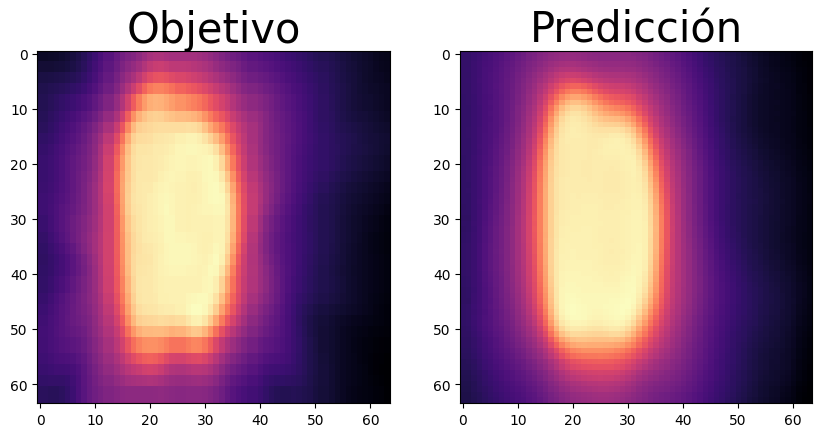

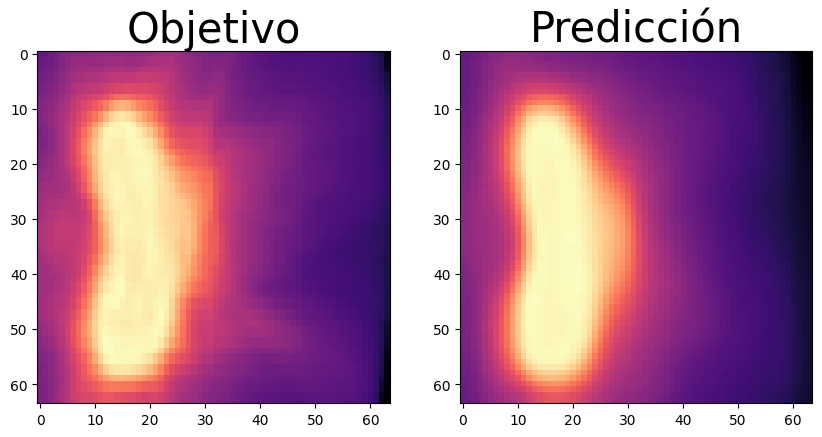

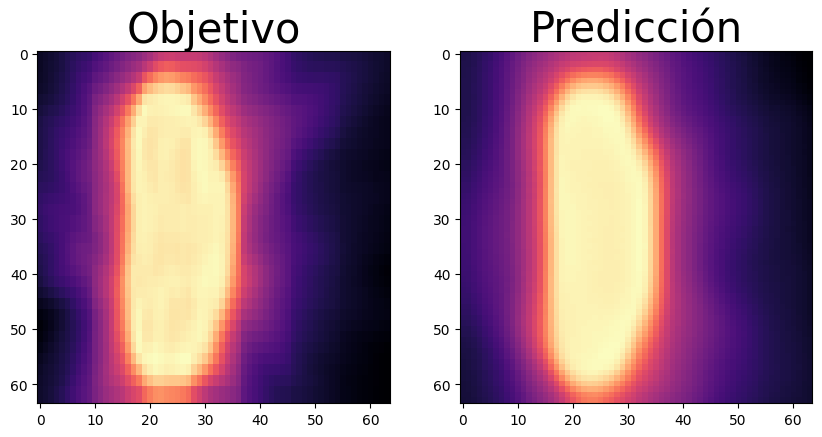

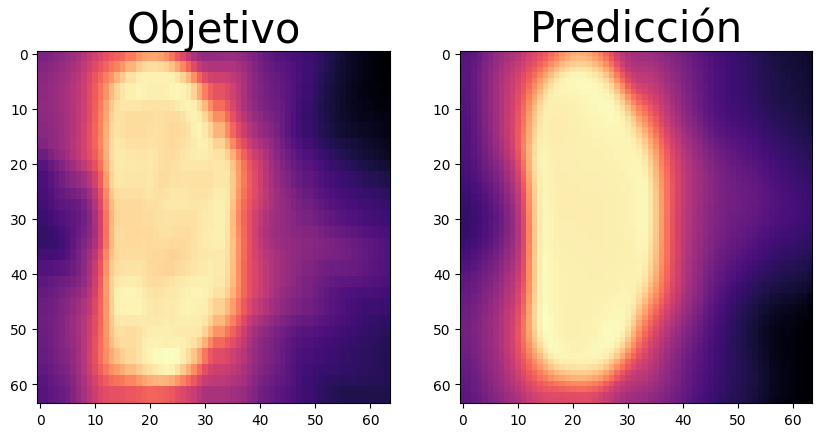

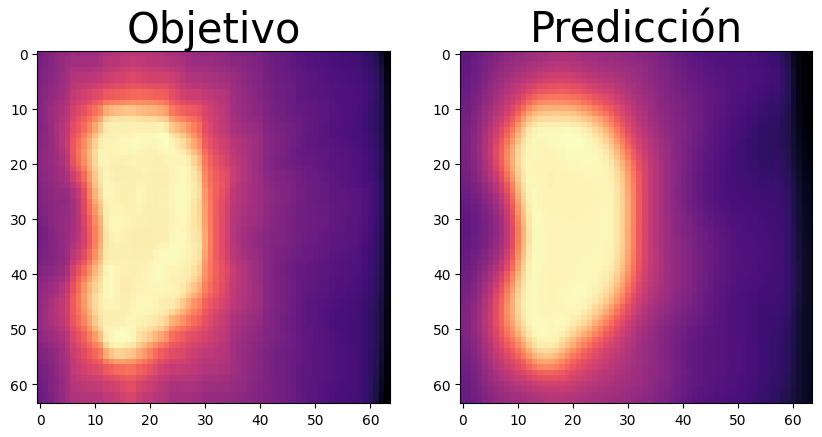

In [29]:
model.to(device)
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        pred_mask = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()

In [30]:
predecir("DatasetPI/TesteoPI/UB")

Carpetas cargadas
La carpeta Estructuras tiene 30 volúmenes y la carpeta Dosis tiene 30 máscaras
La cantidad de imágenes de testeo son 30.
pred_UB_dosis0 guardada en DatasetPI/TesteoPI/UB
pred_UB_dosis1 guardada en DatasetPI/TesteoPI/UB
pred_UB_dosis10 guardada en DatasetPI/TesteoPI/UB
pred_UB_dosis11 guardada en DatasetPI/TesteoPI/UB
pred_UB_dosis12 guardada en DatasetPI/TesteoPI/UB
pred_UB_dosis122 guardada en DatasetPI/TesteoPI/UB
pred_UB_dosis13 guardada en DatasetPI/TesteoPI/UB
pred_UB_dosis2 guardada en DatasetPI/TesteoPI/UB
pred_UB_dosis3 guardada en DatasetPI/TesteoPI/UB
pred_UB_dosis4 guardada en DatasetPI/TesteoPI/UB
pred_UB_dosis5 guardada en DatasetPI/TesteoPI/UB
pred_UB_dosis6 guardada en DatasetPI/TesteoPI/UB
pred_UB_dosis7 guardada en DatasetPI/TesteoPI/UB
pred_UB_dosis8 guardada en DatasetPI/TesteoPI/UB
pred_UB_dosis9 guardada en DatasetPI/TesteoPI/UB
pred_UB_flip_dosis0 guardada en DatasetPI/TesteoPI/UB
pred_UB_flip_dosis1 guardada en DatasetPI/TesteoPI/UB
pred_UB_flip

## U-Net Mejorada

In [24]:
model = UNetM()
model = model.to(device)
dataloader, dataset = traindata()

Carpetas cargadas
La carpeta Estructuras tiene 240 volúmenes y la carpeta Dosis tiene 240 máscaras
La cantidad de imágenes de entrenamiento son 180 y la cantidad de validación son 60.


In [25]:
hist, met = fit(model= model, device= device, epochs=500, loss_fn = torch.nn.MSELoss())


Epoch 1/500


val_loss: 0.03141, iou: 0.16972, dice: 0.28787: 100%|██████████| 30/30 [00:02<00:00, 14.17it/s]


El loss de validación mejoró de inf a 0.0314. Guardando checkpoint: file/checkpoint.pth

Epoch 2/500


val_loss: 0.01449, iou: 0.29868, dice: 0.45486: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]


El loss de validación mejoró de 0.0314 a 0.0145. Guardando checkpoint: file/checkpoint.pth

Epoch 3/500


val_loss: 0.01590, iou: 0.22626, dice: 0.36569: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 4/500


val_loss: 0.02025, iou: 0.13614, dice: 0.23900: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 5/500


val_loss: 0.01173, iou: 0.25248, dice: 0.40095: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]


El loss de validación mejoró de 0.0145 a 0.0117. Guardando checkpoint: file/checkpoint.pth

Epoch 6/500


val_loss: 0.00640, iou: 0.40767, dice: 0.57188: 100%|██████████| 30/30 [00:02<00:00, 14.53it/s]


El loss de validación mejoró de 0.0117 a 0.0064. Guardando checkpoint: file/checkpoint.pth

Epoch 7/500


val_loss: 0.02472, iou: 0.31427, dice: 0.47464: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 8/500


val_loss: 0.00702, iou: 0.39353, dice: 0.55933: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 9/500


val_loss: 0.00554, iou: 0.39256, dice: 0.55985: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]


El loss de validación mejoró de 0.0064 a 0.0055. Guardando checkpoint: file/checkpoint.pth

Epoch 10/500


val_loss: 0.00708, iou: 0.40137, dice: 0.56907: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 11/500


val_loss: 0.00374, iou: 0.48296, dice: 0.64615: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]


El loss de validación mejoró de 0.0055 a 0.0037. Guardando checkpoint: file/checkpoint.pth

Epoch 12/500


val_loss: 0.00401, iou: 0.46911, dice: 0.63363: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 13/500


val_loss: 0.00445, iou: 0.45303, dice: 0.61538: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 14/500


val_loss: 0.00285, iou: 0.52454, dice: 0.68331: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]


El loss de validación mejoró de 0.0037 a 0.0029. Guardando checkpoint: file/checkpoint.pth

Epoch 15/500


val_loss: 0.00874, iou: 0.33091, dice: 0.49318: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 16/500


val_loss: 0.00534, iou: 0.42568, dice: 0.59050: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 17/500


val_loss: 0.00325, iou: 0.50079, dice: 0.66357: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 18/500


val_loss: 0.00306, iou: 0.50041, dice: 0.66479: 100%|██████████| 30/30 [00:02<00:00, 14.55it/s]



Epoch 19/500


val_loss: 0.00308, iou: 0.53027, dice: 0.68858: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 20/500


val_loss: 0.00363, iou: 0.47554, dice: 0.64001: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 21/500


val_loss: 0.00337, iou: 0.52154, dice: 0.68259: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 22/500


val_loss: 0.00323, iou: 0.49855, dice: 0.66216: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 23/500


val_loss: 0.00268, iou: 0.55011, dice: 0.70599: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]


El loss de validación mejoró de 0.0029 a 0.0027. Guardando checkpoint: file/checkpoint.pth

Epoch 24/500


val_loss: 0.00216, iou: 0.54673, dice: 0.70371: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]


El loss de validación mejoró de 0.0027 a 0.0022. Guardando checkpoint: file/checkpoint.pth

Epoch 25/500


val_loss: 0.00819, iou: 0.35895, dice: 0.52250: 100%|██████████| 30/30 [00:02<00:00, 14.53it/s]



Epoch 26/500


val_loss: 0.00402, iou: 0.44063, dice: 0.60737: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 27/500


val_loss: 0.00224, iou: 0.54898, dice: 0.70518: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 28/500


val_loss: 0.00216, iou: 0.55497, dice: 0.71214: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]


El loss de validación mejoró de 0.0022 a 0.0022. Guardando checkpoint: file/checkpoint.pth

Epoch 29/500


val_loss: 0.00243, iou: 0.55363, dice: 0.70949: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]



Epoch 30/500


val_loss: 0.00230, iou: 0.55860, dice: 0.71424: 100%|██████████| 30/30 [00:02<00:00, 14.54it/s]



Epoch 31/500


val_loss: 0.00232, iou: 0.56169, dice: 0.71615: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 32/500


val_loss: 0.00205, iou: 0.56056, dice: 0.71629: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]


El loss de validación mejoró de 0.0022 a 0.0020. Guardando checkpoint: file/checkpoint.pth

Epoch 33/500


val_loss: 0.00197, iou: 0.54468, dice: 0.70388: 100%|██████████| 30/30 [00:02<00:00, 14.53it/s]


El loss de validación mejoró de 0.0020 a 0.0020. Guardando checkpoint: file/checkpoint.pth

Epoch 34/500


val_loss: 0.00291, iou: 0.49635, dice: 0.65936: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 35/500


val_loss: 0.00215, iou: 0.56608, dice: 0.72050: 100%|██████████| 30/30 [00:02<00:00, 14.53it/s]



Epoch 36/500


val_loss: 0.00207, iou: 0.56669, dice: 0.72154: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 37/500


val_loss: 0.00273, iou: 0.52254, dice: 0.68409: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 38/500


val_loss: 0.00220, iou: 0.56234, dice: 0.71751: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 39/500


val_loss: 0.00189, iou: 0.59519, dice: 0.74395: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]


El loss de validación mejoró de 0.0020 a 0.0019. Guardando checkpoint: file/checkpoint.pth

Epoch 40/500


val_loss: 0.00209, iou: 0.56170, dice: 0.71726: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 41/500


val_loss: 0.00174, iou: 0.59147, dice: 0.74149: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]


El loss de validación mejoró de 0.0019 a 0.0017. Guardando checkpoint: file/checkpoint.pth

Epoch 42/500


val_loss: 0.00208, iou: 0.58362, dice: 0.73387: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]



Epoch 43/500


val_loss: 0.00182, iou: 0.58084, dice: 0.73287: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 44/500


val_loss: 0.00174, iou: 0.58970, dice: 0.74051: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]


El loss de validación mejoró de 0.0017 a 0.0017. Guardando checkpoint: file/checkpoint.pth

Epoch 45/500


val_loss: 0.00177, iou: 0.58023, dice: 0.73316: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 46/500


val_loss: 0.00166, iou: 0.59628, dice: 0.74532: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]


El loss de validación mejoró de 0.0017 a 0.0017. Guardando checkpoint: file/checkpoint.pth

Epoch 47/500


val_loss: 0.00185, iou: 0.57745, dice: 0.72977: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]



Epoch 48/500


val_loss: 0.00175, iou: 0.56181, dice: 0.71864: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 49/500


val_loss: 0.00176, iou: 0.57042, dice: 0.72541: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 50/500


val_loss: 0.00168, iou: 0.59870, dice: 0.74656: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 51/500


val_loss: 0.00180, iou: 0.60041, dice: 0.74797: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 52/500


val_loss: 0.00175, iou: 0.55711, dice: 0.71380: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 53/500


val_loss: 0.00192, iou: 0.58681, dice: 0.73779: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 54/500


val_loss: 0.00168, iou: 0.60413, dice: 0.75157: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 55/500


val_loss: 0.00163, iou: 0.57148, dice: 0.72636: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]


El loss de validación mejoró de 0.0017 a 0.0016. Guardando checkpoint: file/checkpoint.pth

Epoch 56/500


val_loss: 0.00225, iou: 0.53784, dice: 0.69788: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 57/500


val_loss: 0.00170, iou: 0.60243, dice: 0.74996: 100%|██████████| 30/30 [00:02<00:00, 14.57it/s]



Epoch 58/500


val_loss: 0.00179, iou: 0.59129, dice: 0.74173: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 59/500


val_loss: 0.00177, iou: 0.60871, dice: 0.75410: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 60/500


val_loss: 0.00158, iou: 0.60364, dice: 0.75063: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]


El loss de validación mejoró de 0.0016 a 0.0016. Guardando checkpoint: file/checkpoint.pth

Epoch 61/500


val_loss: 0.00168, iou: 0.58415, dice: 0.73656: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]



Epoch 62/500


val_loss: 0.00227, iou: 0.52665, dice: 0.68892: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 63/500


val_loss: 0.00150, iou: 0.55424, dice: 0.71252: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]


El loss de validación mejoró de 0.0016 a 0.0015. Guardando checkpoint: file/checkpoint.pth

Epoch 64/500


val_loss: 0.00205, iou: 0.58695, dice: 0.73776: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 65/500


val_loss: 0.00190, iou: 0.59260, dice: 0.74120: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 66/500


val_loss: 0.00176, iou: 0.57630, dice: 0.72987: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 67/500


val_loss: 0.00157, iou: 0.59942, dice: 0.74817: 100%|██████████| 30/30 [00:02<00:00, 14.55it/s]



Epoch 68/500


val_loss: 0.00201, iou: 0.59750, dice: 0.74623: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 69/500


val_loss: 0.00161, iou: 0.61247, dice: 0.75802: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 70/500


val_loss: 0.00162, iou: 0.58053, dice: 0.73343: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 71/500


val_loss: 0.00148, iou: 0.62520, dice: 0.76790: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]


El loss de validación mejoró de 0.0015 a 0.0015. Guardando checkpoint: file/checkpoint.pth

Epoch 72/500


val_loss: 0.00182, iou: 0.57815, dice: 0.73159: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 73/500


val_loss: 0.00167, iou: 0.60537, dice: 0.75280: 100%|██████████| 30/30 [00:02<00:00, 14.54it/s]



Epoch 74/500


val_loss: 0.00182, iou: 0.55195, dice: 0.71024: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 75/500


val_loss: 0.00171, iou: 0.59141, dice: 0.74168: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]



Epoch 76/500


val_loss: 0.00155, iou: 0.53570, dice: 0.69653: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 77/500


val_loss: 0.00155, iou: 0.56239, dice: 0.71870: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 78/500


val_loss: 0.00178, iou: 0.58848, dice: 0.73934: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 79/500


val_loss: 0.00175, iou: 0.61619, dice: 0.76064: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 80/500


val_loss: 0.00185, iou: 0.59618, dice: 0.74463: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 81/500


val_loss: 0.00140, iou: 0.63274, dice: 0.77338: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]


El loss de validación mejoró de 0.0015 a 0.0014. Guardando checkpoint: file/checkpoint.pth

Epoch 82/500


val_loss: 0.00150, iou: 0.58561, dice: 0.73712: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 83/500


val_loss: 0.00152, iou: 0.59723, dice: 0.74656: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 84/500


val_loss: 0.00161, iou: 0.61719, dice: 0.76185: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 85/500


val_loss: 0.00160, iou: 0.61169, dice: 0.75734: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 86/500


val_loss: 0.00141, iou: 0.62291, dice: 0.76609: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 87/500


val_loss: 0.00149, iou: 0.56980, dice: 0.72443: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 88/500


val_loss: 0.00152, iou: 0.61237, dice: 0.75791: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 89/500


val_loss: 0.00182, iou: 0.58071, dice: 0.73310: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 90/500


val_loss: 0.00200, iou: 0.58348, dice: 0.73519: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 91/500


val_loss: 0.00158, iou: 0.59382, dice: 0.74389: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 92/500


val_loss: 0.03665, iou: 0.09149, dice: 0.16687: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 93/500


val_loss: 0.00991, iou: 0.31438, dice: 0.47597: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 94/500


val_loss: 0.00356, iou: 0.49888, dice: 0.66011: 100%|██████████| 30/30 [00:02<00:00, 14.57it/s]



Epoch 95/500


val_loss: 0.00254, iou: 0.52741, dice: 0.68876: 100%|██████████| 30/30 [00:02<00:00, 14.56it/s]



Epoch 96/500


val_loss: 0.00209, iou: 0.50775, dice: 0.67244: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 97/500


val_loss: 0.00196, iou: 0.57023, dice: 0.72482: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 98/500


val_loss: 0.00267, iou: 0.51422, dice: 0.67638: 100%|██████████| 30/30 [00:02<00:00, 14.53it/s]



Epoch 99/500


val_loss: 0.00192, iou: 0.55615, dice: 0.71360: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 100/500


val_loss: 0.00173, iou: 0.59429, dice: 0.74324: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 101/500


val_loss: 0.00163, iou: 0.58244, dice: 0.73476: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 102/500


val_loss: 0.00190, iou: 0.59032, dice: 0.74059: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 103/500


val_loss: 0.00176, iou: 0.57749, dice: 0.73056: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 104/500


val_loss: 0.00180, iou: 0.56277, dice: 0.71913: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 105/500


val_loss: 0.00166, iou: 0.57599, dice: 0.73016: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 106/500


val_loss: 0.00157, iou: 0.55088, dice: 0.70969: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 107/500


val_loss: 0.00157, iou: 0.57685, dice: 0.73053: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 108/500


val_loss: 0.00161, iou: 0.60383, dice: 0.75172: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 109/500


val_loss: 0.00151, iou: 0.59514, dice: 0.74512: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 110/500


val_loss: 0.00142, iou: 0.62393, dice: 0.76641: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 111/500


val_loss: 0.00172, iou: 0.60677, dice: 0.75360: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 112/500


val_loss: 0.00158, iou: 0.62053, dice: 0.76410: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 113/500


val_loss: 0.00200, iou: 0.54900, dice: 0.70670: 100%|██████████| 30/30 [00:02<00:00, 14.57it/s]



Epoch 114/500


val_loss: 0.00137, iou: 0.61250, dice: 0.75854: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]


El loss de validación mejoró de 0.0014 a 0.0014. Guardando checkpoint: file/checkpoint.pth

Epoch 115/500


val_loss: 0.00150, iou: 0.62198, dice: 0.76563: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 116/500


val_loss: 0.00136, iou: 0.59448, dice: 0.74453: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]


El loss de validación mejoró de 0.0014 a 0.0014. Guardando checkpoint: file/checkpoint.pth

Epoch 117/500


val_loss: 0.00138, iou: 0.60268, dice: 0.75099: 100%|██████████| 30/30 [00:02<00:00, 14.53it/s]



Epoch 118/500


val_loss: 0.00144, iou: 0.59061, dice: 0.74168: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 119/500


val_loss: 0.00165, iou: 0.59440, dice: 0.74432: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]



Epoch 120/500


val_loss: 0.00145, iou: 0.55965, dice: 0.71619: 100%|██████████| 30/30 [00:02<00:00, 14.57it/s]



Epoch 121/500


val_loss: 0.00134, iou: 0.62361, dice: 0.76666: 100%|██████████| 30/30 [00:02<00:00, 14.56it/s]


El loss de validación mejoró de 0.0014 a 0.0013. Guardando checkpoint: file/checkpoint.pth

Epoch 122/500


val_loss: 0.00150, iou: 0.59949, dice: 0.74852: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 123/500


val_loss: 0.00139, iou: 0.62713, dice: 0.76955: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 124/500


val_loss: 0.00145, iou: 0.59344, dice: 0.74373: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]



Epoch 125/500


val_loss: 0.00134, iou: 0.63276, dice: 0.77364: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 126/500


val_loss: 0.00122, iou: 0.64900, dice: 0.78569: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]


El loss de validación mejoró de 0.0013 a 0.0012. Guardando checkpoint: file/checkpoint.pth

Epoch 127/500


val_loss: 0.00146, iou: 0.59600, dice: 0.74542: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 128/500


val_loss: 0.00150, iou: 0.60213, dice: 0.75014: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 129/500


val_loss: 0.00131, iou: 0.63565, dice: 0.77564: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 130/500


val_loss: 0.00174, iou: 0.61470, dice: 0.75986: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 131/500


val_loss: 0.00183, iou: 0.56085, dice: 0.71730: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 132/500


val_loss: 0.00139, iou: 0.61302, dice: 0.75869: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 133/500


val_loss: 0.00143, iou: 0.63777, dice: 0.77723: 100%|██████████| 30/30 [00:02<00:00, 14.53it/s]



Epoch 134/500


val_loss: 0.00133, iou: 0.59039, dice: 0.74112: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 135/500


val_loss: 0.00132, iou: 0.63136, dice: 0.77279: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 136/500


val_loss: 0.00125, iou: 0.61826, dice: 0.76307: 100%|██████████| 30/30 [00:02<00:00, 14.54it/s]



Epoch 137/500


val_loss: 0.00130, iou: 0.59811, dice: 0.74719: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 138/500


val_loss: 0.00130, iou: 0.59746, dice: 0.74656: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 139/500


val_loss: 0.00151, iou: 0.61964, dice: 0.76340: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 140/500


val_loss: 0.00121, iou: 0.63871, dice: 0.77851: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]


El loss de validación mejoró de 0.0012 a 0.0012. Guardando checkpoint: file/checkpoint.pth

Epoch 141/500


val_loss: 0.00692, iou: 0.34902, dice: 0.51534: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 142/500


val_loss: 0.00264, iou: 0.52893, dice: 0.68865: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]



Epoch 143/500


val_loss: 0.00198, iou: 0.56123, dice: 0.71727: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 144/500


val_loss: 0.00180, iou: 0.57738, dice: 0.73057: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 145/500


val_loss: 0.00171, iou: 0.59259, dice: 0.74219: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 146/500


val_loss: 0.00180, iou: 0.59843, dice: 0.74695: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 147/500


val_loss: 0.00164, iou: 0.60479, dice: 0.75234: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 148/500


val_loss: 0.00161, iou: 0.61652, dice: 0.76090: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 149/500


val_loss: 0.00147, iou: 0.60144, dice: 0.75016: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 150/500


val_loss: 0.00141, iou: 0.62564, dice: 0.76846: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 151/500


val_loss: 0.00148, iou: 0.59722, dice: 0.74666: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 152/500


val_loss: 0.00146, iou: 0.58670, dice: 0.73843: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 153/500


val_loss: 0.00141, iou: 0.59795, dice: 0.74705: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 154/500


val_loss: 0.00144, iou: 0.58680, dice: 0.73840: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 155/500


val_loss: 0.00131, iou: 0.61578, dice: 0.76109: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 156/500


val_loss: 0.00136, iou: 0.61039, dice: 0.75675: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 157/500


val_loss: 0.00137, iou: 0.62201, dice: 0.76555: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 158/500


val_loss: 0.00125, iou: 0.60376, dice: 0.75179: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 159/500


val_loss: 0.00139, iou: 0.60664, dice: 0.75402: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 160/500


val_loss: 0.00145, iou: 0.59974, dice: 0.74852: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 161/500


val_loss: 0.00130, iou: 0.62515, dice: 0.76830: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 162/500


val_loss: 0.00158, iou: 0.63101, dice: 0.77214: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 163/500


val_loss: 0.00129, iou: 0.62580, dice: 0.76856: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 164/500


val_loss: 0.00132, iou: 0.63869, dice: 0.77817: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 165/500


val_loss: 0.00125, iou: 0.64135, dice: 0.78020: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 166/500


val_loss: 0.00129, iou: 0.62645, dice: 0.76912: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]



Epoch 167/500


val_loss: 0.00122, iou: 0.65370, dice: 0.78925: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 168/500


val_loss: 0.00129, iou: 0.63261, dice: 0.77382: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 169/500


val_loss: 0.00142, iou: 0.59417, dice: 0.74444: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 170/500


val_loss: 0.00120, iou: 0.64103, dice: 0.78014: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]


El loss de validación mejoró de 0.0012 a 0.0012. Guardando checkpoint: file/checkpoint.pth

Epoch 171/500


val_loss: 0.00131, iou: 0.56601, dice: 0.72159: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 172/500


val_loss: 0.00130, iou: 0.63971, dice: 0.77917: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 173/500


val_loss: 0.00143, iou: 0.56236, dice: 0.71876: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 174/500


val_loss: 0.00117, iou: 0.64531, dice: 0.78311: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]


El loss de validación mejoró de 0.0012 a 0.0012. Guardando checkpoint: file/checkpoint.pth

Epoch 175/500


val_loss: 0.00138, iou: 0.63561, dice: 0.77601: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 176/500


val_loss: 0.00132, iou: 0.59998, dice: 0.74868: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]



Epoch 177/500


val_loss: 0.00133, iou: 0.64763, dice: 0.78478: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 178/500


val_loss: 0.00118, iou: 0.65268, dice: 0.78842: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 179/500


val_loss: 0.00117, iou: 0.65153, dice: 0.78771: 100%|██████████| 30/30 [00:02<00:00, 14.54it/s]



Epoch 180/500


val_loss: 0.00122, iou: 0.62738, dice: 0.76965: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 181/500


val_loss: 0.00124, iou: 0.60572, dice: 0.75338: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 182/500


val_loss: 0.00163, iou: 0.56232, dice: 0.71853: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 183/500


val_loss: 0.00115, iou: 0.66033, dice: 0.79385: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]


El loss de validación mejoró de 0.0012 a 0.0012. Guardando checkpoint: file/checkpoint.pth

Epoch 184/500


val_loss: 0.00133, iou: 0.63977, dice: 0.77904: 100%|██████████| 30/30 [00:02<00:00, 14.58it/s]



Epoch 185/500


val_loss: 0.00127, iou: 0.62498, dice: 0.76754: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 186/500


val_loss: 0.00142, iou: 0.55918, dice: 0.71560: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 187/500


val_loss: 0.00114, iou: 0.64278, dice: 0.78134: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]


El loss de validación mejoró de 0.0012 a 0.0011. Guardando checkpoint: file/checkpoint.pth

Epoch 188/500


val_loss: 0.00160, iou: 0.60514, dice: 0.75269: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 189/500


val_loss: 0.00126, iou: 0.62107, dice: 0.76513: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 190/500


val_loss: 0.00116, iou: 0.64962, dice: 0.78642: 100%|██████████| 30/30 [00:02<00:00, 14.37it/s]



Epoch 191/500


val_loss: 0.00130, iou: 0.62054, dice: 0.76452: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 192/500


val_loss: 0.00124, iou: 0.61949, dice: 0.76376: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 193/500


val_loss: 0.00132, iou: 0.64023, dice: 0.77919: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 194/500


val_loss: 0.00126, iou: 0.61618, dice: 0.76115: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 195/500


val_loss: 0.00120, iou: 0.61216, dice: 0.75814: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]



Epoch 196/500


val_loss: 0.00129, iou: 0.64926, dice: 0.78583: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 197/500


val_loss: 0.00128, iou: 0.60162, dice: 0.74977: 100%|██████████| 30/30 [00:02<00:00, 14.54it/s]



Epoch 198/500


val_loss: 0.00116, iou: 0.63092, dice: 0.77244: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 199/500


val_loss: 0.00112, iou: 0.64928, dice: 0.78632: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]


El loss de validación mejoró de 0.0011 a 0.0011. Guardando checkpoint: file/checkpoint.pth

Epoch 200/500


val_loss: 0.00130, iou: 0.57354, dice: 0.72788: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 201/500


val_loss: 0.00109, iou: 0.66053, dice: 0.79425: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]


El loss de validación mejoró de 0.0011 a 0.0011. Guardando checkpoint: file/checkpoint.pth

Epoch 202/500


val_loss: 0.00123, iou: 0.62375, dice: 0.76702: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 203/500


val_loss: 0.00136, iou: 0.64198, dice: 0.78051: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 204/500


val_loss: 0.00120, iou: 0.62563, dice: 0.76850: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]



Epoch 205/500


val_loss: 0.00113, iou: 0.65326, dice: 0.78918: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 206/500


val_loss: 0.00107, iou: 0.66374, dice: 0.79661: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]


El loss de validación mejoró de 0.0011 a 0.0011. Guardando checkpoint: file/checkpoint.pth

Epoch 207/500


val_loss: 0.00113, iou: 0.62334, dice: 0.76673: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 208/500


val_loss: 0.00129, iou: 0.59050, dice: 0.74147: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 209/500


val_loss: 0.00146, iou: 0.60646, dice: 0.75373: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 210/500


val_loss: 0.00117, iou: 0.63716, dice: 0.77720: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 211/500


val_loss: 0.00115, iou: 0.64864, dice: 0.78569: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 212/500


val_loss: 0.00130, iou: 0.54805, dice: 0.70679: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]



Epoch 213/500


val_loss: 0.00118, iou: 0.63900, dice: 0.77829: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 214/500


val_loss: 0.00121, iou: 0.61244, dice: 0.75819: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 215/500


val_loss: 0.00112, iou: 0.66283, dice: 0.79554: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 216/500


val_loss: 0.00106, iou: 0.64023, dice: 0.77938: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]


El loss de validación mejoró de 0.0011 a 0.0011. Guardando checkpoint: file/checkpoint.pth

Epoch 217/500


val_loss: 0.00113, iou: 0.61446, dice: 0.76013: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 218/500


val_loss: 0.00126, iou: 0.55237, dice: 0.71054: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 219/500


val_loss: 0.00125, iou: 0.58082, dice: 0.73347: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 220/500


val_loss: 0.00114, iou: 0.63020, dice: 0.77204: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]



Epoch 221/500


val_loss: 0.00108, iou: 0.63488, dice: 0.77560: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 222/500


val_loss: 0.00113, iou: 0.65441, dice: 0.78949: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 223/500


val_loss: 0.00125, iou: 0.57891, dice: 0.73194: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 224/500


val_loss: 0.00119, iou: 0.62121, dice: 0.76494: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 225/500


val_loss: 0.00121, iou: 0.64218, dice: 0.78095: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 226/500


val_loss: 0.00104, iou: 0.64810, dice: 0.78537: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]


El loss de validación mejoró de 0.0011 a 0.0010. Guardando checkpoint: file/checkpoint.pth

Epoch 227/500


val_loss: 0.00116, iou: 0.60869, dice: 0.75551: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]



Epoch 228/500


val_loss: 0.00120, iou: 0.63360, dice: 0.77472: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s]



Epoch 229/500


val_loss: 0.00109, iou: 0.65032, dice: 0.78692: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 230/500


val_loss: 0.00136, iou: 0.63148, dice: 0.77257: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 231/500


val_loss: 0.00116, iou: 0.65345, dice: 0.78915: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]



Epoch 232/500


val_loss: 0.00114, iou: 0.65074, dice: 0.78721: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 233/500


val_loss: 0.00103, iou: 0.64163, dice: 0.78061: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]


El loss de validación mejoró de 0.0010 a 0.0010. Guardando checkpoint: file/checkpoint.pth

Epoch 234/500


val_loss: 0.00114, iou: 0.63501, dice: 0.77554: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 235/500


val_loss: 0.00112, iou: 0.65198, dice: 0.78813: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 236/500


val_loss: 0.00114, iou: 0.59769, dice: 0.74667: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 237/500


val_loss: 0.00102, iou: 0.67571, dice: 0.80530: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]


El loss de validación mejoró de 0.0010 a 0.0010. Guardando checkpoint: file/checkpoint.pth

Epoch 238/500


val_loss: 0.00111, iou: 0.64942, dice: 0.78643: 100%|██████████| 30/30 [00:02<00:00, 14.53it/s]



Epoch 239/500


val_loss: 0.00108, iou: 0.62098, dice: 0.76495: 100%|██████████| 30/30 [00:02<00:00, 14.56it/s]



Epoch 240/500


val_loss: 0.00117, iou: 0.64250, dice: 0.78125: 100%|██████████| 30/30 [00:02<00:00, 14.53it/s]



Epoch 241/500


val_loss: 0.00105, iou: 0.65215, dice: 0.78833: 100%|██████████| 30/30 [00:02<00:00, 14.53it/s]



Epoch 242/500


val_loss: 0.00107, iou: 0.65629, dice: 0.79135: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 243/500


val_loss: 0.00128, iou: 0.53788, dice: 0.69809: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 244/500


val_loss: 0.00114, iou: 0.63868, dice: 0.77828: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 245/500


val_loss: 0.00120, iou: 0.65350, dice: 0.78908: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 246/500


val_loss: 0.00111, iou: 0.61473, dice: 0.76057: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 247/500


val_loss: 0.00110, iou: 0.63632, dice: 0.77641: 100%|██████████| 30/30 [00:02<00:00, 14.49it/s]



Epoch 248/500


val_loss: 0.00110, iou: 0.65282, dice: 0.78886: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]



Epoch 249/500


val_loss: 0.00106, iou: 0.65832, dice: 0.79276: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 250/500


val_loss: 0.00119, iou: 0.65685, dice: 0.79163: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 251/500


val_loss: 0.00133, iou: 0.64387, dice: 0.78211: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]



Epoch 252/500


val_loss: 0.00108, iou: 0.63376, dice: 0.77477: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 253/500


val_loss: 0.00117, iou: 0.65349, dice: 0.78855: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 254/500


val_loss: 0.00121, iou: 0.60791, dice: 0.75485: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 255/500


val_loss: 0.00110, iou: 0.63048, dice: 0.77239: 100%|██████████| 30/30 [00:02<00:00, 14.54it/s]



Epoch 256/500


val_loss: 0.00100, iou: 0.65611, dice: 0.79126: 100%|██████████| 30/30 [00:02<00:00, 14.33it/s]


El loss de validación mejoró de 0.0010 a 0.0010. Guardando checkpoint: file/checkpoint.pth

Epoch 257/500


val_loss: 0.00102, iou: 0.64420, dice: 0.78234: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 258/500


val_loss: 0.00108, iou: 0.65937, dice: 0.79348: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 259/500


val_loss: 0.00109, iou: 0.63311, dice: 0.77411: 100%|██████████| 30/30 [00:02<00:00, 14.51it/s]



Epoch 260/500


val_loss: 0.00103, iou: 0.66657, dice: 0.79871: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 261/500


val_loss: 0.00105, iou: 0.65054, dice: 0.78726: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s]



Epoch 262/500


val_loss: 0.00115, iou: 0.62865, dice: 0.77093: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 263/500


val_loss: 0.00099, iou: 0.65632, dice: 0.79141: 100%|██████████| 30/30 [00:02<00:00, 14.33it/s]


El loss de validación mejoró de 0.0010 a 0.0010. Guardando checkpoint: file/checkpoint.pth

Epoch 264/500


val_loss: 0.00101, iou: 0.64591, dice: 0.78367: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 265/500


val_loss: 0.00114, iou: 0.63768, dice: 0.77761: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]



Epoch 266/500


val_loss: 0.00115, iou: 0.59646, dice: 0.74637: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 267/500


val_loss: 0.00105, iou: 0.64438, dice: 0.78269: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 268/500


val_loss: 0.00105, iou: 0.65461, dice: 0.79011: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]



Epoch 269/500


val_loss: 0.00098, iou: 0.67574, dice: 0.80550: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]


El loss de validación mejoró de 0.0010 a 0.0010. Guardando checkpoint: file/checkpoint.pth

Epoch 270/500


val_loss: 0.00104, iou: 0.67236, dice: 0.80281: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]



Epoch 271/500


val_loss: 0.00110, iou: 0.62713, dice: 0.76977: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 272/500


val_loss: 0.00120, iou: 0.59705, dice: 0.74606: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 273/500


val_loss: 0.00108, iou: 0.66300, dice: 0.79607: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 274/500


val_loss: 0.00109, iou: 0.65340, dice: 0.78925: 100%|██████████| 30/30 [00:02<00:00, 14.48it/s]



Epoch 275/500


val_loss: 0.00104, iou: 0.64816, dice: 0.78540: 100%|██████████| 30/30 [00:02<00:00, 14.30it/s]



Epoch 276/500


val_loss: 0.00104, iou: 0.65803, dice: 0.79262: 100%|██████████| 30/30 [00:02<00:00, 14.50it/s]



Epoch 277/500


val_loss: 0.00102, iou: 0.66567, dice: 0.79823: 100%|██████████| 30/30 [00:02<00:00, 14.29it/s]



Epoch 278/500


val_loss: 0.00116, iou: 0.61971, dice: 0.76419: 100%|██████████| 30/30 [00:02<00:00, 14.31it/s]



Epoch 279/500


val_loss: 0.00106, iou: 0.62604, dice: 0.76893: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 280/500


val_loss: 0.00097, iou: 0.64818, dice: 0.78552: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]


El loss de validación mejoró de 0.0010 a 0.0010. Guardando checkpoint: file/checkpoint.pth

Epoch 281/500


val_loss: 0.00099, iou: 0.66555, dice: 0.79806: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 282/500


val_loss: 0.00109, iou: 0.63514, dice: 0.77570: 100%|██████████| 30/30 [00:02<00:00, 13.97it/s]



Epoch 283/500


val_loss: 0.00112, iou: 0.60283, dice: 0.75119: 100%|██████████| 30/30 [00:02<00:00, 14.26it/s]



Epoch 284/500


val_loss: 0.00110, iou: 0.65535, dice: 0.79080: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 285/500


val_loss: 0.00097, iou: 0.67502, dice: 0.80472: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]


El loss de validación mejoró de 0.0010 a 0.0010. Guardando checkpoint: file/checkpoint.pth

Epoch 286/500


val_loss: 0.00107, iou: 0.65215, dice: 0.78838: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 287/500


val_loss: 0.00097, iou: 0.67155, dice: 0.80243: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 288/500


val_loss: 0.00098, iou: 0.65936, dice: 0.79362: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 289/500


val_loss: 0.00104, iou: 0.62162, dice: 0.76568: 100%|██████████| 30/30 [00:02<00:00, 14.22it/s]



Epoch 290/500


val_loss: 0.00094, iou: 0.67368, dice: 0.80390: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]


El loss de validación mejoró de 0.0010 a 0.0009. Guardando checkpoint: file/checkpoint.pth

Epoch 291/500


val_loss: 0.00103, iou: 0.67806, dice: 0.80694: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 292/500


val_loss: 0.00098, iou: 0.67987, dice: 0.80822: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 293/500


val_loss: 0.00097, iou: 0.65592, dice: 0.79108: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 294/500


val_loss: 0.00097, iou: 0.67184, dice: 0.80256: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 295/500


val_loss: 0.00112, iou: 0.62057, dice: 0.76479: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 296/500


val_loss: 0.00098, iou: 0.67493, dice: 0.80478: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 297/500


val_loss: 0.00121, iou: 0.65983, dice: 0.79371: 100%|██████████| 30/30 [00:02<00:00, 14.27it/s]



Epoch 298/500


val_loss: 0.00104, iou: 0.66737, dice: 0.79930: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 299/500


val_loss: 0.00108, iou: 0.65805, dice: 0.79253: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 300/500


val_loss: 0.00119, iou: 0.60452, dice: 0.75269: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 301/500


val_loss: 0.00103, iou: 0.65787, dice: 0.79234: 100%|██████████| 30/30 [00:02<00:00, 14.22it/s]



Epoch 302/500


val_loss: 0.00099, iou: 0.66012, dice: 0.79421: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 303/500


val_loss: 0.00092, iou: 0.67239, dice: 0.80296: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]


El loss de validación mejoró de 0.0009 a 0.0009. Guardando checkpoint: file/checkpoint.pth

Epoch 304/500


val_loss: 0.00100, iou: 0.62192, dice: 0.76592: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 305/500


val_loss: 0.00108, iou: 0.58848, dice: 0.74007: 100%|██████████| 30/30 [00:02<00:00, 14.32it/s]



Epoch 306/500


val_loss: 0.00095, iou: 0.67785, dice: 0.80685: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 307/500


val_loss: 0.00106, iou: 0.66752, dice: 0.79944: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 308/500


val_loss: 0.00105, iou: 0.61258, dice: 0.75881: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 309/500


val_loss: 0.00101, iou: 0.67337, dice: 0.80347: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 310/500


val_loss: 0.00106, iou: 0.61327, dice: 0.75933: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 311/500


val_loss: 0.00120, iou: 0.55835, dice: 0.71558: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 312/500


val_loss: 0.00105, iou: 0.66057, dice: 0.79447: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 313/500


val_loss: 0.00104, iou: 0.64880, dice: 0.78598: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 314/500


val_loss: 0.00094, iou: 0.66479, dice: 0.79767: 100%|██████████| 30/30 [00:02<00:00, 14.27it/s]



Epoch 315/500


val_loss: 0.00097, iou: 0.66010, dice: 0.79424: 100%|██████████| 30/30 [00:02<00:00, 14.31it/s]



Epoch 316/500


val_loss: 0.00099, iou: 0.64378, dice: 0.78229: 100%|██████████| 30/30 [00:02<00:00, 14.37it/s]



Epoch 317/500


val_loss: 0.00099, iou: 0.65234, dice: 0.78861: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 318/500


val_loss: 0.00092, iou: 0.68189, dice: 0.80977: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]


El loss de validación mejoró de 0.0009 a 0.0009. Guardando checkpoint: file/checkpoint.pth

Epoch 319/500


val_loss: 0.00106, iou: 0.62344, dice: 0.76721: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 320/500


val_loss: 0.00325, iou: 0.56241, dice: 0.71514: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 321/500


val_loss: 0.00149, iou: 0.61467, dice: 0.75984: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 322/500


val_loss: 0.00119, iou: 0.64581, dice: 0.78346: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]



Epoch 323/500


val_loss: 0.00115, iou: 0.64719, dice: 0.78459: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 324/500


val_loss: 0.00129, iou: 0.60950, dice: 0.75599: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 325/500


val_loss: 0.00110, iou: 0.62561, dice: 0.76844: 100%|██████████| 30/30 [00:02<00:00, 14.27it/s]



Epoch 326/500


val_loss: 0.00093, iou: 0.67584, dice: 0.80543: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 327/500


val_loss: 0.00102, iou: 0.64728, dice: 0.78476: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 328/500


val_loss: 0.00112, iou: 0.62876, dice: 0.77073: 100%|██████████| 30/30 [00:02<00:00, 14.30it/s]



Epoch 329/500


val_loss: 0.00095, iou: 0.66518, dice: 0.79777: 100%|██████████| 30/30 [00:02<00:00, 14.45it/s]



Epoch 330/500


val_loss: 0.00092, iou: 0.68628, dice: 0.81277: 100%|██████████| 30/30 [00:02<00:00, 14.46it/s]


El loss de validación mejoró de 0.0009 a 0.0009. Guardando checkpoint: file/checkpoint.pth

Epoch 331/500


val_loss: 0.00098, iou: 0.62909, dice: 0.77136: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 332/500


val_loss: 0.00092, iou: 0.66690, dice: 0.79905: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 333/500


val_loss: 0.00094, iou: 0.66136, dice: 0.79503: 100%|██████████| 30/30 [00:02<00:00, 14.34it/s]



Epoch 334/500


val_loss: 0.00093, iou: 0.64831, dice: 0.78543: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 335/500


val_loss: 0.00087, iou: 0.69130, dice: 0.81637: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s]


El loss de validación mejoró de 0.0009 a 0.0009. Guardando checkpoint: file/checkpoint.pth

Epoch 336/500


val_loss: 0.00089, iou: 0.68956, dice: 0.81505: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 337/500


val_loss: 0.00088, iou: 0.68380, dice: 0.81107: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 338/500


val_loss: 0.00089, iou: 0.66389, dice: 0.79693: 100%|██████████| 30/30 [00:02<00:00, 14.31it/s]



Epoch 339/500


val_loss: 0.00097, iou: 0.65752, dice: 0.79236: 100%|██████████| 30/30 [00:02<00:00, 14.28it/s]



Epoch 340/500


val_loss: 0.00093, iou: 0.67204, dice: 0.80267: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 341/500


val_loss: 0.00090, iou: 0.68372, dice: 0.81102: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 342/500


val_loss: 0.00097, iou: 0.66503, dice: 0.79767: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 343/500


val_loss: 0.00092, iou: 0.66507, dice: 0.79777: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 344/500


val_loss: 0.00097, iou: 0.63118, dice: 0.77304: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 345/500


val_loss: 0.00090, iou: 0.67006, dice: 0.80139: 100%|██████████| 30/30 [00:02<00:00, 14.29it/s]



Epoch 346/500


val_loss: 0.00089, iou: 0.65872, dice: 0.79305: 100%|██████████| 30/30 [00:02<00:00, 14.09it/s]



Epoch 347/500


val_loss: 0.00089, iou: 0.67428, dice: 0.80433: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 348/500


val_loss: 0.00091, iou: 0.65832, dice: 0.79272: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 349/500


val_loss: 0.00087, iou: 0.69042, dice: 0.81582: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]


El loss de validación mejoró de 0.0009 a 0.0009. Guardando checkpoint: file/checkpoint.pth

Epoch 350/500


val_loss: 0.00088, iou: 0.65954, dice: 0.79385: 100%|██████████| 30/30 [00:02<00:00, 14.33it/s]



Epoch 351/500


val_loss: 0.00106, iou: 0.60898, dice: 0.75594: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 352/500


val_loss: 0.00100, iou: 0.68632, dice: 0.81274: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 353/500


val_loss: 0.00091, iou: 0.67413, dice: 0.80430: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 354/500


val_loss: 0.00093, iou: 0.65126, dice: 0.78780: 100%|██████████| 30/30 [00:02<00:00, 14.29it/s]



Epoch 355/500


val_loss: 0.00089, iou: 0.66572, dice: 0.79819: 100%|██████████| 30/30 [00:02<00:00, 14.23it/s]



Epoch 356/500


val_loss: 0.00095, iou: 0.68368, dice: 0.81106: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 357/500


val_loss: 0.00088, iou: 0.66861, dice: 0.80046: 100%|██████████| 30/30 [00:02<00:00, 14.37it/s]



Epoch 358/500


val_loss: 0.00091, iou: 0.68672, dice: 0.81320: 100%|██████████| 30/30 [00:02<00:00, 14.27it/s]



Epoch 359/500


val_loss: 0.00088, iou: 0.68199, dice: 0.80979: 100%|██████████| 30/30 [00:02<00:00, 14.37it/s]



Epoch 360/500


val_loss: 0.00100, iou: 0.64694, dice: 0.78471: 100%|██████████| 30/30 [00:02<00:00, 14.37it/s]



Epoch 361/500


val_loss: 0.00102, iou: 0.65020, dice: 0.78692: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 362/500


val_loss: 0.00101, iou: 0.66313, dice: 0.79636: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s]



Epoch 363/500


val_loss: 0.00097, iou: 0.65889, dice: 0.79332: 100%|██████████| 30/30 [00:02<00:00, 14.37it/s]



Epoch 364/500


val_loss: 0.00101, iou: 0.65582, dice: 0.79107: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 365/500


val_loss: 0.00104, iou: 0.68595, dice: 0.81244: 100%|██████████| 30/30 [00:02<00:00, 14.33it/s]



Epoch 366/500


val_loss: 0.00098, iou: 0.63719, dice: 0.77733: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 367/500


val_loss: 0.00097, iou: 0.65365, dice: 0.78943: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 368/500


val_loss: 0.00087, iou: 0.69097, dice: 0.81610: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 369/500


val_loss: 0.00097, iou: 0.65530, dice: 0.79063: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 370/500


val_loss: 0.00106, iou: 0.64993, dice: 0.78664: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 371/500


val_loss: 0.00090, iou: 0.68213, dice: 0.81004: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 372/500


val_loss: 0.00104, iou: 0.65373, dice: 0.78926: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 373/500


val_loss: 0.00086, iou: 0.67832, dice: 0.80727: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]


El loss de validación mejoró de 0.0009 a 0.0009. Guardando checkpoint: file/checkpoint.pth

Epoch 374/500


val_loss: 0.00087, iou: 0.68868, dice: 0.81452: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 375/500


val_loss: 0.00098, iou: 0.65567, dice: 0.79105: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 376/500


val_loss: 0.00088, iou: 0.68585, dice: 0.81262: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 377/500


val_loss: 0.00095, iou: 0.65091, dice: 0.78739: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 378/500


val_loss: 0.00094, iou: 0.67324, dice: 0.80374: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 379/500


val_loss: 0.00091, iou: 0.68884, dice: 0.81471: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 380/500


val_loss: 0.00086, iou: 0.68699, dice: 0.81344: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 381/500


val_loss: 0.00094, iou: 0.67972, dice: 0.80818: 100%|██████████| 30/30 [00:02<00:00, 14.26it/s]



Epoch 382/500


val_loss: 0.00089, iou: 0.67412, dice: 0.80432: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 383/500


val_loss: 0.00109, iou: 0.67149, dice: 0.80169: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 384/500


val_loss: 0.00088, iou: 0.68637, dice: 0.81303: 100%|██████████| 30/30 [00:02<00:00, 14.37it/s]



Epoch 385/500


val_loss: 0.00099, iou: 0.64303, dice: 0.78160: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s]



Epoch 386/500


val_loss: 0.00095, iou: 0.65829, dice: 0.79293: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 387/500


val_loss: 0.00085, iou: 0.68642, dice: 0.81302: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]


El loss de validación mejoró de 0.0009 a 0.0008. Guardando checkpoint: file/checkpoint.pth

Epoch 388/500


val_loss: 0.00098, iou: 0.66945, dice: 0.80081: 100%|██████████| 30/30 [00:02<00:00, 14.30it/s]



Epoch 389/500


val_loss: 0.00085, iou: 0.68552, dice: 0.81228: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 390/500


val_loss: 0.00087, iou: 0.69009, dice: 0.81548: 100%|██████████| 30/30 [00:02<00:00, 14.34it/s]



Epoch 391/500


val_loss: 0.00091, iou: 0.66659, dice: 0.79896: 100%|██████████| 30/30 [00:02<00:00, 14.22it/s]



Epoch 392/500


val_loss: 0.00090, iou: 0.69133, dice: 0.81647: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 393/500


val_loss: 0.00091, iou: 0.65483, dice: 0.79055: 100%|██████████| 30/30 [00:02<00:00, 14.32it/s]



Epoch 394/500


val_loss: 0.00089, iou: 0.67013, dice: 0.80127: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 395/500


val_loss: 0.00095, iou: 0.67980, dice: 0.80824: 100%|██████████| 30/30 [00:02<00:00, 14.11it/s]



Epoch 396/500


val_loss: 0.00093, iou: 0.66609, dice: 0.79851: 100%|██████████| 30/30 [00:02<00:00, 14.23it/s]



Epoch 397/500


val_loss: 0.00092, iou: 0.66494, dice: 0.79774: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 398/500


val_loss: 0.00084, iou: 0.69587, dice: 0.81965: 100%|██████████| 30/30 [00:02<00:00, 14.37it/s]


El loss de validación mejoró de 0.0008 a 0.0008. Guardando checkpoint: file/checkpoint.pth

Epoch 399/500


val_loss: 0.00085, iou: 0.70575, dice: 0.82634: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 400/500


val_loss: 0.00092, iou: 0.68600, dice: 0.81254: 100%|██████████| 30/30 [00:02<00:00, 14.25it/s]



Epoch 401/500


val_loss: 0.00086, iou: 0.68428, dice: 0.81150: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 402/500


val_loss: 0.00087, iou: 0.68820, dice: 0.81431: 100%|██████████| 30/30 [00:02<00:00, 14.23it/s]



Epoch 403/500


val_loss: 0.00089, iou: 0.67960, dice: 0.80818: 100%|██████████| 30/30 [00:02<00:00, 14.34it/s]



Epoch 404/500


val_loss: 0.00091, iou: 0.68042, dice: 0.80882: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 405/500


val_loss: 0.00088, iou: 0.68095, dice: 0.80918: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 406/500


val_loss: 0.00103, iou: 0.68493, dice: 0.81195: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 407/500


val_loss: 0.00123, iou: 0.65408, dice: 0.78960: 100%|██████████| 30/30 [00:02<00:00, 14.31it/s]



Epoch 408/500


val_loss: 0.00114, iou: 0.58432, dice: 0.73702: 100%|██████████| 30/30 [00:02<00:00, 14.44it/s]



Epoch 409/500


val_loss: 0.00091, iou: 0.66773, dice: 0.79997: 100%|██████████| 30/30 [00:02<00:00, 14.31it/s]



Epoch 410/500


val_loss: 0.00091, iou: 0.67680, dice: 0.80635: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 411/500


val_loss: 0.00088, iou: 0.67965, dice: 0.80836: 100%|██████████| 30/30 [00:02<00:00, 14.33it/s]



Epoch 412/500


val_loss: 0.00086, iou: 0.68817, dice: 0.81421: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 413/500


val_loss: 0.00086, iou: 0.66404, dice: 0.79725: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 414/500


val_loss: 0.00086, iou: 0.69191, dice: 0.81687: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s]



Epoch 415/500


val_loss: 0.00085, iou: 0.69724, dice: 0.82053: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 416/500


val_loss: 0.00097, iou: 0.66753, dice: 0.79965: 100%|██████████| 30/30 [00:02<00:00, 14.22it/s]



Epoch 417/500


val_loss: 0.00092, iou: 0.65489, dice: 0.79045: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 418/500


val_loss: 0.00085, iou: 0.67926, dice: 0.80815: 100%|██████████| 30/30 [00:02<00:00, 14.31it/s]



Epoch 419/500


val_loss: 0.00087, iou: 0.66229, dice: 0.79592: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 420/500


val_loss: 0.00107, iou: 0.66998, dice: 0.80115: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 421/500


val_loss: 0.00088, iou: 0.67157, dice: 0.80258: 100%|██████████| 30/30 [00:02<00:00, 14.31it/s]



Epoch 422/500


val_loss: 0.00090, iou: 0.64310, dice: 0.78190: 100%|██████████| 30/30 [00:02<00:00, 14.26it/s]



Epoch 423/500


val_loss: 0.00085, iou: 0.69856, dice: 0.82133: 100%|██████████| 30/30 [00:02<00:00, 14.30it/s]



Epoch 424/500


val_loss: 0.00094, iou: 0.69748, dice: 0.82062: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s]



Epoch 425/500


val_loss: 0.00097, iou: 0.66358, dice: 0.79676: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 426/500


val_loss: 0.00089, iou: 0.67959, dice: 0.80821: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 427/500


val_loss: 0.00093, iou: 0.67221, dice: 0.80299: 100%|██████████| 30/30 [00:02<00:00, 14.34it/s]



Epoch 428/500


val_loss: 0.00084, iou: 0.68211, dice: 0.80995: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 429/500


val_loss: 0.00090, iou: 0.69318, dice: 0.81782: 100%|██████████| 30/30 [00:02<00:00, 14.37it/s]



Epoch 430/500


val_loss: 0.00091, iou: 0.69092, dice: 0.81611: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s]



Epoch 431/500


val_loss: 0.00089, iou: 0.68039, dice: 0.80876: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 432/500


val_loss: 0.00085, iou: 0.69703, dice: 0.82040: 100%|██████████| 30/30 [00:02<00:00, 14.32it/s]



Epoch 433/500


val_loss: 0.00086, iou: 0.70143, dice: 0.82338: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 434/500


val_loss: 0.00091, iou: 0.66890, dice: 0.80066: 100%|██████████| 30/30 [00:02<00:00, 14.30it/s]



Epoch 435/500


val_loss: 0.00091, iou: 0.68566, dice: 0.81253: 100%|██████████| 30/30 [00:02<00:00, 14.37it/s]



Epoch 436/500


val_loss: 0.00095, iou: 0.66861, dice: 0.80038: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 437/500


val_loss: 0.00088, iou: 0.70143, dice: 0.82333: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 438/500


val_loss: 0.00091, iou: 0.67391, dice: 0.80404: 100%|██████████| 30/30 [00:02<00:00, 14.33it/s]



Epoch 439/500


val_loss: 0.00088, iou: 0.68061, dice: 0.80902: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 440/500


val_loss: 0.00088, iou: 0.69641, dice: 0.81988: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 441/500


val_loss: 0.00087, iou: 0.68450, dice: 0.81159: 100%|██████████| 30/30 [00:02<00:00, 14.26it/s]



Epoch 442/500


val_loss: 0.00087, iou: 0.67573, dice: 0.80545: 100%|██████████| 30/30 [00:02<00:00, 14.33it/s]



Epoch 443/500


val_loss: 0.00085, iou: 0.69915, dice: 0.82187: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 444/500


val_loss: 0.00090, iou: 0.68447, dice: 0.81177: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s]



Epoch 445/500


val_loss: 0.00096, iou: 0.69134, dice: 0.81638: 100%|██████████| 30/30 [00:02<00:00, 14.32it/s]



Epoch 446/500


val_loss: 0.00085, iou: 0.67693, dice: 0.80636: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 447/500


val_loss: 0.00088, iou: 0.68086, dice: 0.80907: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 448/500


val_loss: 0.00106, iou: 0.67528, dice: 0.80510: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 449/500


val_loss: 0.00092, iou: 0.67793, dice: 0.80709: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 450/500


val_loss: 0.00088, iou: 0.64472, dice: 0.78322: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 451/500


val_loss: 0.00094, iou: 0.62381, dice: 0.76759: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 452/500


val_loss: 0.00087, iou: 0.67391, dice: 0.80417: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s]



Epoch 453/500


val_loss: 0.00087, iou: 0.69391, dice: 0.81825: 100%|██████████| 30/30 [00:02<00:00, 14.30it/s]



Epoch 454/500


val_loss: 0.00084, iou: 0.67219, dice: 0.80296: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 455/500


val_loss: 0.00083, iou: 0.69196, dice: 0.81688: 100%|██████████| 30/30 [00:02<00:00, 14.34it/s]


El loss de validación mejoró de 0.0008 a 0.0008. Guardando checkpoint: file/checkpoint.pth

Epoch 456/500


val_loss: 0.00104, iou: 0.67103, dice: 0.80224: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]



Epoch 457/500


val_loss: 0.00093, iou: 0.69489, dice: 0.81888: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 458/500


val_loss: 0.00081, iou: 0.68676, dice: 0.81331: 100%|██████████| 30/30 [00:02<00:00, 14.25it/s]


El loss de validación mejoró de 0.0008 a 0.0008. Guardando checkpoint: file/checkpoint.pth

Epoch 459/500


val_loss: 0.00080, iou: 0.70613, dice: 0.82667: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]


El loss de validación mejoró de 0.0008 a 0.0008. Guardando checkpoint: file/checkpoint.pth

Epoch 460/500


val_loss: 0.00082, iou: 0.68095, dice: 0.80918: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 461/500


val_loss: 0.00088, iou: 0.66480, dice: 0.79769: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 462/500


val_loss: 0.00097, iou: 0.63849, dice: 0.77848: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s]



Epoch 463/500


val_loss: 0.00088, iou: 0.68317, dice: 0.81068: 100%|██████████| 30/30 [00:02<00:00, 14.25it/s]



Epoch 464/500


val_loss: 0.00082, iou: 0.68337, dice: 0.81095: 100%|██████████| 30/30 [00:02<00:00, 14.33it/s]



Epoch 465/500


val_loss: 0.00087, iou: 0.66522, dice: 0.79799: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 466/500


val_loss: 0.00082, iou: 0.69044, dice: 0.81587: 100%|██████████| 30/30 [00:02<00:00, 14.43it/s]



Epoch 467/500


val_loss: 0.00087, iou: 0.67853, dice: 0.80752: 100%|██████████| 30/30 [00:02<00:00, 14.33it/s]



Epoch 468/500


val_loss: 0.00086, iou: 0.68982, dice: 0.81544: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 469/500


val_loss: 0.00088, iou: 0.68037, dice: 0.80874: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]



Epoch 470/500


val_loss: 0.00083, iou: 0.69252, dice: 0.81720: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 471/500


val_loss: 0.00100, iou: 0.60837, dice: 0.75553: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 472/500


val_loss: 0.00093, iou: 0.63403, dice: 0.77531: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 473/500


val_loss: 0.00089, iou: 0.65583, dice: 0.79110: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 474/500


val_loss: 0.00084, iou: 0.69155, dice: 0.81671: 100%|██████████| 30/30 [00:02<00:00, 14.17it/s]



Epoch 475/500


val_loss: 0.00086, iou: 0.70477, dice: 0.82565: 100%|██████████| 30/30 [00:02<00:00, 14.30it/s]



Epoch 476/500


val_loss: 0.00081, iou: 0.70929, dice: 0.82879: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 477/500


val_loss: 0.00083, iou: 0.69184, dice: 0.81682: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 478/500


val_loss: 0.00082, iou: 0.70010, dice: 0.82253: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 479/500


val_loss: 0.00086, iou: 0.66378, dice: 0.79696: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 480/500


val_loss: 0.00086, iou: 0.69966, dice: 0.82214: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 481/500


val_loss: 0.00083, iou: 0.69986, dice: 0.82232: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 482/500


val_loss: 0.00086, iou: 0.67738, dice: 0.80673: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s]



Epoch 483/500


val_loss: 0.00087, iou: 0.68363, dice: 0.81095: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 484/500


val_loss: 0.00097, iou: 0.69906, dice: 0.82167: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 485/500


val_loss: 0.00084, iou: 0.67127, dice: 0.80231: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 486/500


val_loss: 0.00087, iou: 0.65183, dice: 0.78810: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s]



Epoch 487/500


val_loss: 0.00086, iou: 0.65982, dice: 0.79407: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 488/500


val_loss: 0.00091, iou: 0.66650, dice: 0.79888: 100%|██████████| 30/30 [00:02<00:00, 14.25it/s]



Epoch 489/500


val_loss: 0.00084, iou: 0.70384, dice: 0.82506: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]



Epoch 490/500


val_loss: 0.00085, iou: 0.68611, dice: 0.81276: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]



Epoch 491/500


val_loss: 0.00086, iou: 0.68014, dice: 0.80844: 100%|██████████| 30/30 [00:02<00:00, 14.33it/s]



Epoch 492/500


val_loss: 0.00090, iou: 0.68042, dice: 0.80884: 100%|██████████| 30/30 [00:02<00:00, 14.37it/s]



Epoch 493/500


val_loss: 0.00089, iou: 0.68044, dice: 0.80883: 100%|██████████| 30/30 [00:02<00:00, 14.31it/s]



Epoch 494/500


val_loss: 0.00089, iou: 0.69249, dice: 0.81732: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s]



Epoch 495/500


val_loss: 0.00082, iou: 0.69195, dice: 0.81690: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s]



Epoch 496/500


val_loss: 0.00085, iou: 0.69557, dice: 0.81937: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]



Epoch 497/500


val_loss: 0.00088, iou: 0.67810, dice: 0.80706: 100%|██████████| 30/30 [00:02<00:00, 14.33it/s]



Epoch 498/500


val_loss: 0.00083, iou: 0.66442, dice: 0.79751: 100%|██████████| 30/30 [00:02<00:00, 14.40it/s]



Epoch 499/500


val_loss: 0.00084, iou: 0.70613, dice: 0.82659: 100%|██████████| 30/30 [00:02<00:00, 14.33it/s]



Epoch 500/500


val_loss: 0.00085, iou: 0.70016, dice: 0.82242: 100%|██████████| 30/30 [00:02<00:00, 14.37it/s]


 Entrenamiento de 500 épocas finalizado en 158m 51s



In [27]:
guardar(2, model, hist, met)

Modelo entrenado guardado


In [24]:
model, hist, met=cargar(2, UNetM())

Modelo cargado


In [25]:
traininfo(hist, met, red="U-Net Mejorada", epoca=500, loss="MSELoss")

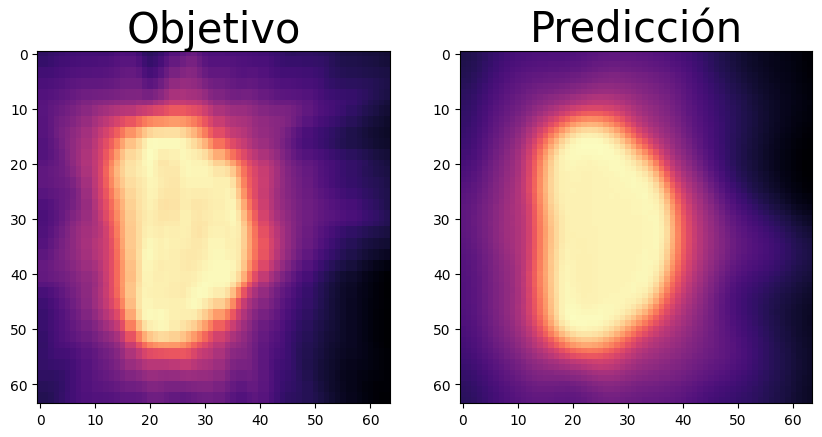

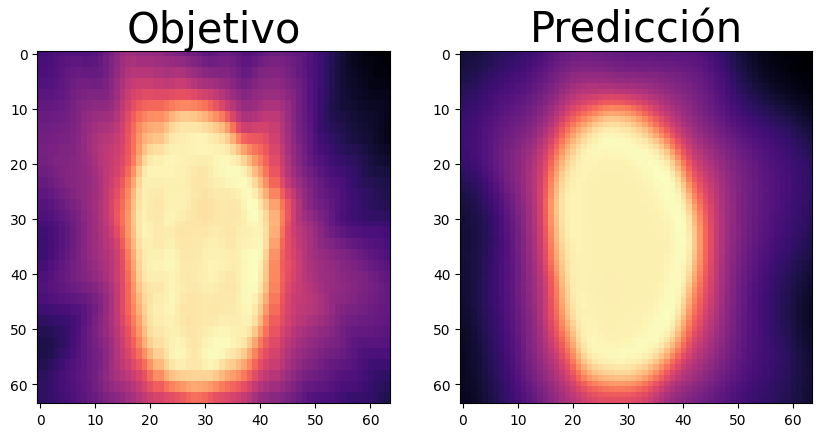

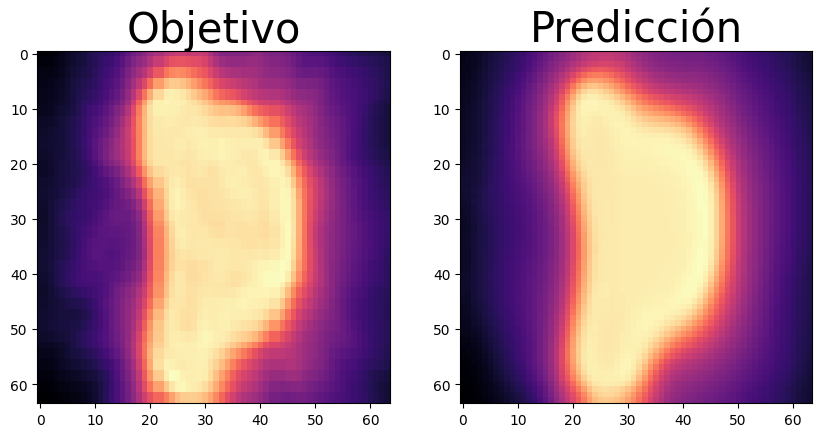

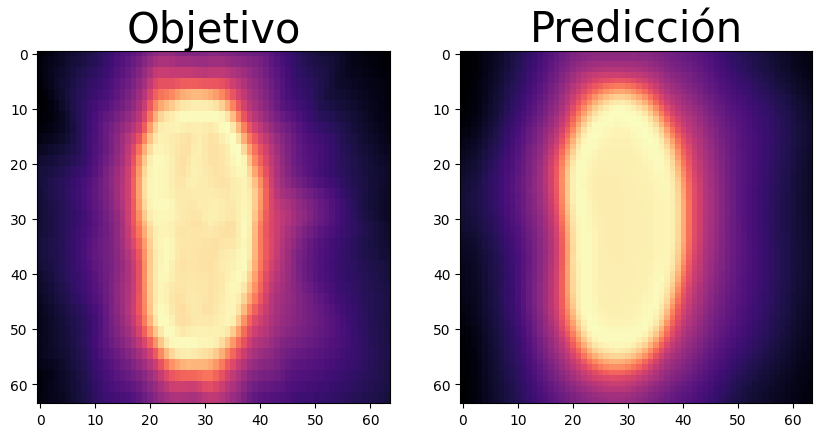

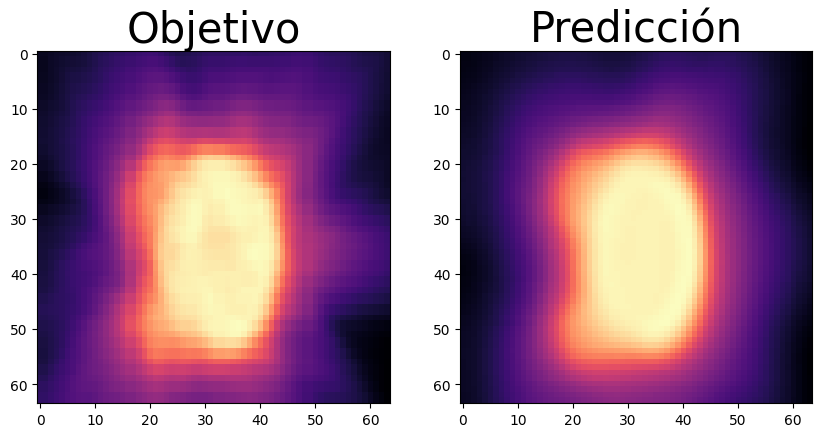

In [31]:
model.to(device)
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        pred_mask = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()

In [30]:
predecir("DatasetPI/TesteoPI/UM")

Carpetas cargadas
La carpeta Estructuras tiene 30 volúmenes y la carpeta Dosis tiene 30 máscaras
La cantidad de imágenes de testeo son 30.
pred_UM_dosis0 guardada en DatasetPI/TesteoPI/UM
pred_UM_dosis1 guardada en DatasetPI/TesteoPI/UM
pred_UM_dosis10 guardada en DatasetPI/TesteoPI/UM
pred_UM_dosis11 guardada en DatasetPI/TesteoPI/UM
pred_UM_dosis12 guardada en DatasetPI/TesteoPI/UM
pred_UM_dosis122 guardada en DatasetPI/TesteoPI/UM
pred_UM_dosis13 guardada en DatasetPI/TesteoPI/UM
pred_UM_dosis2 guardada en DatasetPI/TesteoPI/UM
pred_UM_dosis3 guardada en DatasetPI/TesteoPI/UM
pred_UM_dosis4 guardada en DatasetPI/TesteoPI/UM
pred_UM_dosis5 guardada en DatasetPI/TesteoPI/UM
pred_UM_dosis6 guardada en DatasetPI/TesteoPI/UM
pred_UM_dosis7 guardada en DatasetPI/TesteoPI/UM
pred_UM_dosis8 guardada en DatasetPI/TesteoPI/UM
pred_UM_dosis9 guardada en DatasetPI/TesteoPI/UM
pred_UM_flip_dosis0 guardada en DatasetPI/TesteoPI/UM
pred_UM_flip_dosis1 guardada en DatasetPI/TesteoPI/UM
pred_UM_flip

## ResU-Net

In [22]:
model = ResUNet()
model = model.to(device)
dataloader, dataset = traindata()

Carpetas cargadas
La carpeta Estructuras tiene 240 volúmenes y la carpeta Dosis tiene 240 máscaras
La cantidad de imágenes de entrenamiento son 180 y la cantidad de validación son 60.


In [23]:
hist, met = fit(model= model, device = device, epochs=500, loss_fn = torch.nn.MSELoss())


Epoch 1/500


val_loss: 0.02458, iou: 0.17223, dice: 0.29092: 100%|██████████| 30/30 [00:02<00:00, 12.29it/s]


El loss de validación mejoró de inf a 0.0246. Guardando checkpoint: file/checkpoint.pth

Epoch 2/500


val_loss: 0.02787, iou: 0.26006, dice: 0.40872: 100%|██████████| 30/30 [00:01<00:00, 22.39it/s]



Epoch 3/500


val_loss: 0.01082, iou: 0.39079, dice: 0.55421: 100%|██████████| 30/30 [00:01<00:00, 22.23it/s]


El loss de validación mejoró de 0.0246 a 0.0108. Guardando checkpoint: file/checkpoint.pth

Epoch 4/500


val_loss: 0.01157, iou: 0.35818, dice: 0.52023: 100%|██████████| 30/30 [00:01<00:00, 22.22it/s]



Epoch 5/500


val_loss: 0.00891, iou: 0.35663, dice: 0.52248: 100%|██████████| 30/30 [00:01<00:00, 22.21it/s]


El loss de validación mejoró de 0.0108 a 0.0089. Guardando checkpoint: file/checkpoint.pth

Epoch 6/500


val_loss: 0.00477, iou: 0.43698, dice: 0.60089: 100%|██████████| 30/30 [00:01<00:00, 22.38it/s]


El loss de validación mejoró de 0.0089 a 0.0048. Guardando checkpoint: file/checkpoint.pth

Epoch 7/500


val_loss: 0.00741, iou: 0.43817, dice: 0.60316: 100%|██████████| 30/30 [00:01<00:00, 22.58it/s]



Epoch 8/500


val_loss: 0.00649, iou: 0.48376, dice: 0.64448: 100%|██████████| 30/30 [00:01<00:00, 22.35it/s]



Epoch 9/500


val_loss: 0.00890, iou: 0.47544, dice: 0.63705: 100%|██████████| 30/30 [00:01<00:00, 22.44it/s]



Epoch 10/500


val_loss: 0.00472, iou: 0.45404, dice: 0.61817: 100%|██████████| 30/30 [00:01<00:00, 22.67it/s]


El loss de validación mejoró de 0.0048 a 0.0047. Guardando checkpoint: file/checkpoint.pth

Epoch 11/500


val_loss: 0.00493, iou: 0.46617, dice: 0.63033: 100%|██████████| 30/30 [00:01<00:00, 22.44it/s]



Epoch 12/500


val_loss: 0.00422, iou: 0.47924, dice: 0.64058: 100%|██████████| 30/30 [00:01<00:00, 22.38it/s]


El loss de validación mejoró de 0.0047 a 0.0042. Guardando checkpoint: file/checkpoint.pth

Epoch 13/500


val_loss: 0.00388, iou: 0.48267, dice: 0.64375: 100%|██████████| 30/30 [00:01<00:00, 22.55it/s]


El loss de validación mejoró de 0.0042 a 0.0039. Guardando checkpoint: file/checkpoint.pth

Epoch 14/500


val_loss: 0.00333, iou: 0.52616, dice: 0.68338: 100%|██████████| 30/30 [00:01<00:00, 22.47it/s]


El loss de validación mejoró de 0.0039 a 0.0033. Guardando checkpoint: file/checkpoint.pth

Epoch 15/500


val_loss: 0.00555, iou: 0.48161, dice: 0.64281: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]



Epoch 16/500


val_loss: 0.00393, iou: 0.49583, dice: 0.65530: 100%|██████████| 30/30 [00:01<00:00, 22.21it/s]



Epoch 17/500


val_loss: 0.00310, iou: 0.51189, dice: 0.67288: 100%|██████████| 30/30 [00:01<00:00, 22.64it/s]


El loss de validación mejoró de 0.0033 a 0.0031. Guardando checkpoint: file/checkpoint.pth

Epoch 18/500


val_loss: 0.00353, iou: 0.54249, dice: 0.69827: 100%|██████████| 30/30 [00:01<00:00, 22.49it/s]



Epoch 19/500


val_loss: 0.00239, iou: 0.55997, dice: 0.71288: 100%|██████████| 30/30 [00:01<00:00, 22.52it/s]


El loss de validación mejoró de 0.0031 a 0.0024. Guardando checkpoint: file/checkpoint.pth

Epoch 20/500


val_loss: 0.00344, iou: 0.54828, dice: 0.70208: 100%|██████████| 30/30 [00:01<00:00, 22.26it/s]



Epoch 21/500


val_loss: 0.00236, iou: 0.56268, dice: 0.71571: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]


El loss de validación mejoró de 0.0024 a 0.0024. Guardando checkpoint: file/checkpoint.pth

Epoch 22/500


val_loss: 0.00513, iou: 0.51808, dice: 0.67532: 100%|██████████| 30/30 [00:01<00:00, 22.44it/s]



Epoch 23/500


val_loss: 0.00581, iou: 0.47441, dice: 0.63659: 100%|██████████| 30/30 [00:01<00:00, 22.29it/s]



Epoch 24/500


val_loss: 0.00264, iou: 0.53547, dice: 0.69219: 100%|██████████| 30/30 [00:01<00:00, 22.50it/s]



Epoch 25/500


val_loss: 0.00248, iou: 0.54010, dice: 0.69826: 100%|██████████| 30/30 [00:01<00:00, 22.27it/s]



Epoch 26/500


val_loss: 0.00541, iou: 0.53227, dice: 0.68533: 100%|██████████| 30/30 [00:01<00:00, 22.29it/s]



Epoch 27/500


val_loss: 0.00283, iou: 0.56440, dice: 0.71540: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]



Epoch 28/500


val_loss: 0.00359, iou: 0.54350, dice: 0.69925: 100%|██████████| 30/30 [00:01<00:00, 22.31it/s]



Epoch 29/500


val_loss: 0.00649, iou: 0.50576, dice: 0.66623: 100%|██████████| 30/30 [00:01<00:00, 22.58it/s]



Epoch 30/500


val_loss: 0.00399, iou: 0.56268, dice: 0.71382: 100%|██████████| 30/30 [00:01<00:00, 22.59it/s]



Epoch 31/500


val_loss: 0.00409, iou: 0.56409, dice: 0.71518: 100%|██████████| 30/30 [00:01<00:00, 22.45it/s]



Epoch 32/500


val_loss: 0.00326, iou: 0.54105, dice: 0.69639: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]



Epoch 33/500


val_loss: 0.00373, iou: 0.57815, dice: 0.72591: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]



Epoch 34/500


val_loss: 0.00228, iou: 0.57733, dice: 0.72837: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]


El loss de validación mejoró de 0.0024 a 0.0023. Guardando checkpoint: file/checkpoint.pth

Epoch 35/500


val_loss: 0.00338, iou: 0.57260, dice: 0.72254: 100%|██████████| 30/30 [00:01<00:00, 22.13it/s]



Epoch 36/500


val_loss: 0.00335, iou: 0.57721, dice: 0.72674: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]



Epoch 37/500


val_loss: 0.00286, iou: 0.54054, dice: 0.69686: 100%|██████████| 30/30 [00:01<00:00, 21.99it/s]



Epoch 38/500


val_loss: 0.00267, iou: 0.57005, dice: 0.72080: 100%|██████████| 30/30 [00:01<00:00, 22.49it/s]



Epoch 39/500


val_loss: 0.00289, iou: 0.59530, dice: 0.74155: 100%|██████████| 30/30 [00:01<00:00, 22.30it/s]



Epoch 40/500


val_loss: 0.00481, iou: 0.51799, dice: 0.67485: 100%|██████████| 30/30 [00:01<00:00, 22.15it/s]



Epoch 41/500


val_loss: 0.00360, iou: 0.57929, dice: 0.72676: 100%|██████████| 30/30 [00:01<00:00, 22.44it/s]



Epoch 42/500


val_loss: 0.00546, iou: 0.53814, dice: 0.69249: 100%|██████████| 30/30 [00:01<00:00, 22.10it/s]



Epoch 43/500


val_loss: 0.00361, iou: 0.57250, dice: 0.72153: 100%|██████████| 30/30 [00:01<00:00, 22.48it/s]



Epoch 44/500


val_loss: 0.00502, iou: 0.51054, dice: 0.66949: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]



Epoch 45/500


val_loss: 0.00248, iou: 0.53827, dice: 0.69617: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]



Epoch 46/500


val_loss: 0.00205, iou: 0.58578, dice: 0.73570: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]


El loss de validación mejoró de 0.0023 a 0.0020. Guardando checkpoint: file/checkpoint.pth

Epoch 47/500


val_loss: 0.00244, iou: 0.58297, dice: 0.73137: 100%|██████████| 30/30 [00:01<00:00, 22.49it/s]



Epoch 48/500


val_loss: 0.00396, iou: 0.54995, dice: 0.70406: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]



Epoch 49/500


val_loss: 0.00277, iou: 0.57683, dice: 0.72792: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]



Epoch 50/500


val_loss: 0.00463, iou: 0.55157, dice: 0.70243: 100%|██████████| 30/30 [00:01<00:00, 22.63it/s]



Epoch 51/500


val_loss: 0.00337, iou: 0.53302, dice: 0.69099: 100%|██████████| 30/30 [00:01<00:00, 22.03it/s]



Epoch 52/500


val_loss: 0.00254, iou: 0.56334, dice: 0.71494: 100%|██████████| 30/30 [00:01<00:00, 22.57it/s]



Epoch 53/500


val_loss: 0.00244, iou: 0.59945, dice: 0.74524: 100%|██████████| 30/30 [00:01<00:00, 22.48it/s]



Epoch 54/500


val_loss: 0.00355, iou: 0.60062, dice: 0.74540: 100%|██████████| 30/30 [00:01<00:00, 22.65it/s]



Epoch 55/500


val_loss: 0.00309, iou: 0.60118, dice: 0.74599: 100%|██████████| 30/30 [00:01<00:00, 22.40it/s]



Epoch 56/500


val_loss: 0.00317, iou: 0.57616, dice: 0.72651: 100%|██████████| 30/30 [00:01<00:00, 22.51it/s]



Epoch 57/500


val_loss: 0.00451, iou: 0.57670, dice: 0.72706: 100%|██████████| 30/30 [00:01<00:00, 22.28it/s]



Epoch 58/500


val_loss: 0.00338, iou: 0.54007, dice: 0.69788: 100%|██████████| 30/30 [00:01<00:00, 22.45it/s]



Epoch 59/500


val_loss: 0.00240, iou: 0.58533, dice: 0.73421: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]



Epoch 60/500


val_loss: 0.00513, iou: 0.50477, dice: 0.66154: 100%|██████████| 30/30 [00:01<00:00, 22.36it/s]



Epoch 61/500


val_loss: 0.00339, iou: 0.56424, dice: 0.71656: 100%|██████████| 30/30 [00:01<00:00, 22.34it/s]



Epoch 62/500


val_loss: 0.00200, iou: 0.55716, dice: 0.71264: 100%|██████████| 30/30 [00:01<00:00, 22.39it/s]


El loss de validación mejoró de 0.0020 a 0.0020. Guardando checkpoint: file/checkpoint.pth

Epoch 63/500


val_loss: 0.00278, iou: 0.57347, dice: 0.72436: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 64/500


val_loss: 0.00244, iou: 0.55675, dice: 0.71204: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]



Epoch 65/500


val_loss: 0.00415, iou: 0.50726, dice: 0.66610: 100%|██████████| 30/30 [00:01<00:00, 22.40it/s]



Epoch 66/500


val_loss: 0.00234, iou: 0.57107, dice: 0.72306: 100%|██████████| 30/30 [00:01<00:00, 22.45it/s]



Epoch 67/500


val_loss: 0.00280, iou: 0.58425, dice: 0.73325: 100%|██████████| 30/30 [00:01<00:00, 22.57it/s]



Epoch 68/500


val_loss: 0.00328, iou: 0.58315, dice: 0.72960: 100%|██████████| 30/30 [00:01<00:00, 22.53it/s]



Epoch 69/500


val_loss: 0.00232, iou: 0.58392, dice: 0.73365: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]



Epoch 70/500


val_loss: 0.00340, iou: 0.58847, dice: 0.73569: 100%|██████████| 30/30 [00:01<00:00, 22.49it/s]



Epoch 71/500


val_loss: 0.00247, iou: 0.61298, dice: 0.75682: 100%|██████████| 30/30 [00:01<00:00, 22.56it/s]



Epoch 72/500


val_loss: 0.00426, iou: 0.58203, dice: 0.72953: 100%|██████████| 30/30 [00:01<00:00, 22.63it/s]



Epoch 73/500


val_loss: 0.00255, iou: 0.53400, dice: 0.69319: 100%|██████████| 30/30 [00:01<00:00, 22.31it/s]



Epoch 74/500


val_loss: 0.00270, iou: 0.50224, dice: 0.66639: 100%|██████████| 30/30 [00:01<00:00, 21.99it/s]



Epoch 75/500


val_loss: 0.00385, iou: 0.56146, dice: 0.71524: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 76/500


val_loss: 0.00295, iou: 0.52054, dice: 0.68118: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]



Epoch 77/500


val_loss: 0.02358, iou: 0.48781, dice: 0.64580: 100%|██████████| 30/30 [00:01<00:00, 22.30it/s]



Epoch 78/500


val_loss: 0.00276, iou: 0.56158, dice: 0.71549: 100%|██████████| 30/30 [00:01<00:00, 22.52it/s]



Epoch 79/500


val_loss: 0.00294, iou: 0.60888, dice: 0.75200: 100%|██████████| 30/30 [00:01<00:00, 22.31it/s]



Epoch 80/500


val_loss: 0.00341, iou: 0.59802, dice: 0.74373: 100%|██████████| 30/30 [00:01<00:00, 22.39it/s]



Epoch 81/500


val_loss: 0.00225, iou: 0.61031, dice: 0.75385: 100%|██████████| 30/30 [00:01<00:00, 22.34it/s]



Epoch 82/500


val_loss: 0.00202, iou: 0.59307, dice: 0.74192: 100%|██████████| 30/30 [00:01<00:00, 22.24it/s]



Epoch 83/500


val_loss: 0.00347, iou: 0.57776, dice: 0.72726: 100%|██████████| 30/30 [00:01<00:00, 22.24it/s]



Epoch 84/500


val_loss: 0.00431, iou: 0.57350, dice: 0.72323: 100%|██████████| 30/30 [00:01<00:00, 21.85it/s]



Epoch 85/500


val_loss: 0.00262, iou: 0.52692, dice: 0.68688: 100%|██████████| 30/30 [00:01<00:00, 22.28it/s]



Epoch 86/500


val_loss: 0.00192, iou: 0.59596, dice: 0.74302: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]


El loss de validación mejoró de 0.0020 a 0.0019. Guardando checkpoint: file/checkpoint.pth

Epoch 87/500


val_loss: 0.00189, iou: 0.54279, dice: 0.70132: 100%|██████████| 30/30 [00:01<00:00, 22.53it/s]


El loss de validación mejoró de 0.0019 a 0.0019. Guardando checkpoint: file/checkpoint.pth

Epoch 88/500


val_loss: 0.00177, iou: 0.60764, dice: 0.75406: 100%|██████████| 30/30 [00:01<00:00, 22.35it/s]


El loss de validación mejoró de 0.0019 a 0.0018. Guardando checkpoint: file/checkpoint.pth

Epoch 89/500


val_loss: 0.00237, iou: 0.51847, dice: 0.68006: 100%|██████████| 30/30 [00:01<00:00, 22.32it/s]



Epoch 90/500


val_loss: 0.00204, iou: 0.59315, dice: 0.74152: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 91/500


val_loss: 0.00225, iou: 0.58038, dice: 0.73120: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]



Epoch 92/500


val_loss: 0.00254, iou: 0.50453, dice: 0.66834: 100%|██████████| 30/30 [00:01<00:00, 22.29it/s]



Epoch 93/500


val_loss: 0.00206, iou: 0.60487, dice: 0.75033: 100%|██████████| 30/30 [00:01<00:00, 22.45it/s]



Epoch 94/500


val_loss: 0.00191, iou: 0.60215, dice: 0.74921: 100%|██████████| 30/30 [00:01<00:00, 22.36it/s]



Epoch 95/500


val_loss: 0.00206, iou: 0.56000, dice: 0.71567: 100%|██████████| 30/30 [00:01<00:00, 22.45it/s]



Epoch 96/500


val_loss: 0.00221, iou: 0.60037, dice: 0.74738: 100%|██████████| 30/30 [00:01<00:00, 22.25it/s]



Epoch 97/500


val_loss: 0.00192, iou: 0.60807, dice: 0.75356: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]



Epoch 98/500


val_loss: 0.00177, iou: 0.59750, dice: 0.74567: 100%|██████████| 30/30 [00:01<00:00, 22.57it/s]


El loss de validación mejoró de 0.0018 a 0.0018. Guardando checkpoint: file/checkpoint.pth

Epoch 99/500


val_loss: 0.00185, iou: 0.59515, dice: 0.74422: 100%|██████████| 30/30 [00:01<00:00, 22.55it/s]



Epoch 100/500


val_loss: 0.00212, iou: 0.53846, dice: 0.69751: 100%|██████████| 30/30 [00:01<00:00, 22.18it/s]



Epoch 101/500


val_loss: 0.00229, iou: 0.54820, dice: 0.70497: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]



Epoch 102/500


val_loss: 0.00199, iou: 0.61361, dice: 0.75702: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]



Epoch 103/500


val_loss: 0.00198, iou: 0.60581, dice: 0.75230: 100%|██████████| 30/30 [00:01<00:00, 22.59it/s]



Epoch 104/500


val_loss: 0.00214, iou: 0.53935, dice: 0.69835: 100%|██████████| 30/30 [00:01<00:00, 22.62it/s]



Epoch 105/500


val_loss: 0.00191, iou: 0.62311, dice: 0.76539: 100%|██████████| 30/30 [00:01<00:00, 22.28it/s]



Epoch 106/500


val_loss: 0.00220, iou: 0.55667, dice: 0.71260: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]



Epoch 107/500


val_loss: 0.00221, iou: 0.53921, dice: 0.69740: 100%|██████████| 30/30 [00:01<00:00, 22.21it/s]



Epoch 108/500


val_loss: 0.00194, iou: 0.62308, dice: 0.76457: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]



Epoch 109/500


val_loss: 0.00187, iou: 0.57867, dice: 0.73046: 100%|██████████| 30/30 [00:01<00:00, 21.56it/s]



Epoch 110/500


val_loss: 0.00229, iou: 0.49737, dice: 0.66234: 100%|██████████| 30/30 [00:01<00:00, 21.75it/s]



Epoch 111/500


val_loss: 0.00197, iou: 0.54922, dice: 0.70742: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]



Epoch 112/500


val_loss: 0.00225, iou: 0.56072, dice: 0.71576: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]



Epoch 113/500


val_loss: 0.00266, iou: 0.55084, dice: 0.70677: 100%|██████████| 30/30 [00:01<00:00, 22.49it/s]



Epoch 114/500


val_loss: 0.00283, iou: 0.55549, dice: 0.71124: 100%|██████████| 30/30 [00:01<00:00, 22.50it/s]



Epoch 115/500


val_loss: 0.00250, iou: 0.57768, dice: 0.72872: 100%|██████████| 30/30 [00:01<00:00, 22.51it/s]



Epoch 116/500


val_loss: 0.00205, iou: 0.58728, dice: 0.73790: 100%|██████████| 30/30 [00:01<00:00, 22.47it/s]



Epoch 117/500


val_loss: 0.00180, iou: 0.58694, dice: 0.73730: 100%|██████████| 30/30 [00:01<00:00, 22.56it/s]



Epoch 118/500


val_loss: 0.00180, iou: 0.57001, dice: 0.72374: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]



Epoch 119/500


val_loss: 0.00193, iou: 0.57379, dice: 0.72713: 100%|██████████| 30/30 [00:01<00:00, 22.63it/s]



Epoch 120/500


val_loss: 0.00244, iou: 0.59163, dice: 0.74013: 100%|██████████| 30/30 [00:01<00:00, 22.20it/s]



Epoch 121/500


val_loss: 0.00255, iou: 0.55637, dice: 0.71232: 100%|██████████| 30/30 [00:01<00:00, 22.50it/s]



Epoch 122/500


val_loss: 0.00222, iou: 0.50625, dice: 0.67027: 100%|██████████| 30/30 [00:01<00:00, 22.48it/s]



Epoch 123/500


val_loss: 0.00269, iou: 0.57983, dice: 0.73055: 100%|██████████| 30/30 [00:01<00:00, 22.53it/s]



Epoch 124/500


val_loss: 0.00199, iou: 0.48857, dice: 0.65482: 100%|██████████| 30/30 [00:01<00:00, 22.20it/s]



Epoch 125/500


val_loss: 0.00260, iou: 0.62720, dice: 0.76699: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]



Epoch 126/500


val_loss: 0.00161, iou: 0.61052, dice: 0.75664: 100%|██████████| 30/30 [00:01<00:00, 22.53it/s]


El loss de validación mejoró de 0.0018 a 0.0016. Guardando checkpoint: file/checkpoint.pth

Epoch 127/500


val_loss: 0.00214, iou: 0.50035, dice: 0.66496: 100%|██████████| 30/30 [00:01<00:00, 22.22it/s]



Epoch 128/500


val_loss: 0.00213, iou: 0.57707, dice: 0.72954: 100%|██████████| 30/30 [00:01<00:00, 21.86it/s]



Epoch 129/500


val_loss: 0.00215, iou: 0.48940, dice: 0.65523: 100%|██████████| 30/30 [00:01<00:00, 22.71it/s]



Epoch 130/500


val_loss: 0.00277, iou: 0.53222, dice: 0.69093: 100%|██████████| 30/30 [00:01<00:00, 22.24it/s]



Epoch 131/500


val_loss: 0.00236, iou: 0.48450, dice: 0.65056: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]



Epoch 132/500


val_loss: 0.00221, iou: 0.50815, dice: 0.67163: 100%|██████████| 30/30 [00:01<00:00, 22.02it/s]



Epoch 133/500


val_loss: 0.00394, iou: 0.52571, dice: 0.68517: 100%|██████████| 30/30 [00:01<00:00, 22.44it/s]



Epoch 134/500


val_loss: 0.00284, iou: 0.54519, dice: 0.70226: 100%|██████████| 30/30 [00:01<00:00, 22.16it/s]



Epoch 135/500


val_loss: 0.00181, iou: 0.61479, dice: 0.75909: 100%|██████████| 30/30 [00:01<00:00, 22.72it/s]



Epoch 136/500


val_loss: 0.00247, iou: 0.61799, dice: 0.76015: 100%|██████████| 30/30 [00:01<00:00, 22.47it/s]



Epoch 137/500


val_loss: 0.00272, iou: 0.46129, dice: 0.62870: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]



Epoch 138/500


val_loss: 0.00338, iou: 0.58859, dice: 0.73560: 100%|██████████| 30/30 [00:01<00:00, 22.22it/s]



Epoch 139/500


val_loss: 0.00304, iou: 0.52084, dice: 0.68183: 100%|██████████| 30/30 [00:01<00:00, 22.54it/s]



Epoch 140/500


val_loss: 0.00209, iou: 0.61606, dice: 0.75925: 100%|██████████| 30/30 [00:01<00:00, 22.45it/s]



Epoch 141/500


val_loss: 0.00225, iou: 0.57380, dice: 0.72700: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]



Epoch 142/500


val_loss: 0.00257, iou: 0.49834, dice: 0.66263: 100%|██████████| 30/30 [00:01<00:00, 22.29it/s]



Epoch 143/500


val_loss: 0.00289, iou: 0.59499, dice: 0.74235: 100%|██████████| 30/30 [00:01<00:00, 22.49it/s]



Epoch 144/500


val_loss: 0.00279, iou: 0.55916, dice: 0.71450: 100%|██████████| 30/30 [00:01<00:00, 22.25it/s]



Epoch 145/500


val_loss: 0.00514, iou: 0.56761, dice: 0.71987: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]



Epoch 146/500


val_loss: 0.00299, iou: 0.60267, dice: 0.74865: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 147/500


val_loss: 0.00233, iou: 0.56054, dice: 0.71598: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]



Epoch 148/500


val_loss: 0.00285, iou: 0.52628, dice: 0.68688: 100%|██████████| 30/30 [00:01<00:00, 22.31it/s]



Epoch 149/500


val_loss: 0.00187, iou: 0.60125, dice: 0.74855: 100%|██████████| 30/30 [00:01<00:00, 22.34it/s]



Epoch 150/500


val_loss: 0.00217, iou: 0.57785, dice: 0.73007: 100%|██████████| 30/30 [00:01<00:00, 22.32it/s]



Epoch 151/500


val_loss: 0.00247, iou: 0.49786, dice: 0.66201: 100%|██████████| 30/30 [00:01<00:00, 22.29it/s]



Epoch 152/500


val_loss: 0.00261, iou: 0.61837, dice: 0.76130: 100%|██████████| 30/30 [00:01<00:00, 22.63it/s]



Epoch 153/500


val_loss: 0.00211, iou: 0.48017, dice: 0.64718: 100%|██████████| 30/30 [00:01<00:00, 22.15it/s]



Epoch 154/500


val_loss: 0.00277, iou: 0.41291, dice: 0.58291: 100%|██████████| 30/30 [00:01<00:00, 22.49it/s]



Epoch 155/500


val_loss: 0.00247, iou: 0.62077, dice: 0.76238: 100%|██████████| 30/30 [00:01<00:00, 22.29it/s]



Epoch 156/500


val_loss: 0.00195, iou: 0.57029, dice: 0.72387: 100%|██████████| 30/30 [00:01<00:00, 22.48it/s]



Epoch 157/500


val_loss: 0.00184, iou: 0.63039, dice: 0.77047: 100%|██████████| 30/30 [00:01<00:00, 22.65it/s]



Epoch 158/500


val_loss: 0.00190, iou: 0.61810, dice: 0.76104: 100%|██████████| 30/30 [00:01<00:00, 22.17it/s]



Epoch 159/500


val_loss: 0.00169, iou: 0.59884, dice: 0.74736: 100%|██████████| 30/30 [00:01<00:00, 22.51it/s]



Epoch 160/500


val_loss: 0.00311, iou: 0.58284, dice: 0.73309: 100%|██████████| 30/30 [00:01<00:00, 22.01it/s]



Epoch 161/500


val_loss: 0.00210, iou: 0.52965, dice: 0.69023: 100%|██████████| 30/30 [00:01<00:00, 22.32it/s]



Epoch 162/500


val_loss: 0.00604, iou: 0.47646, dice: 0.63994: 100%|██████████| 30/30 [00:01<00:00, 22.09it/s]



Epoch 163/500


val_loss: 0.00218, iou: 0.58098, dice: 0.73210: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]



Epoch 164/500


val_loss: 0.00186, iou: 0.63030, dice: 0.77038: 100%|██████████| 30/30 [00:01<00:00, 22.03it/s]



Epoch 165/500


val_loss: 0.00189, iou: 0.59967, dice: 0.74756: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]



Epoch 166/500


val_loss: 0.00214, iou: 0.50640, dice: 0.66995: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 167/500


val_loss: 0.00215, iou: 0.59141, dice: 0.74050: 100%|██████████| 30/30 [00:01<00:00, 22.32it/s]



Epoch 168/500


val_loss: 0.00299, iou: 0.55675, dice: 0.71184: 100%|██████████| 30/30 [00:01<00:00, 22.28it/s]



Epoch 169/500


val_loss: 0.00329, iou: 0.58547, dice: 0.73479: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]



Epoch 170/500


val_loss: 0.00191, iou: 0.59156, dice: 0.74136: 100%|██████████| 30/30 [00:01<00:00, 22.56it/s]



Epoch 171/500


val_loss: 0.00260, iou: 0.54573, dice: 0.70342: 100%|██████████| 30/30 [00:01<00:00, 22.55it/s]



Epoch 172/500


val_loss: 0.00263, iou: 0.60334, dice: 0.74862: 100%|██████████| 30/30 [00:01<00:00, 22.50it/s]



Epoch 173/500


val_loss: 0.00221, iou: 0.54525, dice: 0.70350: 100%|██████████| 30/30 [00:01<00:00, 22.24it/s]



Epoch 174/500


val_loss: 0.00182, iou: 0.58226, dice: 0.73412: 100%|██████████| 30/30 [00:01<00:00, 22.58it/s]



Epoch 175/500


val_loss: 0.00203, iou: 0.56940, dice: 0.72333: 100%|██████████| 30/30 [00:01<00:00, 22.17it/s]



Epoch 176/500


val_loss: 0.00172, iou: 0.61140, dice: 0.75647: 100%|██████████| 30/30 [00:01<00:00, 22.38it/s]



Epoch 177/500


val_loss: 0.00324, iou: 0.56106, dice: 0.71574: 100%|██████████| 30/30 [00:01<00:00, 22.14it/s]



Epoch 178/500


val_loss: 0.00324, iou: 0.53082, dice: 0.68981: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]



Epoch 179/500


val_loss: 0.00339, iou: 0.55053, dice: 0.70731: 100%|██████████| 30/30 [00:01<00:00, 22.09it/s]



Epoch 180/500


val_loss: 0.00386, iou: 0.58664, dice: 0.73606: 100%|██████████| 30/30 [00:01<00:00, 22.29it/s]



Epoch 181/500


val_loss: 0.00240, iou: 0.58990, dice: 0.73960: 100%|██████████| 30/30 [00:01<00:00, 22.18it/s]



Epoch 182/500


val_loss: 0.00345, iou: 0.53724, dice: 0.69559: 100%|██████████| 30/30 [00:01<00:00, 22.05it/s]



Epoch 183/500


val_loss: 0.00273, iou: 0.63081, dice: 0.77024: 100%|██████████| 30/30 [00:01<00:00, 22.28it/s]



Epoch 184/500


val_loss: 0.00291, iou: 0.48722, dice: 0.65222: 100%|██████████| 30/30 [00:01<00:00, 22.27it/s]



Epoch 185/500


val_loss: 0.00415, iou: 0.56371, dice: 0.71758: 100%|██████████| 30/30 [00:01<00:00, 22.30it/s]



Epoch 186/500


val_loss: 0.00371, iou: 0.49341, dice: 0.65794: 100%|██████████| 30/30 [00:01<00:00, 22.00it/s]



Epoch 187/500


val_loss: 0.00467, iou: 0.49255, dice: 0.65633: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]



Epoch 188/500


val_loss: 0.00247, iou: 0.54080, dice: 0.69938: 100%|██████████| 30/30 [00:01<00:00, 22.13it/s]



Epoch 189/500


val_loss: 0.00201, iou: 0.49505, dice: 0.66092: 100%|██████████| 30/30 [00:01<00:00, 22.53it/s]



Epoch 190/500


val_loss: 0.00405, iou: 0.55454, dice: 0.71022: 100%|██████████| 30/30 [00:01<00:00, 22.23it/s]



Epoch 191/500


val_loss: 0.00281, iou: 0.57260, dice: 0.72539: 100%|██████████| 30/30 [00:01<00:00, 22.40it/s]



Epoch 192/500


val_loss: 0.00262, iou: 0.45293, dice: 0.62105: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]



Epoch 193/500


val_loss: 0.00244, iou: 0.61964, dice: 0.76183: 100%|██████████| 30/30 [00:01<00:00, 22.26it/s]



Epoch 194/500


val_loss: 0.00265, iou: 0.52185, dice: 0.68320: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]



Epoch 195/500


val_loss: 0.00190, iou: 0.56230, dice: 0.71787: 100%|██████████| 30/30 [00:01<00:00, 22.25it/s]



Epoch 196/500


val_loss: 0.00200, iou: 0.57023, dice: 0.72387: 100%|██████████| 30/30 [00:01<00:00, 22.35it/s]



Epoch 197/500


val_loss: 0.00292, iou: 0.59840, dice: 0.74446: 100%|██████████| 30/30 [00:01<00:00, 22.09it/s]



Epoch 198/500


val_loss: 0.00309, iou: 0.60222, dice: 0.74881: 100%|██████████| 30/30 [00:01<00:00, 22.51it/s]



Epoch 199/500


val_loss: 0.00226, iou: 0.60213, dice: 0.74955: 100%|██████████| 30/30 [00:01<00:00, 22.01it/s]



Epoch 200/500


val_loss: 0.00421, iou: 0.61901, dice: 0.76006: 100%|██████████| 30/30 [00:01<00:00, 22.77it/s]



Epoch 201/500


val_loss: 0.00314, iou: 0.59764, dice: 0.74495: 100%|██████████| 30/30 [00:01<00:00, 22.29it/s]



Epoch 202/500


val_loss: 0.00207, iou: 0.59398, dice: 0.74285: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]



Epoch 203/500


val_loss: 0.00324, iou: 0.56339, dice: 0.71795: 100%|██████████| 30/30 [00:01<00:00, 22.25it/s]



Epoch 204/500


val_loss: 0.00219, iou: 0.57242, dice: 0.72623: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]



Epoch 205/500


val_loss: 0.00327, iou: 0.60353, dice: 0.74935: 100%|██████████| 30/30 [00:01<00:00, 22.39it/s]



Epoch 206/500


val_loss: 0.00189, iou: 0.58288, dice: 0.73453: 100%|██████████| 30/30 [00:01<00:00, 22.40it/s]



Epoch 207/500


val_loss: 0.00235, iou: 0.63220, dice: 0.77144: 100%|██████████| 30/30 [00:01<00:00, 22.19it/s]



Epoch 208/500


val_loss: 0.00305, iou: 0.53071, dice: 0.68979: 100%|██████████| 30/30 [00:01<00:00, 22.54it/s]



Epoch 209/500


val_loss: 0.00196, iou: 0.57581, dice: 0.72821: 100%|██████████| 30/30 [00:01<00:00, 22.28it/s]



Epoch 210/500


val_loss: 0.00257, iou: 0.57746, dice: 0.72883: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]



Epoch 211/500


val_loss: 0.00221, iou: 0.55562, dice: 0.71271: 100%|██████████| 30/30 [00:01<00:00, 22.44it/s]



Epoch 212/500


val_loss: 0.00218, iou: 0.54985, dice: 0.70735: 100%|██████████| 30/30 [00:01<00:00, 22.24it/s]



Epoch 213/500


val_loss: 0.00205, iou: 0.58877, dice: 0.73856: 100%|██████████| 30/30 [00:01<00:00, 22.35it/s]



Epoch 214/500


val_loss: 0.00209, iou: 0.59531, dice: 0.74389: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]



Epoch 215/500


val_loss: 0.00242, iou: 0.59897, dice: 0.74670: 100%|██████████| 30/30 [00:01<00:00, 22.39it/s]



Epoch 216/500


val_loss: 0.00451, iou: 0.59923, dice: 0.74450: 100%|██████████| 30/30 [00:01<00:00, 22.49it/s]



Epoch 217/500


val_loss: 0.00223, iou: 0.63649, dice: 0.77511: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]



Epoch 218/500


val_loss: 0.00301, iou: 0.55615, dice: 0.71165: 100%|██████████| 30/30 [00:01<00:00, 22.30it/s]



Epoch 219/500


val_loss: 0.00385, iou: 0.53574, dice: 0.69483: 100%|██████████| 30/30 [00:01<00:00, 22.34it/s]



Epoch 220/500


val_loss: 0.00219, iou: 0.62399, dice: 0.76550: 100%|██████████| 30/30 [00:01<00:00, 22.13it/s]



Epoch 221/500


val_loss: 0.00292, iou: 0.59403, dice: 0.74184: 100%|██████████| 30/30 [00:01<00:00, 22.25it/s]



Epoch 222/500


val_loss: 0.00165, iou: 0.58734, dice: 0.73848: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]



Epoch 223/500


val_loss: 0.00387, iou: 0.60374, dice: 0.74913: 100%|██████████| 30/30 [00:01<00:00, 22.20it/s]



Epoch 224/500


val_loss: 0.00277, iou: 0.57657, dice: 0.72834: 100%|██████████| 30/30 [00:01<00:00, 22.53it/s]



Epoch 225/500


val_loss: 0.00240, iou: 0.50546, dice: 0.66860: 100%|██████████| 30/30 [00:01<00:00, 22.34it/s]



Epoch 226/500


val_loss: 0.00288, iou: 0.58921, dice: 0.73764: 100%|██████████| 30/30 [00:01<00:00, 22.62it/s]



Epoch 227/500


val_loss: 0.00256, iou: 0.59091, dice: 0.73963: 100%|██████████| 30/30 [00:01<00:00, 21.80it/s]



Epoch 228/500


val_loss: 0.00196, iou: 0.62187, dice: 0.76392: 100%|██████████| 30/30 [00:01<00:00, 22.55it/s]



Epoch 229/500


val_loss: 0.00200, iou: 0.58697, dice: 0.73781: 100%|██████████| 30/30 [00:01<00:00, 22.40it/s]



Epoch 230/500


val_loss: 0.00238, iou: 0.59402, dice: 0.74253: 100%|██████████| 30/30 [00:01<00:00, 22.34it/s]



Epoch 231/500


val_loss: 0.00212, iou: 0.59012, dice: 0.74013: 100%|██████████| 30/30 [00:01<00:00, 22.59it/s]



Epoch 232/500


val_loss: 0.00187, iou: 0.63274, dice: 0.77262: 100%|██████████| 30/30 [00:01<00:00, 22.39it/s]



Epoch 233/500


val_loss: 0.00250, iou: 0.56368, dice: 0.71837: 100%|██████████| 30/30 [00:01<00:00, 21.96it/s]



Epoch 234/500


val_loss: 0.00228, iou: 0.61735, dice: 0.76044: 100%|██████████| 30/30 [00:01<00:00, 22.32it/s]



Epoch 235/500


val_loss: 0.00231, iou: 0.61770, dice: 0.76090: 100%|██████████| 30/30 [00:01<00:00, 22.27it/s]



Epoch 236/500


val_loss: 0.00217, iou: 0.63556, dice: 0.77414: 100%|██████████| 30/30 [00:01<00:00, 22.32it/s]



Epoch 237/500


val_loss: 0.00374, iou: 0.53412, dice: 0.69268: 100%|██████████| 30/30 [00:01<00:00, 22.26it/s]



Epoch 238/500


val_loss: 0.00201, iou: 0.58555, dice: 0.73596: 100%|██████████| 30/30 [00:01<00:00, 22.54it/s]



Epoch 239/500


val_loss: 0.00182, iou: 0.61040, dice: 0.75623: 100%|██████████| 30/30 [00:01<00:00, 22.21it/s]



Epoch 240/500


val_loss: 0.00178, iou: 0.61504, dice: 0.75980: 100%|██████████| 30/30 [00:01<00:00, 22.13it/s]



Epoch 241/500


val_loss: 0.00164, iou: 0.63670, dice: 0.77547: 100%|██████████| 30/30 [00:01<00:00, 22.28it/s]



Epoch 242/500


val_loss: 0.00297, iou: 0.57072, dice: 0.72395: 100%|██████████| 30/30 [00:01<00:00, 22.27it/s]



Epoch 243/500


val_loss: 0.00234, iou: 0.58006, dice: 0.73172: 100%|██████████| 30/30 [00:01<00:00, 22.36it/s]



Epoch 244/500


val_loss: 0.00212, iou: 0.57661, dice: 0.72892: 100%|██████████| 30/30 [00:01<00:00, 21.95it/s]



Epoch 245/500


val_loss: 0.00216, iou: 0.56158, dice: 0.71704: 100%|██████████| 30/30 [00:01<00:00, 22.23it/s]



Epoch 246/500


val_loss: 0.00175, iou: 0.53146, dice: 0.69238: 100%|██████████| 30/30 [00:01<00:00, 22.28it/s]



Epoch 247/500


val_loss: 0.00267, iou: 0.61007, dice: 0.75455: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]



Epoch 248/500


val_loss: 0.00227, iou: 0.62187, dice: 0.76392: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]



Epoch 249/500


val_loss: 0.00322, iou: 0.63289, dice: 0.77138: 100%|██████████| 30/30 [00:01<00:00, 22.64it/s]



Epoch 250/500


val_loss: 0.00212, iou: 0.57722, dice: 0.72942: 100%|██████████| 30/30 [00:01<00:00, 22.26it/s]



Epoch 251/500


val_loss: 0.00200, iou: 0.55771, dice: 0.71446: 100%|██████████| 30/30 [00:01<00:00, 22.07it/s]



Epoch 252/500


val_loss: 0.00174, iou: 0.57994, dice: 0.73215: 100%|██████████| 30/30 [00:01<00:00, 22.22it/s]



Epoch 253/500


val_loss: 0.00157, iou: 0.64135, dice: 0.77932: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]


El loss de validación mejoró de 0.0016 a 0.0016. Guardando checkpoint: file/checkpoint.pth

Epoch 254/500


val_loss: 0.00205, iou: 0.59747, dice: 0.74571: 100%|██████████| 30/30 [00:01<00:00, 22.26it/s]



Epoch 255/500


val_loss: 0.00196, iou: 0.57854, dice: 0.73106: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]



Epoch 256/500


val_loss: 0.00230, iou: 0.61544, dice: 0.75935: 100%|██████████| 30/30 [00:01<00:00, 22.45it/s]



Epoch 257/500


val_loss: 0.00165, iou: 0.63547, dice: 0.77496: 100%|██████████| 30/30 [00:01<00:00, 22.09it/s]



Epoch 258/500


val_loss: 0.00242, iou: 0.59360, dice: 0.74190: 100%|██████████| 30/30 [00:01<00:00, 22.59it/s]



Epoch 259/500


val_loss: 0.00182, iou: 0.63100, dice: 0.77103: 100%|██████████| 30/30 [00:01<00:00, 22.31it/s]



Epoch 260/500


val_loss: 0.00191, iou: 0.59973, dice: 0.74743: 100%|██████████| 30/30 [00:01<00:00, 22.26it/s]



Epoch 261/500


val_loss: 0.00159, iou: 0.59424, dice: 0.74395: 100%|██████████| 30/30 [00:01<00:00, 22.49it/s]



Epoch 262/500


val_loss: 0.00194, iou: 0.62505, dice: 0.76672: 100%|██████████| 30/30 [00:01<00:00, 22.24it/s]



Epoch 263/500


val_loss: 0.00151, iou: 0.61950, dice: 0.76333: 100%|██████████| 30/30 [00:01<00:00, 22.29it/s]


El loss de validación mejoró de 0.0016 a 0.0015. Guardando checkpoint: file/checkpoint.pth

Epoch 264/500


val_loss: 0.00153, iou: 0.62878, dice: 0.77028: 100%|██████████| 30/30 [00:01<00:00, 22.39it/s]



Epoch 265/500


val_loss: 0.00267, iou: 0.58182, dice: 0.73271: 100%|██████████| 30/30 [00:01<00:00, 22.14it/s]



Epoch 266/500


val_loss: 0.00292, iou: 0.55459, dice: 0.71068: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]



Epoch 267/500


val_loss: 0.00363, iou: 0.48517, dice: 0.65049: 100%|██████████| 30/30 [00:01<00:00, 22.38it/s]



Epoch 268/500


val_loss: 0.00187, iou: 0.60392, dice: 0.75104: 100%|██████████| 30/30 [00:01<00:00, 22.18it/s]



Epoch 269/500


val_loss: 0.00171, iou: 0.64170, dice: 0.77926: 100%|██████████| 30/30 [00:01<00:00, 22.38it/s]



Epoch 270/500


val_loss: 0.00240, iou: 0.63863, dice: 0.77617: 100%|██████████| 30/30 [00:01<00:00, 22.16it/s]



Epoch 271/500


val_loss: 0.00200, iou: 0.58496, dice: 0.73549: 100%|██████████| 30/30 [00:01<00:00, 22.39it/s]



Epoch 272/500


val_loss: 0.00160, iou: 0.63583, dice: 0.77540: 100%|██████████| 30/30 [00:01<00:00, 22.39it/s]



Epoch 273/500


val_loss: 0.00209, iou: 0.62811, dice: 0.76877: 100%|██████████| 30/30 [00:01<00:00, 22.59it/s]



Epoch 274/500


val_loss: 0.00261, iou: 0.60308, dice: 0.74964: 100%|██████████| 30/30 [00:01<00:00, 22.20it/s]



Epoch 275/500


val_loss: 0.00220, iou: 0.60779, dice: 0.75361: 100%|██████████| 30/30 [00:01<00:00, 22.55it/s]



Epoch 276/500


val_loss: 0.00219, iou: 0.65025, dice: 0.78502: 100%|██████████| 30/30 [00:01<00:00, 22.21it/s]



Epoch 277/500


val_loss: 0.00221, iou: 0.63667, dice: 0.77533: 100%|██████████| 30/30 [00:01<00:00, 22.40it/s]



Epoch 278/500


val_loss: 0.00190, iou: 0.56850, dice: 0.72307: 100%|██████████| 30/30 [00:01<00:00, 22.35it/s]



Epoch 279/500


val_loss: 0.00200, iou: 0.62165, dice: 0.76412: 100%|██████████| 30/30 [00:01<00:00, 22.27it/s]



Epoch 280/500


val_loss: 0.00224, iou: 0.61102, dice: 0.75587: 100%|██████████| 30/30 [00:01<00:00, 22.38it/s]



Epoch 281/500


val_loss: 0.00163, iou: 0.63144, dice: 0.77201: 100%|██████████| 30/30 [00:01<00:00, 22.25it/s]



Epoch 282/500


val_loss: 0.00179, iou: 0.60793, dice: 0.75378: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 283/500


val_loss: 0.00220, iou: 0.63568, dice: 0.77470: 100%|██████████| 30/30 [00:01<00:00, 21.75it/s]



Epoch 284/500


val_loss: 0.00220, iou: 0.58993, dice: 0.73996: 100%|██████████| 30/30 [00:01<00:00, 22.66it/s]



Epoch 285/500


val_loss: 0.00313, iou: 0.52069, dice: 0.68247: 100%|██████████| 30/30 [00:01<00:00, 22.32it/s]



Epoch 286/500


val_loss: 0.00260, iou: 0.62917, dice: 0.76889: 100%|██████████| 30/30 [00:01<00:00, 22.36it/s]



Epoch 287/500


val_loss: 0.00168, iou: 0.63652, dice: 0.77526: 100%|██████████| 30/30 [00:01<00:00, 22.56it/s]



Epoch 288/500


val_loss: 0.00202, iou: 0.61584, dice: 0.75981: 100%|██████████| 30/30 [00:01<00:00, 22.17it/s]



Epoch 289/500


val_loss: 0.00245, iou: 0.50610, dice: 0.66939: 100%|██████████| 30/30 [00:01<00:00, 22.16it/s]



Epoch 290/500


val_loss: 0.00180, iou: 0.62654, dice: 0.76786: 100%|██████████| 30/30 [00:01<00:00, 22.35it/s]



Epoch 291/500


val_loss: 0.00195, iou: 0.63379, dice: 0.77297: 100%|██████████| 30/30 [00:01<00:00, 22.20it/s]



Epoch 292/500


val_loss: 0.00201, iou: 0.58518, dice: 0.73580: 100%|██████████| 30/30 [00:01<00:00, 22.31it/s]



Epoch 293/500


val_loss: 0.00250, iou: 0.60531, dice: 0.75142: 100%|██████████| 30/30 [00:01<00:00, 22.38it/s]



Epoch 294/500


val_loss: 0.00169, iou: 0.62564, dice: 0.76746: 100%|██████████| 30/30 [00:01<00:00, 22.11it/s]



Epoch 295/500


val_loss: 0.00201, iou: 0.64369, dice: 0.78090: 100%|██████████| 30/30 [00:01<00:00, 22.38it/s]



Epoch 296/500


val_loss: 0.00244, iou: 0.62624, dice: 0.76701: 100%|██████████| 30/30 [00:01<00:00, 22.53it/s]



Epoch 297/500


val_loss: 0.00181, iou: 0.60481, dice: 0.75190: 100%|██████████| 30/30 [00:01<00:00, 22.53it/s]



Epoch 298/500


val_loss: 0.00227, iou: 0.59955, dice: 0.74709: 100%|██████████| 30/30 [00:01<00:00, 22.12it/s]



Epoch 299/500


val_loss: 0.00214, iou: 0.61445, dice: 0.75839: 100%|██████████| 30/30 [00:01<00:00, 22.51it/s]



Epoch 300/500


val_loss: 0.00240, iou: 0.58194, dice: 0.73329: 100%|██████████| 30/30 [00:01<00:00, 22.24it/s]



Epoch 301/500


val_loss: 0.00181, iou: 0.64221, dice: 0.77952: 100%|██████████| 30/30 [00:01<00:00, 22.53it/s]



Epoch 302/500


val_loss: 0.00191, iou: 0.63042, dice: 0.77102: 100%|██████████| 30/30 [00:01<00:00, 22.16it/s]



Epoch 303/500


val_loss: 0.00143, iou: 0.62478, dice: 0.76742: 100%|██████████| 30/30 [00:01<00:00, 22.40it/s]


El loss de validación mejoró de 0.0015 a 0.0014. Guardando checkpoint: file/checkpoint.pth

Epoch 304/500


val_loss: 0.00284, iou: 0.59136, dice: 0.74010: 100%|██████████| 30/30 [00:01<00:00, 22.45it/s]



Epoch 305/500


val_loss: 0.00207, iou: 0.63742, dice: 0.77525: 100%|██████████| 30/30 [00:01<00:00, 22.14it/s]



Epoch 306/500


val_loss: 0.00174, iou: 0.62055, dice: 0.76364: 100%|██████████| 30/30 [00:01<00:00, 22.50it/s]



Epoch 307/500


val_loss: 0.00144, iou: 0.60738, dice: 0.75406: 100%|██████████| 30/30 [00:01<00:00, 22.26it/s]



Epoch 308/500


val_loss: 0.00201, iou: 0.62874, dice: 0.76881: 100%|██████████| 30/30 [00:01<00:00, 22.05it/s]



Epoch 309/500


val_loss: 0.00191, iou: 0.58105, dice: 0.73279: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 310/500


val_loss: 0.00184, iou: 0.61607, dice: 0.76036: 100%|██████████| 30/30 [00:01<00:00, 22.56it/s]



Epoch 311/500


val_loss: 0.00210, iou: 0.47076, dice: 0.63865: 100%|██████████| 30/30 [00:01<00:00, 22.60it/s]



Epoch 312/500


val_loss: 0.00202, iou: 0.62793, dice: 0.76858: 100%|██████████| 30/30 [00:01<00:00, 21.62it/s]



Epoch 313/500


val_loss: 0.00222, iou: 0.58802, dice: 0.73801: 100%|██████████| 30/30 [00:01<00:00, 22.48it/s]



Epoch 314/500


val_loss: 0.00182, iou: 0.62880, dice: 0.76979: 100%|██████████| 30/30 [00:01<00:00, 21.98it/s]



Epoch 315/500


val_loss: 0.00192, iou: 0.63776, dice: 0.77665: 100%|██████████| 30/30 [00:01<00:00, 22.22it/s]



Epoch 316/500


val_loss: 0.00157, iou: 0.63166, dice: 0.77179: 100%|██████████| 30/30 [00:01<00:00, 22.23it/s]



Epoch 317/500


val_loss: 0.00202, iou: 0.60960, dice: 0.75552: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]



Epoch 318/500


val_loss: 0.00308, iou: 0.63132, dice: 0.76992: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]



Epoch 319/500


val_loss: 0.00189, iou: 0.61841, dice: 0.76124: 100%|██████████| 30/30 [00:01<00:00, 22.24it/s]



Epoch 320/500


val_loss: 0.00189, iou: 0.64403, dice: 0.78016: 100%|██████████| 30/30 [00:01<00:00, 22.31it/s]



Epoch 321/500


val_loss: 0.00156, iou: 0.62979, dice: 0.77121: 100%|██████████| 30/30 [00:01<00:00, 21.98it/s]



Epoch 322/500


val_loss: 0.00182, iou: 0.62058, dice: 0.76362: 100%|██████████| 30/30 [00:01<00:00, 22.25it/s]



Epoch 323/500


val_loss: 0.00201, iou: 0.61602, dice: 0.75968: 100%|██████████| 30/30 [00:01<00:00, 22.02it/s]



Epoch 324/500


val_loss: 0.00272, iou: 0.62912, dice: 0.76824: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]



Epoch 325/500


val_loss: 0.00196, iou: 0.62877, dice: 0.76938: 100%|██████████| 30/30 [00:01<00:00, 22.14it/s]



Epoch 326/500


val_loss: 0.00216, iou: 0.61583, dice: 0.75941: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 327/500


val_loss: 0.00195, iou: 0.63886, dice: 0.77706: 100%|██████████| 30/30 [00:01<00:00, 22.38it/s]



Epoch 328/500


val_loss: 0.00178, iou: 0.64503, dice: 0.78218: 100%|██████████| 30/30 [00:01<00:00, 22.30it/s]



Epoch 329/500


val_loss: 0.00221, iou: 0.62083, dice: 0.76372: 100%|██████████| 30/30 [00:01<00:00, 22.35it/s]



Epoch 330/500


val_loss: 0.00190, iou: 0.55025, dice: 0.70769: 100%|██████████| 30/30 [00:01<00:00, 22.32it/s]



Epoch 331/500


val_loss: 0.00281, iou: 0.60742, dice: 0.75268: 100%|██████████| 30/30 [00:01<00:00, 21.94it/s]



Epoch 332/500


val_loss: 0.00170, iou: 0.59749, dice: 0.74607: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 333/500


val_loss: 0.00181, iou: 0.61962, dice: 0.76275: 100%|██████████| 30/30 [00:01<00:00, 22.47it/s]



Epoch 334/500


val_loss: 0.00221, iou: 0.61774, dice: 0.76117: 100%|██████████| 30/30 [00:01<00:00, 22.25it/s]



Epoch 335/500


val_loss: 0.00197, iou: 0.62848, dice: 0.76943: 100%|██████████| 30/30 [00:01<00:00, 22.05it/s]



Epoch 336/500


val_loss: 0.00188, iou: 0.58207, dice: 0.73401: 100%|██████████| 30/30 [00:01<00:00, 22.26it/s]



Epoch 337/500


val_loss: 0.00159, iou: 0.64816, dice: 0.78414: 100%|██████████| 30/30 [00:01<00:00, 22.40it/s]



Epoch 338/500


val_loss: 0.00286, iou: 0.58402, dice: 0.73429: 100%|██████████| 30/30 [00:01<00:00, 22.17it/s]



Epoch 339/500


val_loss: 0.00231, iou: 0.54705, dice: 0.70490: 100%|██████████| 30/30 [00:01<00:00, 22.39it/s]



Epoch 340/500


val_loss: 0.00151, iou: 0.62209, dice: 0.76535: 100%|██████████| 30/30 [00:01<00:00, 22.16it/s]



Epoch 341/500


val_loss: 0.00150, iou: 0.64813, dice: 0.78441: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]



Epoch 342/500


val_loss: 0.00202, iou: 0.62092, dice: 0.76356: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]



Epoch 343/500


val_loss: 0.00266, iou: 0.64530, dice: 0.78069: 100%|██████████| 30/30 [00:01<00:00, 22.57it/s]



Epoch 344/500


val_loss: 0.00250, iou: 0.63794, dice: 0.77570: 100%|██████████| 30/30 [00:01<00:00, 22.23it/s]



Epoch 345/500


val_loss: 0.00198, iou: 0.63372, dice: 0.77305: 100%|██████████| 30/30 [00:01<00:00, 22.35it/s]



Epoch 346/500


val_loss: 0.00204, iou: 0.61779, dice: 0.76143: 100%|██████████| 30/30 [00:01<00:00, 22.20it/s]



Epoch 347/500


val_loss: 0.00167, iou: 0.64801, dice: 0.78415: 100%|██████████| 30/30 [00:01<00:00, 22.47it/s]



Epoch 348/500


val_loss: 0.00177, iou: 0.65268, dice: 0.78749: 100%|██████████| 30/30 [00:01<00:00, 22.47it/s]



Epoch 349/500


val_loss: 0.00221, iou: 0.64030, dice: 0.77776: 100%|██████████| 30/30 [00:01<00:00, 22.35it/s]



Epoch 350/500


val_loss: 0.00216, iou: 0.64517, dice: 0.78186: 100%|██████████| 30/30 [00:01<00:00, 22.29it/s]



Epoch 351/500


val_loss: 0.00196, iou: 0.56778, dice: 0.72179: 100%|██████████| 30/30 [00:01<00:00, 22.35it/s]



Epoch 352/500


val_loss: 0.00161, iou: 0.64147, dice: 0.77942: 100%|██████████| 30/30 [00:01<00:00, 22.23it/s]



Epoch 353/500


val_loss: 0.00288, iou: 0.62913, dice: 0.76896: 100%|██████████| 30/30 [00:01<00:00, 22.19it/s]



Epoch 354/500


val_loss: 0.00153, iou: 0.63451, dice: 0.77456: 100%|██████████| 30/30 [00:01<00:00, 22.51it/s]



Epoch 355/500


val_loss: 0.00221, iou: 0.62114, dice: 0.76316: 100%|██████████| 30/30 [00:01<00:00, 22.16it/s]



Epoch 356/500


val_loss: 0.00159, iou: 0.60352, dice: 0.75076: 100%|██████████| 30/30 [00:01<00:00, 22.61it/s]



Epoch 357/500


val_loss: 0.00151, iou: 0.64676, dice: 0.78329: 100%|██████████| 30/30 [00:01<00:00, 22.12it/s]



Epoch 358/500


val_loss: 0.00240, iou: 0.58124, dice: 0.73153: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 359/500


val_loss: 0.00217, iou: 0.56441, dice: 0.71960: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]



Epoch 360/500


val_loss: 0.00165, iou: 0.62268, dice: 0.76565: 100%|██████████| 30/30 [00:01<00:00, 22.24it/s]



Epoch 361/500


val_loss: 0.00179, iou: 0.55613, dice: 0.71258: 100%|██████████| 30/30 [00:01<00:00, 22.15it/s]



Epoch 362/500


val_loss: 0.00181, iou: 0.63481, dice: 0.77451: 100%|██████████| 30/30 [00:01<00:00, 22.23it/s]



Epoch 363/500


val_loss: 0.00203, iou: 0.65232, dice: 0.78655: 100%|██████████| 30/30 [00:01<00:00, 22.02it/s]



Epoch 364/500


val_loss: 0.00186, iou: 0.58353, dice: 0.73459: 100%|██████████| 30/30 [00:01<00:00, 22.30it/s]



Epoch 365/500


val_loss: 0.00182, iou: 0.65089, dice: 0.78544: 100%|██████████| 30/30 [00:01<00:00, 22.32it/s]



Epoch 366/500


val_loss: 0.00226, iou: 0.62857, dice: 0.76921: 100%|██████████| 30/30 [00:01<00:00, 22.36it/s]



Epoch 367/500


val_loss: 0.00325, iou: 0.61083, dice: 0.75520: 100%|██████████| 30/30 [00:01<00:00, 22.38it/s]



Epoch 368/500


val_loss: 0.00305, iou: 0.64799, dice: 0.78354: 100%|██████████| 30/30 [00:01<00:00, 22.34it/s]



Epoch 369/500


val_loss: 0.00203, iou: 0.64056, dice: 0.77817: 100%|██████████| 30/30 [00:01<00:00, 22.39it/s]



Epoch 370/500


val_loss: 0.00200, iou: 0.62557, dice: 0.76742: 100%|██████████| 30/30 [00:01<00:00, 22.29it/s]



Epoch 371/500


val_loss: 0.00195, iou: 0.61982, dice: 0.76322: 100%|██████████| 30/30 [00:01<00:00, 22.45it/s]



Epoch 372/500


val_loss: 0.00226, iou: 0.56523, dice: 0.71903: 100%|██████████| 30/30 [00:01<00:00, 22.13it/s]



Epoch 373/500


val_loss: 0.00248, iou: 0.64553, dice: 0.78113: 100%|██████████| 30/30 [00:01<00:00, 22.24it/s]



Epoch 374/500


val_loss: 0.00235, iou: 0.64494, dice: 0.78094: 100%|██████████| 30/30 [00:01<00:00, 22.44it/s]



Epoch 375/500


val_loss: 0.00237, iou: 0.58855, dice: 0.73836: 100%|██████████| 30/30 [00:01<00:00, 21.69it/s]



Epoch 376/500


val_loss: 0.00178, iou: 0.58879, dice: 0.73933: 100%|██████████| 30/30 [00:01<00:00, 22.52it/s]



Epoch 377/500


val_loss: 0.00211, iou: 0.64957, dice: 0.78444: 100%|██████████| 30/30 [00:01<00:00, 22.04it/s]



Epoch 378/500


val_loss: 0.00184, iou: 0.62272, dice: 0.76492: 100%|██████████| 30/30 [00:01<00:00, 22.15it/s]



Epoch 379/500


val_loss: 0.00199, iou: 0.61587, dice: 0.75994: 100%|██████████| 30/30 [00:01<00:00, 22.07it/s]



Epoch 380/500


val_loss: 0.00171, iou: 0.65454, dice: 0.78875: 100%|██████████| 30/30 [00:01<00:00, 22.53it/s]



Epoch 381/500


val_loss: 0.00250, iou: 0.62909, dice: 0.76923: 100%|██████████| 30/30 [00:01<00:00, 22.03it/s]



Epoch 382/500


val_loss: 0.00247, iou: 0.64537, dice: 0.78156: 100%|██████████| 30/30 [00:01<00:00, 22.49it/s]



Epoch 383/500


val_loss: 0.00187, iou: 0.62656, dice: 0.76801: 100%|██████████| 30/30 [00:01<00:00, 22.47it/s]



Epoch 384/500


val_loss: 0.00156, iou: 0.63262, dice: 0.77331: 100%|██████████| 30/30 [00:01<00:00, 22.35it/s]



Epoch 385/500


val_loss: 0.00175, iou: 0.61388, dice: 0.75888: 100%|██████████| 30/30 [00:01<00:00, 22.03it/s]



Epoch 386/500


val_loss: 0.00188, iou: 0.61511, dice: 0.75947: 100%|██████████| 30/30 [00:01<00:00, 22.20it/s]



Epoch 387/500


val_loss: 0.00235, iou: 0.62658, dice: 0.76705: 100%|██████████| 30/30 [00:01<00:00, 22.07it/s]



Epoch 388/500


val_loss: 0.00267, iou: 0.62223, dice: 0.76325: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]



Epoch 389/500


val_loss: 0.00231, iou: 0.63946, dice: 0.77632: 100%|██████████| 30/30 [00:01<00:00, 22.35it/s]



Epoch 390/500


val_loss: 0.00170, iou: 0.61770, dice: 0.76160: 100%|██████████| 30/30 [00:01<00:00, 22.30it/s]



Epoch 391/500


val_loss: 0.00162, iou: 0.63729, dice: 0.77606: 100%|██████████| 30/30 [00:01<00:00, 22.54it/s]



Epoch 392/500


val_loss: 0.00191, iou: 0.61904, dice: 0.76227: 100%|██████████| 30/30 [00:01<00:00, 22.35it/s]



Epoch 393/500


val_loss: 0.00313, iou: 0.60684, dice: 0.75183: 100%|██████████| 30/30 [00:01<00:00, 22.12it/s]



Epoch 394/500


val_loss: 0.00200, iou: 0.59164, dice: 0.74092: 100%|██████████| 30/30 [00:01<00:00, 22.58it/s]



Epoch 395/500


val_loss: 0.00225, iou: 0.65311, dice: 0.78736: 100%|██████████| 30/30 [00:01<00:00, 22.26it/s]



Epoch 396/500


val_loss: 0.00277, iou: 0.63824, dice: 0.77609: 100%|██████████| 30/30 [00:01<00:00, 22.30it/s]



Epoch 397/500


val_loss: 0.00229, iou: 0.59249, dice: 0.74124: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]



Epoch 398/500


val_loss: 0.00239, iou: 0.63400, dice: 0.77303: 100%|██████████| 30/30 [00:01<00:00, 22.56it/s]



Epoch 399/500


val_loss: 0.00226, iou: 0.62350, dice: 0.76548: 100%|██████████| 30/30 [00:01<00:00, 22.32it/s]



Epoch 400/500


val_loss: 0.00173, iou: 0.63800, dice: 0.77668: 100%|██████████| 30/30 [00:01<00:00, 22.38it/s]



Epoch 401/500


val_loss: 0.00167, iou: 0.59040, dice: 0.74041: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]



Epoch 402/500


val_loss: 0.00231, iou: 0.64097, dice: 0.77879: 100%|██████████| 30/30 [00:01<00:00, 22.38it/s]



Epoch 403/500


val_loss: 0.00218, iou: 0.60275, dice: 0.74940: 100%|██████████| 30/30 [00:01<00:00, 21.90it/s]



Epoch 404/500


val_loss: 0.00214, iou: 0.64029, dice: 0.77809: 100%|██████████| 30/30 [00:01<00:00, 22.01it/s]



Epoch 405/500


val_loss: 0.00254, iou: 0.63667, dice: 0.77460: 100%|██████████| 30/30 [00:01<00:00, 22.59it/s]



Epoch 406/500


val_loss: 0.00153, iou: 0.63342, dice: 0.77297: 100%|██████████| 30/30 [00:01<00:00, 22.04it/s]



Epoch 407/500


val_loss: 0.00216, iou: 0.62548, dice: 0.76596: 100%|██████████| 30/30 [00:01<00:00, 22.72it/s]



Epoch 408/500


val_loss: 0.00245, iou: 0.64097, dice: 0.77832: 100%|██████████| 30/30 [00:01<00:00, 21.98it/s]



Epoch 409/500


val_loss: 0.00157, iou: 0.61965, dice: 0.76343: 100%|██████████| 30/30 [00:01<00:00, 22.54it/s]



Epoch 410/500


val_loss: 0.00285, iou: 0.63142, dice: 0.77134: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 411/500


val_loss: 0.00180, iou: 0.55391, dice: 0.71124: 100%|██████████| 30/30 [00:01<00:00, 22.47it/s]



Epoch 412/500


val_loss: 0.00186, iou: 0.65679, dice: 0.79040: 100%|██████████| 30/30 [00:01<00:00, 22.19it/s]



Epoch 413/500


val_loss: 0.00277, iou: 0.61877, dice: 0.76161: 100%|██████████| 30/30 [00:01<00:00, 22.32it/s]



Epoch 414/500


val_loss: 0.00228, iou: 0.62886, dice: 0.76973: 100%|██████████| 30/30 [00:01<00:00, 22.53it/s]



Epoch 415/500


val_loss: 0.00173, iou: 0.65231, dice: 0.78745: 100%|██████████| 30/30 [00:01<00:00, 22.27it/s]



Epoch 416/500


val_loss: 0.00150, iou: 0.63566, dice: 0.77486: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]



Epoch 417/500


val_loss: 0.00161, iou: 0.60831, dice: 0.75462: 100%|██████████| 30/30 [00:01<00:00, 22.38it/s]



Epoch 418/500


val_loss: 0.00192, iou: 0.61532, dice: 0.75945: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]



Epoch 419/500


val_loss: 0.00283, iou: 0.61977, dice: 0.76191: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]



Epoch 420/500


val_loss: 0.00266, iou: 0.62654, dice: 0.76709: 100%|██████████| 30/30 [00:01<00:00, 22.61it/s]



Epoch 421/500


val_loss: 0.00210, iou: 0.65064, dice: 0.78559: 100%|██████████| 30/30 [00:01<00:00, 22.28it/s]



Epoch 422/500


val_loss: 0.00170, iou: 0.61585, dice: 0.76035: 100%|██████████| 30/30 [00:01<00:00, 22.23it/s]



Epoch 423/500


val_loss: 0.00228, iou: 0.56645, dice: 0.72094: 100%|██████████| 30/30 [00:01<00:00, 22.40it/s]



Epoch 424/500


val_loss: 0.00251, iou: 0.55549, dice: 0.71140: 100%|██████████| 30/30 [00:01<00:00, 22.61it/s]



Epoch 425/500


val_loss: 0.00337, iou: 0.58184, dice: 0.73237: 100%|██████████| 30/30 [00:01<00:00, 22.04it/s]



Epoch 426/500


val_loss: 0.00325, iou: 0.63705, dice: 0.77469: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 427/500


val_loss: 0.00241, iou: 0.63208, dice: 0.77150: 100%|██████████| 30/30 [00:01<00:00, 21.98it/s]



Epoch 428/500


val_loss: 0.00180, iou: 0.63569, dice: 0.77509: 100%|██████████| 30/30 [00:01<00:00, 22.53it/s]



Epoch 429/500


val_loss: 0.00208, iou: 0.65087, dice: 0.78546: 100%|██████████| 30/30 [00:01<00:00, 22.59it/s]



Epoch 430/500


val_loss: 0.00202, iou: 0.58292, dice: 0.73387: 100%|██████████| 30/30 [00:01<00:00, 22.39it/s]



Epoch 431/500


val_loss: 0.00230, iou: 0.63875, dice: 0.77666: 100%|██████████| 30/30 [00:01<00:00, 22.24it/s]



Epoch 432/500


val_loss: 0.00169, iou: 0.63831, dice: 0.77701: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]



Epoch 433/500


val_loss: 0.00166, iou: 0.65121, dice: 0.78594: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 434/500


val_loss: 0.00249, iou: 0.59499, dice: 0.74340: 100%|██████████| 30/30 [00:01<00:00, 22.51it/s]



Epoch 435/500


val_loss: 0.00214, iou: 0.62194, dice: 0.76464: 100%|██████████| 30/30 [00:01<00:00, 22.34it/s]



Epoch 436/500


val_loss: 0.00154, iou: 0.64825, dice: 0.78447: 100%|██████████| 30/30 [00:01<00:00, 22.26it/s]



Epoch 437/500


val_loss: 0.00177, iou: 0.60295, dice: 0.75020: 100%|██████████| 30/30 [00:01<00:00, 22.55it/s]



Epoch 438/500


val_loss: 0.00187, iou: 0.63930, dice: 0.77667: 100%|██████████| 30/30 [00:01<00:00, 22.34it/s]



Epoch 439/500


val_loss: 0.00272, iou: 0.64127, dice: 0.77801: 100%|██████████| 30/30 [00:01<00:00, 22.63it/s]



Epoch 440/500


val_loss: 0.00217, iou: 0.62136, dice: 0.76396: 100%|██████████| 30/30 [00:01<00:00, 22.19it/s]



Epoch 441/500


val_loss: 0.00200, iou: 0.64130, dice: 0.77858: 100%|██████████| 30/30 [00:01<00:00, 22.51it/s]



Epoch 442/500


val_loss: 0.00282, iou: 0.62591, dice: 0.76667: 100%|██████████| 30/30 [00:01<00:00, 22.44it/s]



Epoch 443/500


val_loss: 0.00204, iou: 0.62776, dice: 0.76820: 100%|██████████| 30/30 [00:01<00:00, 22.24it/s]



Epoch 444/500


val_loss: 0.00165, iou: 0.60074, dice: 0.74891: 100%|██████████| 30/30 [00:01<00:00, 22.48it/s]



Epoch 445/500


val_loss: 0.00208, iou: 0.64257, dice: 0.77989: 100%|██████████| 30/30 [00:01<00:00, 22.32it/s]



Epoch 446/500


val_loss: 0.00147, iou: 0.63178, dice: 0.77260: 100%|██████████| 30/30 [00:01<00:00, 22.61it/s]



Epoch 447/500


val_loss: 0.00236, iou: 0.57257, dice: 0.72487: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]



Epoch 448/500


val_loss: 0.00238, iou: 0.62516, dice: 0.76634: 100%|██████████| 30/30 [00:01<00:00, 22.28it/s]



Epoch 449/500


val_loss: 0.00160, iou: 0.57791, dice: 0.73075: 100%|██████████| 30/30 [00:01<00:00, 22.15it/s]



Epoch 450/500


val_loss: 0.00183, iou: 0.59957, dice: 0.74762: 100%|██████████| 30/30 [00:01<00:00, 22.58it/s]



Epoch 451/500


val_loss: 0.00213, iou: 0.60792, dice: 0.75361: 100%|██████████| 30/30 [00:01<00:00, 22.49it/s]



Epoch 452/500


val_loss: 0.00286, iou: 0.61908, dice: 0.76153: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 453/500


val_loss: 0.00163, iou: 0.61962, dice: 0.76291: 100%|██████████| 30/30 [00:01<00:00, 22.10it/s]



Epoch 454/500


val_loss: 0.00163, iou: 0.63740, dice: 0.77674: 100%|██████████| 30/30 [00:01<00:00, 22.60it/s]



Epoch 455/500


val_loss: 0.00199, iou: 0.63830, dice: 0.77689: 100%|██████████| 30/30 [00:01<00:00, 22.58it/s]



Epoch 456/500


val_loss: 0.00187, iou: 0.55791, dice: 0.71398: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]



Epoch 457/500


val_loss: 0.00165, iou: 0.62391, dice: 0.76625: 100%|██████████| 30/30 [00:01<00:00, 22.14it/s]



Epoch 458/500


val_loss: 0.00248, iou: 0.65401, dice: 0.78732: 100%|██████████| 30/30 [00:01<00:00, 22.40it/s]



Epoch 459/500


val_loss: 0.00188, iou: 0.65339, dice: 0.78774: 100%|██████████| 30/30 [00:01<00:00, 22.23it/s]



Epoch 460/500


val_loss: 0.00266, iou: 0.65295, dice: 0.78674: 100%|██████████| 30/30 [00:01<00:00, 22.34it/s]



Epoch 461/500


val_loss: 0.00231, iou: 0.53738, dice: 0.69688: 100%|██████████| 30/30 [00:01<00:00, 22.21it/s]



Epoch 462/500


val_loss: 0.00207, iou: 0.63354, dice: 0.77280: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]



Epoch 463/500


val_loss: 0.00196, iou: 0.62777, dice: 0.76895: 100%|██████████| 30/30 [00:01<00:00, 22.59it/s]



Epoch 464/500


val_loss: 0.00161, iou: 0.64611, dice: 0.78270: 100%|██████████| 30/30 [00:01<00:00, 22.27it/s]



Epoch 465/500


val_loss: 0.00225, iou: 0.62181, dice: 0.76431: 100%|██████████| 30/30 [00:01<00:00, 22.50it/s]



Epoch 466/500


val_loss: 0.00159, iou: 0.61088, dice: 0.75638: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]



Epoch 467/500


val_loss: 0.00196, iou: 0.62792, dice: 0.76881: 100%|██████████| 30/30 [00:01<00:00, 22.35it/s]



Epoch 468/500


val_loss: 0.00178, iou: 0.65129, dice: 0.78614: 100%|██████████| 30/30 [00:01<00:00, 22.20it/s]



Epoch 469/500


val_loss: 0.00171, iou: 0.64686, dice: 0.78281: 100%|██████████| 30/30 [00:01<00:00, 22.14it/s]



Epoch 470/500


val_loss: 0.00175, iou: 0.64025, dice: 0.77812: 100%|██████████| 30/30 [00:01<00:00, 22.40it/s]



Epoch 471/500


val_loss: 0.00160, iou: 0.64320, dice: 0.77988: 100%|██████████| 30/30 [00:01<00:00, 22.23it/s]



Epoch 472/500


val_loss: 0.00202, iou: 0.64329, dice: 0.78052: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]



Epoch 473/500


val_loss: 0.00188, iou: 0.64040, dice: 0.77802: 100%|██████████| 30/30 [00:01<00:00, 22.26it/s]



Epoch 474/500


val_loss: 0.00182, iou: 0.55761, dice: 0.71396: 100%|██████████| 30/30 [00:01<00:00, 22.60it/s]



Epoch 475/500


val_loss: 0.00185, iou: 0.65096, dice: 0.78645: 100%|██████████| 30/30 [00:01<00:00, 22.10it/s]



Epoch 476/500


val_loss: 0.00223, iou: 0.65224, dice: 0.78630: 100%|██████████| 30/30 [00:01<00:00, 22.38it/s]



Epoch 477/500


val_loss: 0.00177, iou: 0.62707, dice: 0.76850: 100%|██████████| 30/30 [00:01<00:00, 22.34it/s]



Epoch 478/500


val_loss: 0.00168, iou: 0.60740, dice: 0.75409: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]



Epoch 479/500


val_loss: 0.00226, iou: 0.56860, dice: 0.72236: 100%|██████████| 30/30 [00:01<00:00, 22.28it/s]



Epoch 480/500


val_loss: 0.00199, iou: 0.62518, dice: 0.76711: 100%|██████████| 30/30 [00:01<00:00, 22.43it/s]



Epoch 481/500


val_loss: 0.00201, iou: 0.63857, dice: 0.77729: 100%|██████████| 30/30 [00:01<00:00, 22.09it/s]



Epoch 482/500


val_loss: 0.00152, iou: 0.61231, dice: 0.75758: 100%|██████████| 30/30 [00:01<00:00, 22.52it/s]



Epoch 483/500


val_loss: 0.00309, iou: 0.64402, dice: 0.77992: 100%|██████████| 30/30 [00:01<00:00, 22.25it/s]



Epoch 484/500


val_loss: 0.00194, iou: 0.62231, dice: 0.76439: 100%|██████████| 30/30 [00:01<00:00, 22.51it/s]



Epoch 485/500


val_loss: 0.00223, iou: 0.63529, dice: 0.77430: 100%|██████████| 30/30 [00:01<00:00, 22.44it/s]



Epoch 486/500


val_loss: 0.00134, iou: 0.62676, dice: 0.76908: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]


El loss de validación mejoró de 0.0014 a 0.0013. Guardando checkpoint: file/checkpoint.pth

Epoch 487/500


val_loss: 0.00159, iou: 0.64990, dice: 0.78587: 100%|██████████| 30/30 [00:01<00:00, 22.58it/s]



Epoch 488/500


val_loss: 0.00227, iou: 0.58418, dice: 0.73526: 100%|██████████| 30/30 [00:01<00:00, 22.05it/s]



Epoch 489/500


val_loss: 0.00323, iou: 0.59707, dice: 0.74445: 100%|██████████| 30/30 [00:01<00:00, 22.49it/s]



Epoch 490/500


val_loss: 0.00165, iou: 0.66133, dice: 0.79410: 100%|██████████| 30/30 [00:01<00:00, 22.41it/s]



Epoch 491/500


val_loss: 0.00201, iou: 0.62598, dice: 0.76726: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]



Epoch 492/500


val_loss: 0.00211, iou: 0.62368, dice: 0.76542: 100%|██████████| 30/30 [00:01<00:00, 21.99it/s]



Epoch 493/500


val_loss: 0.00165, iou: 0.61866, dice: 0.76237: 100%|██████████| 30/30 [00:01<00:00, 22.04it/s]



Epoch 494/500


val_loss: 0.00175, iou: 0.53551, dice: 0.69553: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]



Epoch 495/500


val_loss: 0.00151, iou: 0.63466, dice: 0.77444: 100%|██████████| 30/30 [00:01<00:00, 22.22it/s]



Epoch 496/500


val_loss: 0.00160, iou: 0.64457, dice: 0.78153: 100%|██████████| 30/30 [00:01<00:00, 22.58it/s]



Epoch 497/500


val_loss: 0.00165, iou: 0.57911, dice: 0.73146: 100%|██████████| 30/30 [00:01<00:00, 21.94it/s]



Epoch 498/500


val_loss: 0.00207, iou: 0.61716, dice: 0.76041: 100%|██████████| 30/30 [00:01<00:00, 22.28it/s]



Epoch 499/500


val_loss: 0.00154, iou: 0.64551, dice: 0.78243: 100%|██████████| 30/30 [00:01<00:00, 22.22it/s]



Epoch 500/500


val_loss: 0.00189, iou: 0.56205, dice: 0.71731: 100%|██████████| 30/30 [00:01<00:00, 22.34it/s]


 Entrenamiento de 500 épocas finalizado en 88m 53s



In [24]:
guardar(3, model, hist, met)

Modelo entrenado guardado


In [26]:
model, hist, met=cargar(3, ResUNet())

Modelo cargado


In [27]:
traininfo(hist, met, red="ResU-Net", epoca=500, loss="MSELoss")

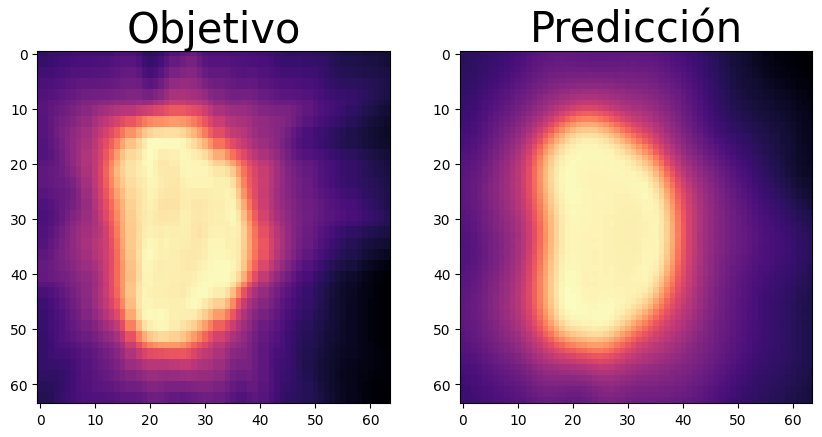

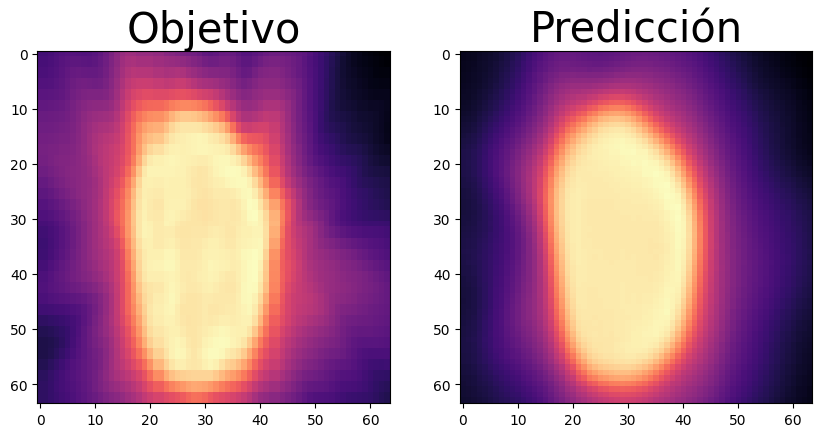

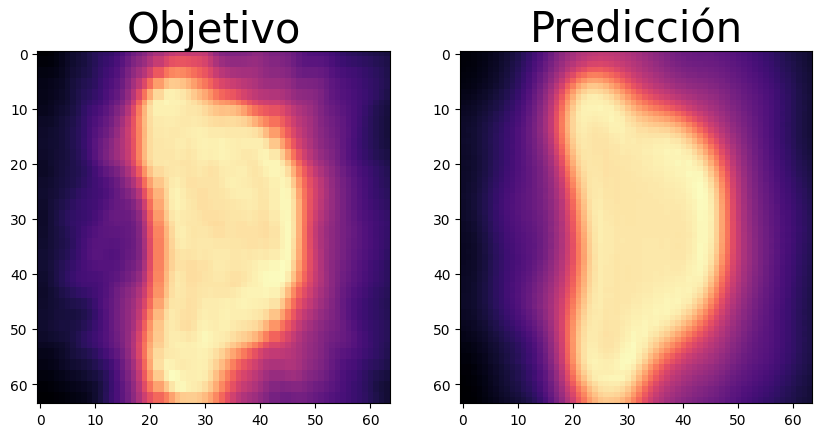

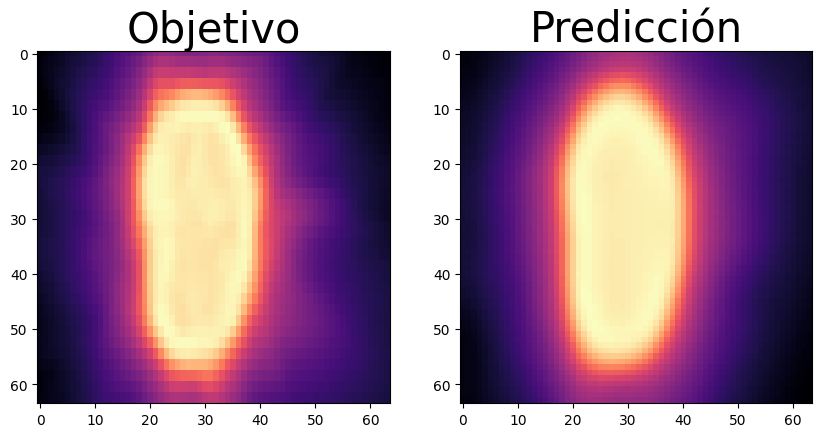

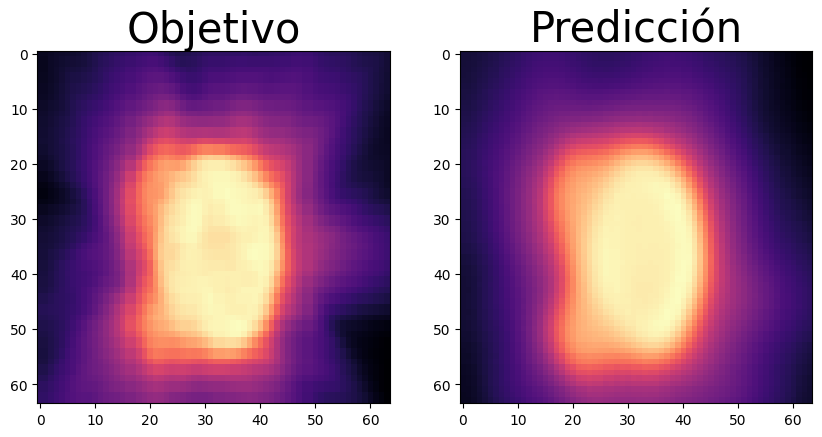

In [29]:
model.to(device)
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()

In [26]:
predecir("DatasetPI/TesteoPI/RU")

Carpetas cargadas
La carpeta Estructuras tiene 30 volúmenes y la carpeta Dosis tiene 30 máscaras
La cantidad de imágenes de testeo son 30.
pred_RU_dosis0 guardada en DatasetPI/TesteoPI/RU
pred_RU_dosis1 guardada en DatasetPI/TesteoPI/RU
pred_RU_dosis10 guardada en DatasetPI/TesteoPI/RU
pred_RU_dosis11 guardada en DatasetPI/TesteoPI/RU
pred_RU_dosis12 guardada en DatasetPI/TesteoPI/RU
pred_RU_dosis122 guardada en DatasetPI/TesteoPI/RU
pred_RU_dosis13 guardada en DatasetPI/TesteoPI/RU
pred_RU_dosis2 guardada en DatasetPI/TesteoPI/RU
pred_RU_dosis3 guardada en DatasetPI/TesteoPI/RU
pred_RU_dosis4 guardada en DatasetPI/TesteoPI/RU
pred_RU_dosis5 guardada en DatasetPI/TesteoPI/RU
pred_RU_dosis6 guardada en DatasetPI/TesteoPI/RU
pred_RU_dosis7 guardada en DatasetPI/TesteoPI/RU
pred_RU_dosis8 guardada en DatasetPI/TesteoPI/RU
pred_RU_dosis9 guardada en DatasetPI/TesteoPI/RU
pred_RU_flip_dosis0 guardada en DatasetPI/TesteoPI/RU
pred_RU_flip_dosis1 guardada en DatasetPI/TesteoPI/RU
pred_RU_flip

# Análisis de resultados
Para comparar los resultados conseguidos con las tres redes se realizan dos tipos de gráficas

## Carga de ejemplos

In [28]:
def cargar_carpeta(carpeta, tipo="paciente", graph=False):
    direc = Path(carpeta +"/")
    ejemplos = [direc/i for i in os.listdir(direc)]
    ejemplos = sorted(ejemplos)
    if graph==True:
        print(f"Ejemplos de {tipo} cargados")
    return ejemplos

def cargar_ejem (dir_est, dir_targets, dirpredUB, dirpredUM, dirpredRU, i, graph=True):
    
    
    ests = cargar_carpeta(dir_est, "estructuras")
    est = np.load(ests[i])
    
    targets = cargar_carpeta(dir_targets, "dosis objetivos")
    target = np.load(targets[i])
    target = target/36.25
    
    results1 = cargar_carpeta(dirpredUB, "predicciones de U-Net Básica",graph)
    pred1 = np.load(results1[i]).squeeze().astype('float64')
    
    results2 = cargar_carpeta(dirpredUM, "predicciones de U-Net Mejorada",graph)
    pred2 = np.load(results2[i]).squeeze().astype('float64')
    
    results3 = cargar_carpeta(dirpredRU, "predicciones de ResU-Net",graph)
    pred3 = np.load(results3[i]).squeeze().astype('float64')
    
    if graph==True:
        
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,10))
        sns.set_style("dark")
        ax1.imshow(target[:,:,32],cmap="magma")
        ax2.imshow(pred1[:,:,32],cmap="magma")
        ax3.imshow(pred2[:,:,32],cmap="magma")
        ax4.imshow(pred3[:,:,32],cmap="magma")
        ax1.set_title("Objetivo de distribución de dosis")
        ax2.set_title("Predicción de U-Net Básica")
        ax3.set_title("Predicción de U-Net Mejorada")
        ax4.set_title("Predicción de ResU-Net")
        plt.show()
    
    return est, target, pred1, pred2, pred3

Ejemplos de predicciones de U-Net Básica cargados
Ejemplos de predicciones de U-Net Mejorada cargados
Ejemplos de predicciones de ResU-Net cargados


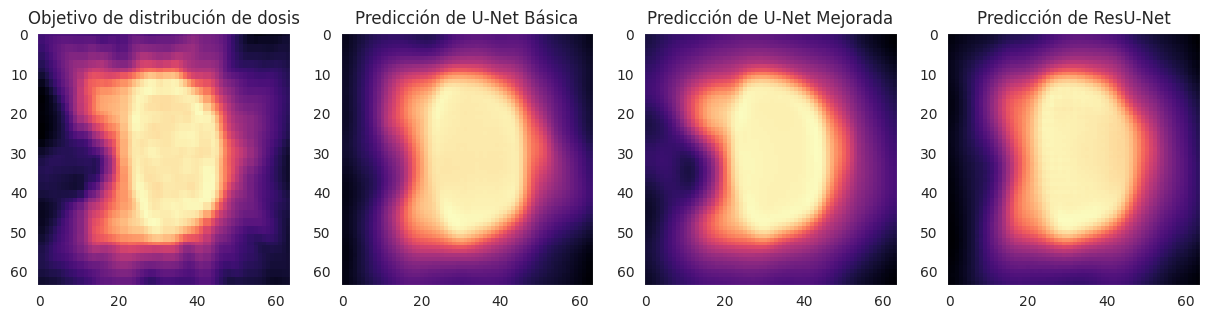

In [30]:
est, target, pred1, pred2, pred3 = cargar_ejem('DatasetPI/TesteoPI/Estructuras',
                                               'DatasetPI/TesteoPI/Dosis',
                                               'DatasetPI/TesteoPI/UB',
                                               'DatasetPI/TesteoPI/UM',
                                               'DatasetPI/TesteoPI/RU',
                                                i=16)

## Coeficiente de Dice para cada intervalo porcentual de dosis 
En esta grafica se compara los tres modelos entre si diferenciando su capacidad de predecir cada valor de porcentaje de dosis por separado. Primero se elige un ejemplo y se realiza su predicción en cada modelo, luego genera un data frame que guarda los datos del coeficiente de Dice entre cada predicción y el objetivo para cada cantidad de dosis porcentual. Finalmente se muestra la gráfica en la que el eje y es el valor Dice alcanzado y el x es el porcentaje de dosis particular.

In [31]:
def valores(tru, pre):
    perc=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]
    suma=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]
    for i in range(len(perc)):
        interseccion =np.count_nonzero(((pre == perc[i])*(pre == tru))) #cantidad de pixeles que coinciden entre la predicción y el objetivo y que son iguales a perc[i](un porcentaje determinado) 
        union=np.count_nonzero(tru == perc[i])+np.count_nonzero(pre == perc[i])#count_nonzer cuenta los vóxeles en los que el valor booleano coincide y es True (descarta las coincidencias False)
        suma[i] = (2*interseccion)/(union+0.000000000000000000000001) #
    return suma

def dataframe(suma0, suma1, suma2, suma3):
    tipos=["Objetivo", "U-Net Básica", "U-Net Mejorada", "ResU-Net"]
    t=["O", "UB", "UM", "RU"]
    red=[]
    r=[]
    for x in range(len(tipos)):
        for i in range(13):
            red.append(tipos[x])
            r.append(t[x]+"_"+str(np.round(i*0.1, decimals=2)))
            
    perc=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
    perc=perc*len(tipos)
    sumar=suma0+suma1+suma2+suma3
    data = {'Red': red,
            'Dice score':sumar,
            "Porcentajes de dosis [%]":perc
            }
    df = pd.DataFrame(data, index= r)
    return df

def Dice_porcent(true, pred1, pred2, pred3, graph=True): 
    
    print
    true = torch.tensor(true)
    true = torch.round(true, decimals=1)

    pre1 = torch.tensor(pred1)
    pred1 = torch.round(pre1, decimals=1)

    pre2 = torch.tensor(pred2)
    pred2 = torch.round(pre2, decimals=1)
    
    pre3 = torch.tensor(pred3)
    pred3 = torch.round(pre3, decimals=1)
    
    suma0 = valores(true, true)
    suma1 = valores(true, pred1)
    suma2 = valores(true, pred2)
    suma3 = valores(true, pred3)
    
    df = dataframe(suma0, suma1, suma2, suma3)
    
    if graph==True:
    
        tipos=["Objetivo", "U-Net Básica", "U-Net Mejorada", "ResU-Net"]
        fig = px.line(df, x='Porcentajes de dosis [%]', y='Dice score', color='Red', color_discrete_map={tipos[0]: "darkblue",
                         tipos[1]: "darkviolet", tipos[2]:"violet",  tipos[3]:"mediumpurple"}, markers=True)
        fig.update_layout(title='Dice score de cada porcentaje de dosis')
        fig.update_traces(textposition="bottom right")
        fig.show()
    
    return df

In [32]:
df = Dice_porcent(target, pred1, pred2, pred3) 
display(df)

Red  Dice score  Porcentajes de dosis [%]
O_0.0         Objetivo    1.000000                         0
O_0.1         Objetivo    1.000000                        10
O_0.2         Objetivo    1.000000                        20
O_0.3         Objetivo    1.000000                        30
O_0.4         Objetivo    1.000000                        40
O_0.5         Objetivo    1.000000                        50
O_0.6         Objetivo    1.000000                        60
O_0.7         Objetivo    1.000000                        70
O_0.8         Objetivo    1.000000                        80
O_0.9         Objetivo    1.000000                        90
O_1.0         Objetivo    1.000000                       100
O_1.1         Objetivo    1.000000                       110
O_1.2         Objetivo    0.000000                       120
UB_0.0    U-Net Básica    0.531532                         0
UB_0.1    U-Net Básica    0.875910                        10
UB_0.2    U-Net Básica    0.388985                        20
UB_0.3    U-Net Básica    0.509154                        30
UB_0.4    U-Net Básica    0.530782                        40
UB_0.5    U-Net Básica    0.531317                        50
UB_0.6    U-Net Básica    0.526504                        60
UB_0.7    U-Net Básica    0.491260                        70
UB_0.8    U-Net Básica    0.476460                        80
UB_0.9    U-Net Básica    0.528113                        90
UB_1.0    U-Net Básica    0.928140                       100
UB_1.1    U-Net Básica    0.000000                       110
UB_1.2    U-Net Básica    0.000000                       120
UM_0.0  U-Net Mejorada    0.619638                         0
UM_0.1  U-Net Mejorada    0.909317                        10
UM_0.2  U-Net Mejorada    0.574077                        20
UM_0.3  U-Net Mejorada    0.589670                        30
UM_0.4  U-Net Mejorada    0.575205                        40
UM_0.5  U-Net Mejorada    0.591649                        50
UM_0.6  U-Net Mejorada    0.577918                        60
UM_0.7  U-Net Mejorada    0.551825                        70
UM_0.8  U-Net Mejorada    0.527938                        80
UM_0.9  U-Net Mejorada    0.539690                        90
UM_1.0  U-Net Mejorada    0.927419                       100
UM_1.1  U-Net Mejorada    0.000000                       110
UM_1.2  U-Net Mejorada    0.000000                       120
RU_0.0        ResU-Net    0.463768                         0
RU_0.1        ResU-Net    0.853085                        10
RU_0.2        ResU-Net    0.426536                        20
RU_0.3        ResU-Net    0.553795                        30
RU_0.4        ResU-Net    0.557990                        40
RU_0.5        ResU-Net    0.533736                        50
RU_0.6        ResU-Net    0.515101                        60
RU_0.7        ResU-Net    0.469317                        70
RU_0.8        ResU-Net    0.447172                        80
RU_0.9        ResU-Net    0.416432                        90
RU_1.0        ResU-Net    0.859196                       100
RU_1.1        ResU-Net    0.000000                       110
RU_1.2        ResU-Net    0.000000                       120

## Histograma Dosis-Volumen 

En el DVH se grafica la distribución de frecuencia de dosis acumulada de cada órgano. En RT son una herramienta útil para comparar diferentes planes de tratamiento en un paciente. Básicamente en el eje y se tiene el porcentaje de cantidad de voxeles total que corresponden a un organo y en el eje x se tiene el porcentaje de dosis considerando el 100% la dosis prescripta para el PTV. Entonces para cada valor de dosis hay un valor de porcentaje de cada órgano que recibe dicha dosis o más.


### Primero se identifican los órganos

In [33]:
def onehot(est):
    esto = (np.arange(4) == est[...,None]).astype(np.float64)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,20))
    ax1.imshow(esto[:,:,32,0],cmap="magma")
    ax2.imshow(esto[:,:,32,1],cmap="magma")
    ax3.imshow(esto[:,:,32,2],cmap="magma")
    ax4.imshow(esto[:,:,32,3],cmap="magma")
    plt.show()
    return esto

### Segundo se realizan histogramas de cada órgano en cada predicción

In [39]:
def HistDV (est, dos, pred1, pred2, pred3, rec, ptv, vej, ejes=True):
    
    dos = torch.from_numpy(dos)
    pred1 = torch.from_numpy(pred1)
    pred2 = torch.from_numpy(pred2)
    pred3 = torch.from_numpy(pred3)
    
    est = torch.from_numpy(est)
    estrec = est[:,:,:,rec]
    estptv = est[:,:,:,ptv]
    estvej = est[:,:,:,vej]
    rec=(dos*estrec).view(-1)
    ptv=(dos*estptv).view(-1)
    vej=(dos*estvej).view(-1)
    rec= rec[rec!=0]
    ptv= ptv[ptv!=0]
    vej= vej[vej!=0]
    
    recp1=(pred1*estrec).view(-1)
    ptvp1=(pred1*estptv).view(-1)
    vejp1=(pred1*estvej).view(-1)
    recp1= recp1[recp1!=0]
    ptvp1= ptvp1[ptvp1!=0]
    vejp1= vejp1[vejp1!=0]
    
    recp2=(pred2*estrec).view(-1)
    ptvp2=(pred2*estptv).view(-1)
    vejp2=(pred2*estvej).view(-1)
    recp2= recp2[recp2!=0]
    ptvp2= ptvp2[ptvp2!=0]
    vejp2= vejp2[vejp2!=0]
    
    recp3=(pred3*estrec).view(-1)
    ptvp3=(pred3*estptv).view(-1)
    vejp3=(pred3*estvej).view(-1)
    recp3= recp3[recp3!=0]
    ptvp3= ptvp3[ptvp3!=0]
    vejp3= vejp3[vejp3!=0]
    
    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize=(20,12))
    sns.set(style="darkgrid")
    sns.histplot( rec, ax=ax1, kde=True, bins=100, color="darkblue", element='step', stat = 'probability')
    sns.histplot( ptv, ax=ax5, kde=True, bins=100, color="darkblue", element='step', stat = 'probability')
    sns.histplot( vej, ax=ax9, kde=True, bins=100, color="darkblue", element='step', stat = 'probability')
    ax1.set_title("Objetivo: Dosis en el recto", fontsize=12)
    ax5.set_title("Objetivo: Dosis en el PTV", fontsize=12)
    ax9.set_title("Objetivo: Dosis en la vejiga", fontsize=12)
    sns.histplot( recp1, ax=ax2, kde=True, bins=100, color="darkviolet", element='step', stat = 'probability')
    sns.histplot( ptvp1, ax=ax6, kde=True, bins=100, color="darkviolet", element='step', stat = 'probability')
    sns.histplot( vejp1, ax=ax10, kde=True, bins=100, color="darkviolet", element='step', stat = 'probability')
    ax2.set_title("U-Net Básica: Dosis en el recto", fontsize=12)
    ax6.set_title("U-Net Básica: Dosis en el PTV", fontsize=12)
    ax10.set_title("U-Net Básica: Dosis en la vejiga", fontsize=12)
    sns.histplot( recp2, ax=ax3, kde=True, bins=100, color="violet", element='step', stat = 'probability')
    sns.histplot( ptvp2, ax=ax7, kde=True, bins=100, color="violet", element='step', stat = 'probability')
    sns.histplot( vejp2, ax=ax11, kde=True, bins=100, color="violet", element='step', stat = 'probability')
    ax3.set_title("U-Net Mejorada: Dosis en el recto", fontsize=12)
    ax7.set_title("U-Net Mejorada: Dosis en el PTV", fontsize=12)
    ax11.set_title("U-Net Mejorada: Dosis en la vejiga", fontsize=12)
    sns.histplot( recp3, ax=ax4, kde=True, bins=100, color="mediumpurple", element='step', stat = 'probability')
    sns.histplot( ptvp3, ax=ax8, kde=True, bins=100, color="mediumpurple", element='step', stat = 'probability')
    sns.histplot( vejp3, ax=ax12, kde=True, bins=100, color="mediumpurple", element='step', stat = 'probability')
    ax4.set_title("ResU-Net: Dosis en el recto", fontsize=12)
    ax8.set_title("ResU-Net: Dosis en el PTV", fontsize=12)
    ax12.set_title("ResU-Net: Dosis en la vejiga", fontsize=12)
    
    if ejes==True:
        recm=0.06
        ptvm=0.1
        vegm=0.09
        ax1.set_ylim(0,recm)
        ax2.set_ylim(0,recm)
        ax3.set_ylim(0,recm)
        ax4.set_ylim(0,recm)

        ax5.set_ylim(0,ptvm)
        ax6.set_ylim(0,ptvm)
        ax7.set_ylim(0,ptvm)
        ax8.set_ylim(0,ptvm)

        ax9.set_ylim(0,vegm)
        ax10.set_ylim(0,vegm)
        ax11.set_ylim(0,vegm)
        ax12.set_ylim(0,vegm)
    
    return rec, ptv, vej, recp1, ptvp1, vejp1, recp2, ptvp2, vejp2, recp3, ptvp3, vejp3 

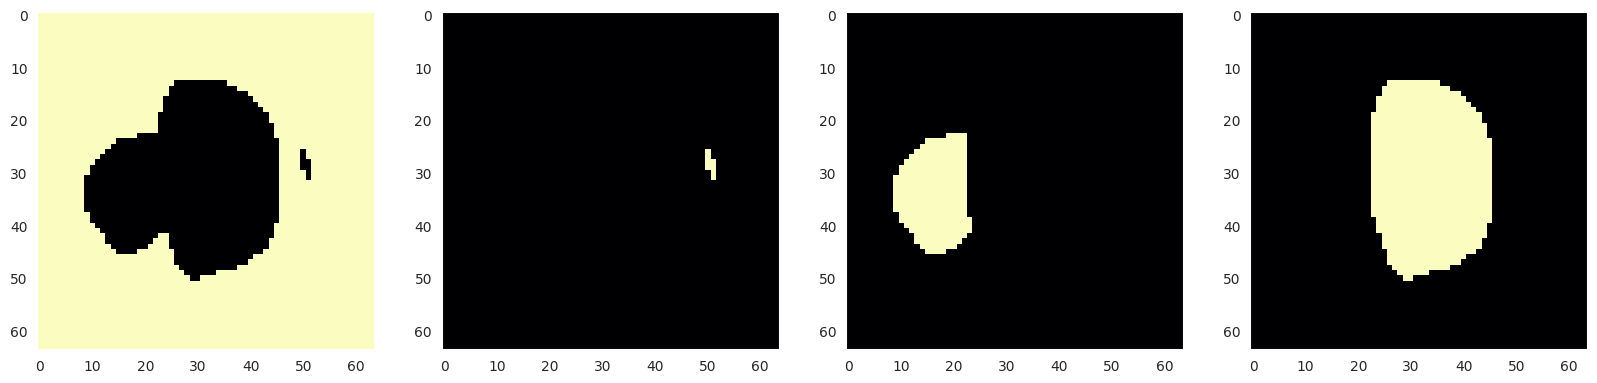

In [35]:
est = onehot(est)

¿Qué capa es el recto?2
¿Qué capa es la próstata?3
¿Qué capa es la vejiga?1


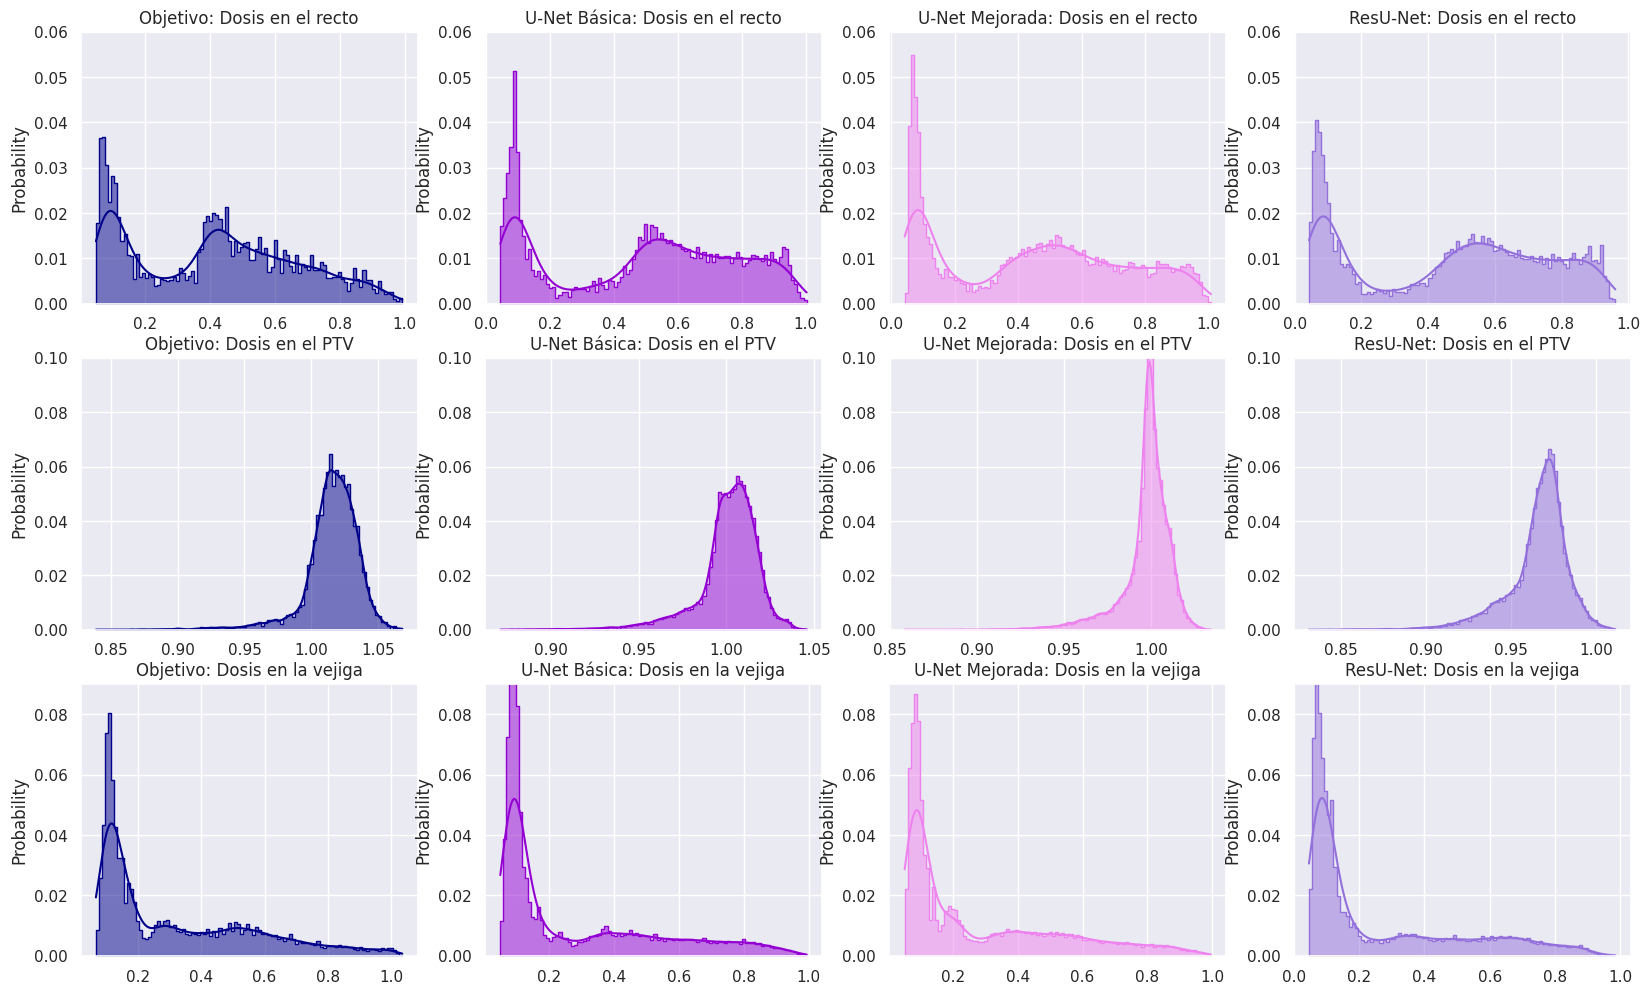

In [40]:
# Los últimos tres argumentos para la función HistDV son la posición del recto, ptv y vejiga (en ese orden) en el onehot,
# en todos los ejemplos esas tres estructuras aparecen en ese orden de izquierda a derecha y en la altura del corte elegido
# (24, se puede ver el orden en la ´primera imagen que es el fondo con la sombra de todas las estructuras extraídas)
# no se suele ver la vejiga, así que la imagen en negro corresponde a esta, además de que el recto suele ser más pequeño
# que la próstata. 
recto = int (input('¿Qué capa es el recto?'))
ptvs = int (input('¿Qué capa es la próstata?'))
vejiga = int (input('¿Qué capa es la vejiga?'))
rec, ptv, vej, recp1, ptvp1, vejp1, recp2, ptvp2, vejp2, recp3, ptvp3, vejp3 = HistDV(est, target, pred1, pred2, pred3, recto, ptvs, vejiga)

In [41]:
def HistDV2 (est, dos, pred1, pred2, pred3, rec, ptv, vej, ejes=True):
    
    dos = torch.from_numpy(dos)
    pred1 = torch.from_numpy(pred1)
    pred2 = torch.from_numpy(pred2)
    pred3 = torch.from_numpy(pred3)
    
    est = torch.from_numpy(est)
    estrec = est[:,:,:,rec]
    estptv = est[:,:,:,ptv]
    estvej = est[:,:,:,vej]
    rec=(dos*estrec).view(-1)
    ptv=(dos*estptv).view(-1)
    vej=(dos*estvej).view(-1)
    rec= rec[rec!=0]
    ptv= ptv[ptv!=0]
    vej= vej[vej!=0]
    
    recp1=(pred1*estrec).view(-1)
    ptvp1=(pred1*estptv).view(-1)
    vejp1=(pred1*estvej).view(-1)
    recp1= recp1[recp1!=0]
    ptvp1= ptvp1[ptvp1!=0]
    vejp1= vejp1[vejp1!=0]
    
    recp2=(pred2*estrec).view(-1)
    ptvp2=(pred2*estptv).view(-1)
    vejp2=(pred2*estvej).view(-1)
    recp2= recp2[recp2!=0]
    ptvp2= ptvp2[ptvp2!=0]
    vejp2= vejp2[vejp2!=0]
    
    recp3=(pred3*estrec).view(-1)
    ptvp3=(pred3*estptv).view(-1)
    vejp3=(pred3*estvej).view(-1)
    recp3= recp3[recp3!=0]
    ptvp3= ptvp3[ptvp3!=0]
    vejp3= vejp3[vejp3!=0]
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,13))
    sns.set(style="darkgrid")
    sns.histplot( rec, ax=ax1, kde=True, bins=100, color="darkblue", element='step', stat = 'probability')
    sns.histplot( ptv, ax=ax2, kde=True, bins=100, color="darkblue", element='step', stat = 'probability')
    sns.histplot( vej, ax=ax3, kde=True, bins=100, color="darkblue", element='step', stat = 'probability')
    sns.histplot( recp1, ax=ax1, kde=True, bins=100, color="darkviolet", element='step', stat = 'probability')
    sns.histplot( ptvp1, ax=ax2, kde=True, bins=100, color="darkviolet", element='step', stat = 'probability')
    sns.histplot( vejp1, ax=ax3, kde=True, bins=100, color="darkviolet", element='step', stat = 'probability')
    sns.histplot( recp2, ax=ax1, kde=True, bins=100, color="violet", element='step', stat = 'probability')
    sns.histplot( ptvp2, ax=ax2, kde=True, bins=100, color="violet", element='step', stat = 'probability')
    sns.histplot( vejp2, ax=ax3, kde=True, bins=100, color="violet", element='step', stat = 'probability')
    sns.histplot( recp3, ax=ax1, kde=True, bins=100, color="mediumpurple", element='step', stat = 'probability')
    sns.histplot( ptvp3, ax=ax2, kde=True, bins=100, color="mediumpurple", element='step', stat = 'probability')
    sns.histplot( vejp3, ax=ax3, kde=True, bins=100, color="mediumpurple", element='step', stat = 'probability')
    ax1.set_title("Dosis en el recto. Azul:objetivo, Morado:U-Net B, Rosado: U-Net M y Lila: ResU-Net", fontsize=20)
    ax2.set_title("Dosis en el PTV. Azul:objetivo, Morado:U-Net B, Rosado: U-Net M y Lila: ResU-Net", fontsize=20)
    ax3.set_title("Dosis en la vejiga. Azul:objetivo, Morado:U-Net B, Rosado: U-Net M y Lila: ResU-Net", fontsize=20)
    
    return rec, ptv, vej, recp1, ptvp1, vejp1, recp2, ptvp2, vejp2, recp3, ptvp3, vejp3 


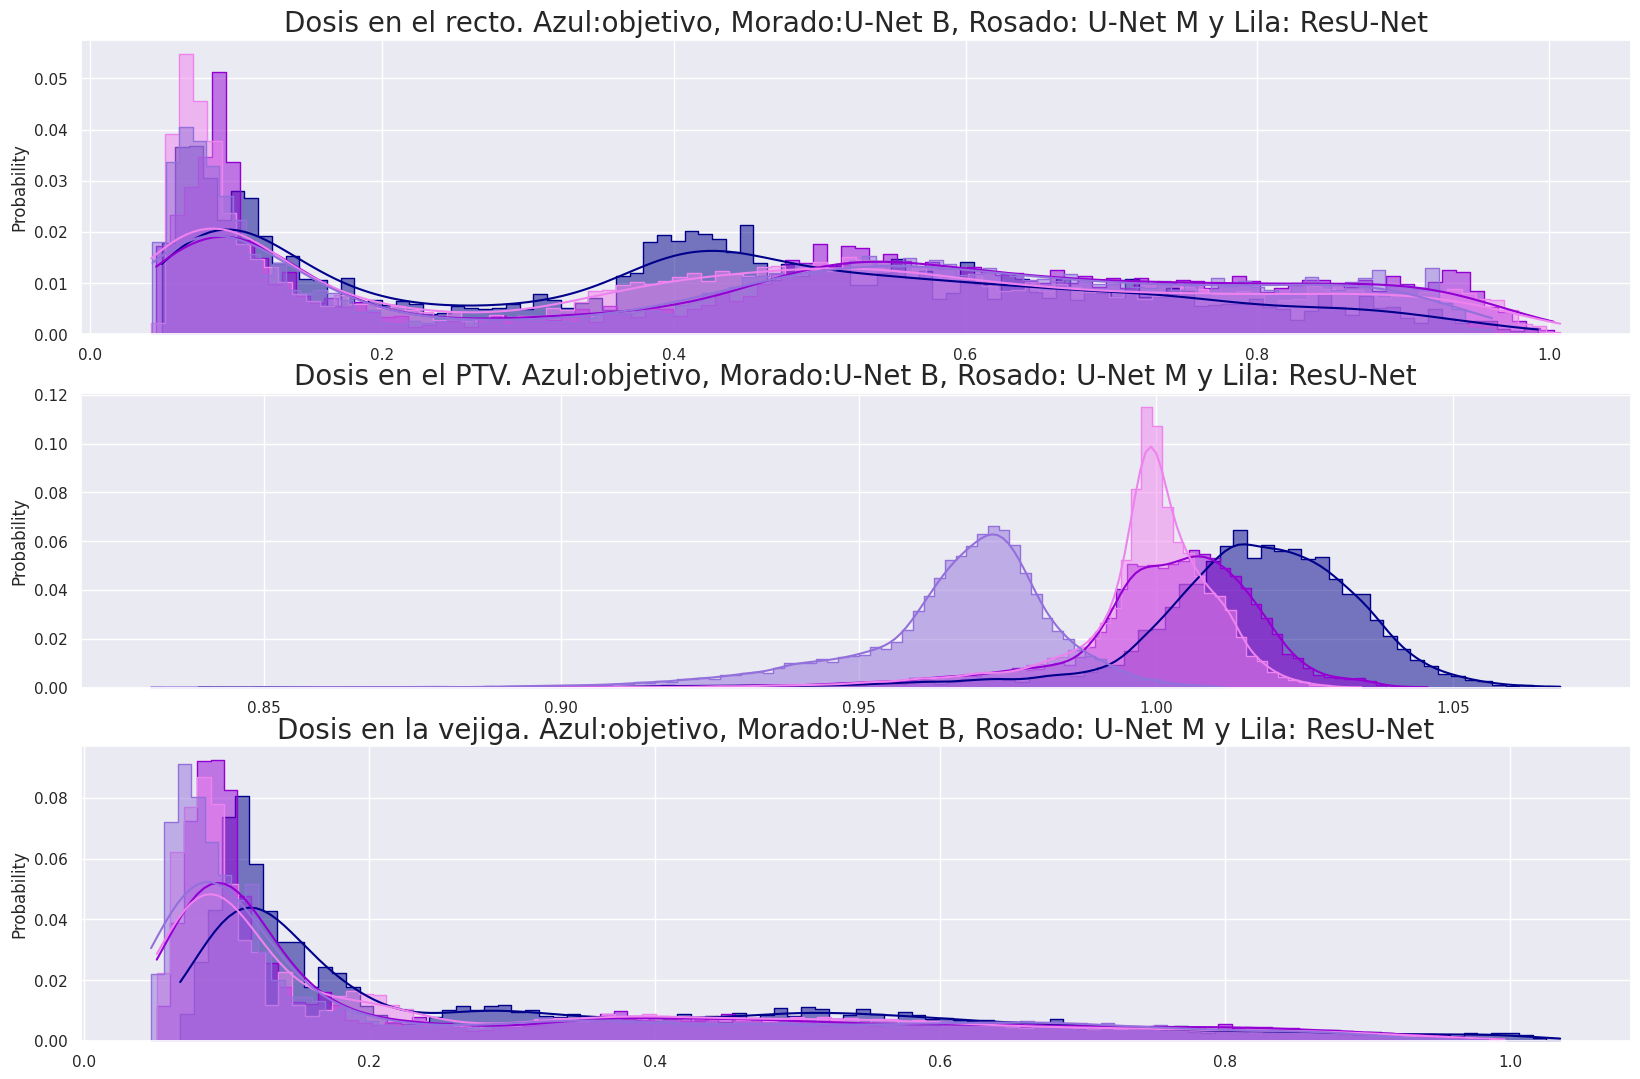

In [42]:
rec, ptv, vej, recp1, ptvp1, vejp1, recp2, ptvp2, vejp2, recp3, ptvp3, vejp3 = HistDV2(est, target, pred1, pred2, pred3, recto, ptvs, vejiga)

### Por ultimo se obtien el HDV

In [43]:
def acumular(organo):
    
    porcentajes = np.round(np.arange(0, 1.21, 0.01), decimals=2)
    acumulado = np.zeros(len(porcentajes))
    
    org = torch.round(organo, decimals=2)
    serie = pd.Series(org) # convertir los datos del grafico en una tabla 
    df = pd.DataFrame(serie.value_counts(normalize = True, sort=False)) # cuenta la ocurrencia de cada dosis y las ordena 
    df = df.rename_axis('Dosis').reset_index().sort_values(by=["Dosis"]) # define la columna dosis
    ndf= df.to_numpy()

    voxeles = np.zeros(len(porcentajes))
    for i in range(len(porcentajes)): 
        for j in range(len(ndf)):
             if ndf[j,0]==porcentajes[i]:
                    voxeles[i]=ndf[j,1] # rellena de 0 los valores de dosis faltantes 

        for i in range(len(acumulado)):
            acumulado[i] = sum(voxeles[i:]) # realiza el acumulado del DVH     
        
    return acumulado



def DVH (ptv,ptvp1, ptvp2, ptvp3, rec, recp1, recp2, recp3, vej, vejp1, vejp2, vejp3):
 
    organos = [ptv,ptvp1, ptvp2, ptvp3, rec, recp1, recp2, recp3, vej, vejp1, vejp2, vejp3]
    organo = ["ptv_objetivo", "ptv_U-Net_B", "ptv_U-Net_M", "ptv_U-ResNet", "recto_objetivo", "recto_U-Net_B", "recto_U-Net_M", "recto_ResU-Net", "vejiga_objetivo", "vejiga_U-Net_B", "vejiga_U-Net_M", "vejiga_ResU-Net"]
    a=np.zeros(121)
    grafico=[a,a,a,a,a,a,a,a,a,a,a,a]
    df = pd.DataFrame ({'Porcentajes de dosis [%]': np.arange(0, 121, 1)})
    
    for x in range(len(organos)):        
        df [organo[x]] = acumular(organos[x]).tolist()
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df['Porcentajes de dosis [%]'], y=df["recto_objetivo"], name="recto_objetivo", line=dict(color='darkblue', dash='solid')))
    fig.add_trace(go.Scatter(x=df['Porcentajes de dosis [%]'], y=df["ptv_objetivo"], name="ptv_objetivo", line=dict(color='darkblue', dash='dashdot')))
    fig.add_trace(go.Scatter(x=df['Porcentajes de dosis [%]'], y=df["vejiga_objetivo"], name="vejiga_objetivo", line=dict(color='darkblue', dash='dash')))
    fig.add_trace(go.Scatter(x=df['Porcentajes de dosis [%]'], y=df["recto_U-Net_B"], name="recto_U-Net_B", line=dict(color='darkviolet', dash='solid')))
    fig.add_trace(go.Scatter(x=df['Porcentajes de dosis [%]'], y=df["ptv_U-Net_B"], name="ptv_U-Net_B", line=dict(color='darkviolet', dash='dashdot')))
    fig.add_trace(go.Scatter(x=df['Porcentajes de dosis [%]'], y=df["vejiga_U-Net_B"], name="vejiga_U-Net_B", line=dict(color='darkviolet', dash='dash')))
    fig.add_trace(go.Scatter(x=df['Porcentajes de dosis [%]'], y=df["recto_U-Net_M"], name="recto_U-Net_M", line=dict(color='violet', dash='solid')))
    fig.add_trace(go.Scatter(x=df['Porcentajes de dosis [%]'], y=df["ptv_U-Net_M"], name="ptv_U-Net_M", line=dict(color='violet', dash='dashdot')))
    fig.add_trace(go.Scatter(x=df['Porcentajes de dosis [%]'], y=df["vejiga_U-Net_M"], name="vejiga_U-Net_M", line=dict(color='violet', dash='dash')))
    fig.add_trace(go.Scatter(x=df['Porcentajes de dosis [%]'], y=df["recto_ResU-Net"], name="recto_ResU-Net", line=dict(color='mediumpurple', dash='solid')))
    fig.add_trace(go.Scatter(x=df['Porcentajes de dosis [%]'], y=df["ptv_U-ResNet"], name="ptv_U-ResNet", line=dict(color='mediumpurple', dash='dashdot')))
    fig.add_trace(go.Scatter(x=df['Porcentajes de dosis [%]'], y=df["vejiga_ResU-Net"], name="vejiga_ResU-Net", line=dict(color='mediumpurple', dash='dash')))
    fig.update_layout(title='DVH acumulado', xaxis_title='Porcentaje de dosis [%]', yaxis_title='Cantidad relativa de tejido')
    
    fig.show()

In [44]:
DVH(ptv,ptvp1, ptvp2, ptvp3, rec, recp1, recp2, recp3, vej, vejp1, vejp2, vejp3)

# índice de Dice final

# Predicciones de los otros ejemplos 

In [46]:
def ejemplos():    
    for i in range(30):

        sns.set_style("dark")

        est, target, pred1, pred2, pred3 = cargar_ejem('DatasetPI/TesteoPI/Estructuras',
                                                       'DatasetPI/TesteoPI/Dosis',
                                                       'DatasetPI/TesteoPI/UB',
                                                       'DatasetPI/TesteoPI/UM',
                                                       'DatasetPI/TesteoPI/RU',
                                                        i=i)
        print("----------------------------------------------------------------------")
        print(f"Ejemplo número {i}:")
        print()
        df = Dice_porcent(target, pred1, pred2, pred3)
        est = onehot(est)
        recto = int (input('¿Qué capa es el recto?'))
        ptv = int (input('¿Qué capa es la próstata?'))
        vejiga = int (input('¿Qué capa es la vejiga?'))
        si = input('¿Seguro?')
        if si!='si':
            recto = int (input('¿Qué capa es el recto?'))
            ptv = int (input('¿Qué capa es la próstata?'))
            vejiga = int (input('¿Qué capa es la vejiga?')) 

        rec, ptv, vej, recp1, ptvp1, vejp1, recp2, ptvp2, vejp2, recp3, ptvp3, vejp3 = HistDV2(est, target, pred1, pred2, pred3, recto, ptv, vejiga, ejes=False)
        DVH(ptv,ptvp1, ptvp2, ptvp3, rec, recp1, recp2, recp3, vej, vejp1, vejp2, vejp3)



In [45]:
ejemplos()

## Coeficiente de Dice promedio para cada intervalo porcentual de dosis 

In [47]:
def Dice_final():
    
    val0UB = []
    val10UB = []
    val20UB = []
    val30UB = []
    val40UB = []
    val50UB = []
    val60UB = []
    val70UB = []
    val80UB = []
    val90UB = []
    val100UB = []
    val110UB = []
    val0UM = []
    val10UM = []
    val20UM = []
    val30UM = []
    val40UM = []
    val50UM = []
    val60UM = []
    val70UM = []
    val80UM = []
    val90UM = []
    val100UM = []
    val110UM = []        
    val0RU = []
    val10RU = []
    val20RU = []
    val30RU = []
    val40RU = []
    val50RU = []
    val60RU = []
    val70RU = []
    val80RU = []
    val90RU = []
    val100RU = []
    val110RU = []
    
    for i in range(30):
        est, true, pred1, pred2, pred3 = cargar_ejem('DatasetPI/TesteoPI/Estructuras',
                                               'DatasetPI/TesteoPI/Dosis',
                                               'DatasetPI/TesteoPI/UB',
                                               'DatasetPI/TesteoPI/UM',
                                               'DatasetPI/TesteoPI/RU',
                                                i=i,
                                                graph=False)
        
        df = Dice_porcent(true, pred1, pred2, pred3, graph=False)
        val0UB.append(df['Dice score']['UB_0.0']) # en cada lista se van a tener los 30 calculos de índice de Dice para cada dosis de cada red
        val10UB.append(df['Dice score']['UB_0.1']) # se intento genrar con un loop pero los valores se reescribian en el dataframe
        val20UB.append(df['Dice score']['UB_0.2'])
        val30UB.append(df['Dice score']['UB_0.3'])
        val40UB.append(df['Dice score']['UB_0.4'])
        val50UB.append(df['Dice score']['UB_0.5'])
        val60UB.append(df['Dice score']['UB_0.6'])
        val70UB.append(df['Dice score']['UB_0.7'])
        val80UB.append(df['Dice score']['UB_0.8'])
        val90UB.append(df['Dice score']['UB_0.9'])
        val100UB.append(df['Dice score']['UB_1.0'])
        val110UB.append(df['Dice score']['UB_1.1'])
        
        val0UM.append(df['Dice score']['UM_0.0'])
        val10UM.append(df['Dice score']['UM_0.1'])
        val20UM.append(df['Dice score']['UM_0.2'])
        val30UM.append(df['Dice score']['UM_0.3'])
        val40UM.append(df['Dice score']['UM_0.4'])
        val50UM.append(df['Dice score']['UM_0.5'])
        val60UM.append(df['Dice score']['UM_0.6'])
        val70UM.append(df['Dice score']['UM_0.7'])
        val80UM.append(df['Dice score']['UM_0.8'])
        val90UM.append(df['Dice score']['UM_0.9'])
        val100UM.append(df['Dice score']['UM_1.0'])
        val110UM.append(df['Dice score']['UM_1.1'])
        
        val0RU.append(df['Dice score']['RU_0.0'])
        val10RU.append(df['Dice score']['RU_0.1'])
        val20RU.append(df['Dice score']['RU_0.2'])
        val30RU.append(df['Dice score']['RU_0.3'])
        val40RU.append(df['Dice score']['RU_0.4'])
        val50RU.append(df['Dice score']['RU_0.5'])
        val60RU.append(df['Dice score']['RU_0.6'])
        val70RU.append(df['Dice score']['RU_0.7'])
        val80RU.append(df['Dice score']['RU_0.8'])
        val90RU.append(df['Dice score']['RU_0.9'])
        val100RU.append(df['Dice score']['RU_1.0'])
        val110RU.append(df['Dice score']['RU_1.1'])

    val0UB = statistics.mean(val0UB)
    val10UB = statistics.mean(val10UB)
    val20UB = statistics.mean(val20UB)
    val30UB = statistics.mean(val30UB)
    val40UB = statistics.mean(val40UB)
    val50UB = statistics.mean(val50UB)
    val60UB = statistics.mean(val60UB)
    val70UB = statistics.mean(val70UB)
    val80UB = statistics.mean(val80UB)
    val90UB = statistics.mean(val90UB)
    val100UB = statistics.mean(val100UB)
    val110UB = statistics.mean(val110UB)
    val0UM = statistics.mean(val0UM)
    val10UM = statistics.mean(val10UM)
    val20UM = statistics.mean(val20UM)
    val30UM = statistics.mean(val30UM)
    val40UM = statistics.mean(val40UM)
    val50UM = statistics.mean(val50UM)
    val60UM = statistics.mean(val60UM)
    val70UM = statistics.mean(val70UM)
    val80UM = statistics.mean(val80UM)
    val90UM = statistics.mean(val90UM)
    val100UM = statistics.mean(val100UM)
    val110UM = statistics.mean(val110UM)        
    val0RU = statistics.mean(val0RU)
    val10RU = statistics.mean(val10RU)
    val20RU = statistics.mean(val20RU)
    val30RU = statistics.mean(val30RU)
    val40RU = statistics.mean(val40RU)
    val50RU = statistics.mean(val50RU)
    val60RU = statistics.mean(val60RU)
    val70RU = statistics.mean(val70RU)
    val80RU = statistics.mean(val80RU)
    val90RU = statistics.mean(val90RU)
    val100RU = statistics.mean(val100RU)
    val110RU = statistics.mean(val110RU)

    tipos=[ "U-Net Básica", "U-Net Mejorada", "ResU-Net"]
    t=["UB", "UM", "RU"]
    red=[]
    r=[]
    for x in range(len(tipos)):
        for i in range(12):
            red.append(tipos[x])
            r.append(t[x]+"_"+str(np.round(i*0.1, decimals=2)))
            
    perc=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
    perc=perc*len(tipos)
    sumar = [val0UB, val10UB, val20UB, val30UB, val40UB, val50UB, val60UB, val70UB, val80UB, val90UB, val100UB, val110UB, 
             val0UM, val10UM, val20UM, val30UM, val40UM, val50UM, val60UM, val70UM, val80UM, val90UM, val100UM, val110UM, 
             val0RU, val10RU, val20RU, val30RU, val40RU, val50RU, val60RU, val70RU, val80RU, val90RU, val100RU, val110RU]
    data = {'Red': red,
            'Dice score':sumar,
            "Porcentajes de dosis [%]":perc
            }
    dff = pd.DataFrame(data, index= r)
    
    tipos=["U-Net Básica", "U-Net Mejorada", "ResU-Net"]
    fig = px.line(dff, x='Porcentajes de dosis [%]', y='Dice score', color='Red', color_discrete_map={ tipos[0]: "darkviolet", 
                tipos[1]:"violet",  tipos[2]:"mediumpurple"}, markers=True)
    fig.update_layout(title='Dice score de cada porcentaje de dosis')
    fig.update_traces(textposition="bottom right")
    fig.show()
    
    print(f"En promedio entre los 30 ejemplos, la red U-Net Básica tiene un índice Dice de {val0UB:.4f} para dosis del 0%")
    print(f"En promedio entre los 30 ejemplos, la red U-Net Básica tiene un índice Dice de {val50UB:.4f} para dosis del 50%")
    print(f"En promedio entre los 30 ejemplos, la red U-Net Básica tiene un índice Dice de {val100UB:.4f} para dosis del 100%")
    print(f"En promedio entre los 30 ejemplos, la red U-Net Mejorada tiene un índice Dice de {val0UM:.4f} para dosis del 0%")
    print(f"En promedio entre los 30 ejemplos, la red U-Net Mejorada tiene un índice Dice de {val50UM:.4f} para dosis del 50%")
    print(f"En promedio entre los 30 ejemplos, la red U-Net Mejorada tiene un índice Dice de {val100UM:.4f} para dosis del 100%")
    print(f"En promedio entre los 30 ejemplos, la red ResU-Net tiene un índice Dice de {val0RU:.4f} para dosis del 0%")
    print(f"En promedio entre los 30 ejemplos, la red ResU-Net tiene un índice Dice de {val50RU:.4f} para dosis del 50%")
    print(f"En promedio entre los 30 ejemplos, la red ResU-Net tiene un índice Dice de {val100RU:.4f} para dosis del 100%")

    return 

In [48]:
Dice_final()  

En promedio entre los 30 ejemplos, la red U-Net Básica tiene un índice Dice de 0.7663 para dosis del 0%
En promedio entre los 30 ejemplos, la red U-Net Básica tiene un índice Dice de 0.5381 para dosis del 50%
En promedio entre los 30 ejemplos, la red U-Net Básica tiene un índice Dice de 0.7554 para dosis del 100%
En promedio entre los 30 ejemplos, la red U-Net Mejorada tiene un índice Dice de 0.8451 para dosis del 0%
En promedio entre los 30 ejemplos, la red U-Net Mejorada tiene un índice Dice de 0.5904 para dosis del 50%
En promedio entre los 30 ejemplos, la red U-Net Mejorada tiene un índice Dice de 0.8286 para dosis del 100%
En promedio entre los 30 ejemplos, la red ResU-Net tiene un índice Dice de 0.6447 para dosis del 0%
En promedio entre los 30 ejemplos, la red ResU-Net tiene un índice Dice de 0.5105 para dosis del 50%
En promedio entre los 30 ejemplos, la red ResU-Net tiene un índice Dice de 0.5522 para dosis del 100%
